In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb

In [27]:
df = pd.read_csv('/kaggle/input/data-storm-4/Historical-transaction-data.csv',low_memory=False)
st =  pd.read_csv('/kaggle/input/data-storm-4/Store-info.csv',low_memory=False)

In [28]:
df.head()

item_description          transaction_date  invoice_id customer_id  \
0     ORANGE BARLEY 1.5L  2021-12-11T00:00:00.000Z       147.0        BGXA   
1       GINGER BEER 1.5L  2021-10-17T00:00:00.000Z       371.0        IA25   
2        TONIC PET 500ML  2021-12-13T00:00:00.000Z       484.0        VN7V   
3          CREAM SODA 1L  2021-12-13T00:00:00.000Z       484.0        VN7V   
4  STRAWBERRY MILK 180ML  2021-10-23T00:00:00.000Z      1310.0        7S00   

   shop_id  item_price  quantity_sold  
0  SHOP008         220              2  
1  SHOP112         220              2  
2  SHOP008         160              2  
3  SHOP008         150              2  
4  SHOP112         210              5

In [29]:
st

shop_id  shop_area_sq_ft shop_profile
0    SHOP047              528     Moderate
1    SHOP009              676         High
2    SHOP083              676          Low
3    SHOP117              676          Low
4    SHOP042              676          Low
..       ...              ...          ...
119  SHOP087              527          NaN
120  SHOP050              411          NaN
121  SHOP061              699          NaN
122  SHOP056              597          NaN
123  SHOP070              676          NaN

[124 rows x 3 columns]

In [30]:
df['quantity_sold'].unique()

array([  2,   5,   1,   3,   4,   6,   0,  15,   7,  16,   8,  12,   9,
        14,  11,  10,  30,  13,  23,  24,  -1,  17,  20,  49,  48,  21,
        26,  31,  25,  36,  37,  19,  66,  59,  62,  22,  71,  39,  18,
        35,  42,  27,  33,  41,  46,  50,  40,  29,  97,  28,  72,  56,
        38,  43,  32,  76,  51,  52,  44,  45,  73,  61,  63, 100, 101,
        34,  60,  47,  53])

-1 and 0 should not be here 

In [31]:
df[(df['quantity_sold']==0) & (df['item_price']>=300)]

item_description          transaction_date  invoice_id customer_id  \
75314   LIME CRUSH JUICE 1L  2021-12-04T00:00:00.000Z   1310839.0        Y3OX   
464326      TONIC PET 500ML  2021-12-04T00:00:00.000Z    440044.0        AHTZ   

        shop_id  item_price  quantity_sold  
75314   SHOP089         650              0  
464326  SHOP102         320              0

resonable to fit those with 1

In [32]:
df['quantity_sold'] = df['quantity_sold'].replace(0, 1)
df['quantity_sold'] = df['quantity_sold'].abs().fillna(df['quantity_sold'].abs())

In [33]:
df['quantity_sold'].unique()

array([  2,   5,   1,   3,   4,   6,  15,   7,  16,   8,  12,   9,  14,
        11,  10,  30,  13,  23,  24,  17,  20,  49,  48,  21,  26,  31,
        25,  36,  37,  19,  66,  59,  62,  22,  71,  39,  18,  35,  42,
        27,  33,  41,  46,  50,  40,  29,  97,  28,  72,  56,  38,  43,
        32,  76,  51,  52,  44,  45,  73,  61,  63, 100, 101,  34,  60,
        47,  53])

In [34]:
df.drop(['invoice_id',"customer_id"],axis=1,inplace=True)

In [35]:
df_grouped = df.groupby(['shop_id', 'item_description']).agg({'quantity_sold': 'sum'}).reset_index()

df_pivot = df_grouped.pivot(index='shop_id', columns='item_description', values='quantity_sold').reset_index()

df_pivot

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   
..                    ...                          ...   
119               SHOP123                         97.0   
120               SHOP124                        211.0   
121               SHOP125                        100.0   
122               SHOP126                        142.0   
123               SHOP127                        320.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   NaN   
1                                        381.0                   NaN   
2                                        357.0                   NaN   
3                                        170.0                   NaN   
4                                        217.0                   4.0   
..                                         ...                   ...   
119                                      134.0                  11.0   
120                                      556.0                   NaN   
121                                      346.0                   NaN   
122                                      298.0                   NaN   
123                                     1015.0                   NaN   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   
..                            ...            ...               ...   
119                         315.0           25.0             242.0   
120                         441.0           50.0             464.0   
121                          70.0           23.0             345.0   
122                         322.0            NaN             568.0   
123                         535.0           26.0             483.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   
..                                    ...                       ...   
119                                 107.0                      27.0   
120                                 119.0                     150.0   
121                                  25.0                      88.0   
122                                 124.0                     211.0   
123                                 266.0                      77.0   

item_description  FIT O MANGO 1L  ...  ORANGE BARLEY 1.5L  ORANGE CRUSH 1.5L  \
0                           36.0  ...               205.0               53.0   
1                           66.0  ...               397.0              184.0   
2                          106.0  ...               283.0              104.0   
3                           48.0  ...               308.0               97.0   
4                          122.0  ...               222.0              128.0   
..                           ...  ...                 ...                ...   
119                         61.0  ...               146.0               67.0   
120                        160.0  ...               261.0              118.0   
121                     

In [36]:
df_pivot.fillna(0, inplace=True)

In [37]:
df_pivot['total_item_count'] = df_pivot.drop(['shop_id'], axis=1).sum(axis=1)
df_pivot

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   
..                    ...                          ...   
119               SHOP123                         97.0   
120               SHOP124                        211.0   
121               SHOP125                        100.0   
122               SHOP126                        142.0   
123               SHOP127                        320.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   0.0   
1                                        381.0                   0.0   
2                                        357.0                   0.0   
3                                        170.0                   0.0   
4                                        217.0                   4.0   
..                                         ...                   ...   
119                                      134.0                  11.0   
120                                      556.0                   0.0   
121                                      346.0                   0.0   
122                                      298.0                   0.0   
123                                     1015.0                   0.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   
..                            ...            ...               ...   
119                         315.0           25.0             242.0   
120                         441.0           50.0             464.0   
121                          70.0           23.0             345.0   
122                         322.0            0.0             568.0   
123                         535.0           26.0             483.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   
..                                    ...                       ...   
119                                 107.0                      27.0   
120                                 119.0                     150.0   
121                                  25.0                      88.0   
122                                 124.0                     211.0   
123                                 266.0                      77.0   

item_description  FIT O MANGO 1L  ...  ORANGE CRUSH 1.5L  ORANGE CRUSH 1L  \
0                           36.0  ...               53.0             20.0   
1                           66.0  ...              184.0             25.0   
2                          106.0  ...              104.0             10.0   
3                           48.0  ...               97.0             19.0   
4                          122.0  ...              128.0             15.0   
..                           ...  ...                ...              ...   
119                         61.0  ...               67.0             13.0   
120                        160.0  ...              118.0             16.0   
121                         36.0  ...              

In [38]:
price_sum = df.groupby('shop_id')['item_price'].sum()
df_pivot['total_price'] = df_pivot['shop_id'].map(price_sum)
df_pivot.head()

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   0.0   
1                                        381.0                   0.0   
2                                        357.0                   0.0   
3                                        170.0                   0.0   
4                                        217.0                   4.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   

item_description  FIT O MANGO 1L  ...  ORANGE CRUSH 1L  ORANGE CRUSH 500ML  \
0                           36.0  ...             20.0                27.0   
1                           66.0  ...             25.0                66.0   
2                          106.0  ...             10.0                49.0   
3                           48.0  ...             19.0                64.0   
4                          122.0  ...             15.0                50.0   

item_description  SODA 1L  SODA 500ML  SODA PET 1.5L  STRAWBERRY MILK 180ML  \
0                    99.0       135.0           97.0                   30.0   
1                   278.0       370.0          455.0                   53.0   
2                   229.0       284.0          275.0                   83.0   
3                   234.0       297.0          181.0                   97.0   
4                   231.0       189.0          243.0                  122.0   

item_description  TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  \
0                           130.0              21.0            3529.0   
1                           332.0              54.0            8627.0   
2                           281.0              33.0            6466.0   
3                           187.0              49.0            6067.0   
4                           233.0              57.0            6644.0   

item_description  total_price  
0                      433145  
1                     1090135  
2                      769685  
3                      711050  
4                      842995  

[5 rows x 40 columns]

In [39]:
df_pivot

item_description  shop_id  BOTTLED DRINKING WATER 1.5L  \
0                 SHOP001                         63.0   
1                 SHOP002                        123.0   
2                 SHOP003                        146.0   
3                 SHOP004                         77.0   
4                 SHOP005                        119.0   
..                    ...                          ...   
119               SHOP123                         97.0   
120               SHOP124                        211.0   
121               SHOP125                        100.0   
122               SHOP126                        142.0   
123               SHOP127                        320.0   

item_description  BOTTLED DRINKING WATER 500ML  CHOCOLATE MILK 180ML  \
0                                        220.0                   0.0   
1                                        381.0                   0.0   
2                                        357.0                   0.0   
3                                        170.0                   0.0   
4                                        217.0                   4.0   
..                                         ...                   ...   
119                                      134.0                  11.0   
120                                      556.0                   0.0   
121                                      346.0                   0.0   
122                                      298.0                   0.0   
123                                     1015.0                   0.0   

item_description  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                           371.0           29.0             153.0   
1                          1110.0           65.0             802.0   
2                           646.0          100.0             524.0   
3                           563.0           59.0             369.0   
4                           569.0           50.0             431.0   
..                            ...            ...               ...   
119                         315.0           25.0             242.0   
120                         441.0           50.0             464.0   
121                          70.0           23.0             345.0   
122                         322.0            0.0             568.0   
123                         535.0           26.0             483.0   

item_description  CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  \
0                                    99.0                      24.0   
1                                   168.0                      92.0   
2                                   222.0                      41.0   
3                                    97.0                      50.0   
4                                   165.0                      67.0   
..                                    ...                       ...   
119                                 107.0                      27.0   
120                                 119.0                     150.0   
121                                  25.0                      88.0   
122                                 124.0                     211.0   
123                                 266.0                      77.0   

item_description  FIT O MANGO 1L  ...  ORANGE CRUSH 1L  ORANGE CRUSH 500ML  \
0                           36.0  ...             20.0                27.0   
1                           66.0  ...             25.0                66.0   
2                          106.0  ...             10.0                49.0   
3                           48.0  ...             19.0                64.0   
4                          122.0  ...             15.0                50.0   
..                           ...  ...              ...                 ...   
119                         61.0  ...             13.0                33.0   
120                        160.0  ...             16.0                63.0   
121                         36.0  ...     

In [40]:
le = LabelEncoder()

# Replace null values with a placeholder
st['shop_profile'].fillna(value='NA', inplace=True)

# Modify the label encoding
target_map = {'Low': 0, 'Moderate': 1, 'High': 2}
le.fit(list(target_map.keys()))
st['shop_profile'] = st['shop_profile'].map(target_map)
# st['shop_profile'].fillna(value=None, inplace=True)

In [41]:
st

shop_id  shop_area_sq_ft  shop_profile
0    SHOP047              528           1.0
1    SHOP009              676           2.0
2    SHOP083              676           0.0
3    SHOP117              676           0.0
4    SHOP042              676           0.0
..       ...              ...           ...
119  SHOP087              527           NaN
120  SHOP050              411           NaN
121  SHOP061              699           NaN
122  SHOP056              597           NaN
123  SHOP070              676           NaN

[124 rows x 3 columns]

In [42]:
df_combined = pd.merge(df_pivot, st, on='shop_id', how='inner')
df_combined

shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
0    SHOP001                         63.0                         220.0   
1    SHOP002                        123.0                         381.0   
2    SHOP003                        146.0                         357.0   
3    SHOP004                         77.0                         170.0   
4    SHOP005                        119.0                         217.0   
..       ...                          ...                           ...   
119  SHOP123                         97.0                         134.0   
120  SHOP124                        211.0                         556.0   
121  SHOP125                        100.0                         346.0   
122  SHOP126                        142.0                         298.0   
123  SHOP127                        320.0                        1015.0   

     CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                     0.0            371.0           29.0             153.0   
1                     0.0           1110.0           65.0             802.0   
2                     0.0            646.0          100.0             524.0   
3                     0.0            563.0           59.0             369.0   
4                     4.0            569.0           50.0             431.0   
..                    ...              ...            ...               ...   
119                  11.0            315.0           25.0             242.0   
120                   0.0            441.0           50.0             464.0   
121                   0.0             70.0           23.0             345.0   
122                   0.0            322.0            0.0             568.0   
123                   0.0            535.0           26.0             483.0   

     CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
0                       99.0                      24.0            36.0  ...   
1                      168.0                      92.0            66.0  ...   
2                      222.0                      41.0           106.0  ...   
3                       97.0                      50.0            48.0  ...   
4                      165.0                      67.0           122.0  ...   
..                       ...                       ...             ...  ...   
119                    107.0                      27.0            61.0  ...   
120                    119.0                     150.0           160.0  ...   
121                     25.0                      88.0            36.0  ...   
122                    124.0                     211.0            80.0  ...   
123                    266.0                      77.0           108.0  ...   

     SODA 1L  SODA 500ML  SODA PET 1.5L  STRAWBERRY MILK 180ML  \
0       99.0       135.0           97.0                   30.0   
1      278.0       370.0          455.0                   53.0   
2      229.0       284.0          275.0                   83.0   
3      234.0       297.0          181.0                   97.0   
4      231.0       189.0          243.0                  122.0   
..       ...         ...            ...                    ...   
119    116.0       131.0           95.0                  135.0   
120    245.0       431.0          353.0                  276.0   
121    216.0       371.0          257.0                   37.0   
122    304.0       450.0          219.0                  169.0   
123    194.0       312.0          204.0                  104.0   

     TONIC PET 500ML  TWISTEE APPLE 1L  total_item_count  total_price  \
0              130.0              21.0            3529.0       433145   
1              332.0              54.0            8627.0      1090135   
2              281.0              33.0            6466.0       769685   
3              187.0              49.0            6067.0       711050   
4              233.0              57.0          

In [43]:
df_target =df_combined[df_combined['shop_profile'].isnull()]

In [44]:
df_combined.dropna(subset=['shop_profile'],inplace=True)
df_combined = df_combined.reset_index(drop=True)
df_combined.head()

shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
0  SHOP001                         63.0                         220.0   
1  SHOP003                        146.0                         357.0   
2  SHOP004                         77.0                         170.0   
3  SHOP005                        119.0                         217.0   
4  SHOP006                         86.0                         278.0   

   CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
0                   0.0            371.0           29.0             153.0   
1                   0.0            646.0          100.0             524.0   
2                   0.0            563.0           59.0             369.0   
3                   4.0            569.0           50.0             431.0   
4                   0.0            671.0           66.0             429.0   

   CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
0                     99.0                      24.0            36.0  ...   
1                    222.0                      41.0           106.0  ...   
2                     97.0                      50.0            48.0  ...   
3                    165.0                      67.0           122.0  ...   
4                    178.0                      70.0            82.0  ...   

   SODA 1L  SODA 500ML  SODA PET 1.5L  STRAWBERRY MILK 180ML  TONIC PET 500ML  \
0     99.0       135.0           97.0                   30.0            130.0   
1    229.0       284.0          275.0                   83.0            281.0   
2    234.0       297.0          181.0                   97.0            187.0   
3    231.0       189.0          243.0                  122.0            233.0   
4    150.0       181.0          268.0                  117.0            142.0   

   TWISTEE APPLE 1L  total_item_count  total_price  shop_area_sq_ft  \
0              21.0            3529.0       433145              580   
1              33.0            6466.0       769685              810   
2              49.0            6067.0       711050              516   
3              57.0            6644.0       842995              617   
4              58.0            6220.0       761765              676   

   shop_profile  
0           0.0  
1           2.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 42 columns]

In [45]:
df_target.drop(['shop_profile'],axis=1,inplace=True)
df_target.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


shop_id  BOTTLED DRINKING WATER 1.5L  BOTTLED DRINKING WATER 500ML  \
1   SHOP002                        123.0                         381.0   
18  SHOP019                         98.0                         137.0   
22  SHOP023                        119.0                         189.0   
23  SHOP024                        225.0                         266.0   
28  SHOP029                        183.0                         396.0   

    CHOCOLATE MILK 180ML  CREAM SODA 1.5L  CREAM SODA 1L  CREAM SODA 500ML  \
1                    0.0           1110.0           65.0             802.0   
18                   0.0           1065.0            0.0             753.0   
22                   2.0            993.0           64.0             580.0   
23                   0.0            520.0           50.0             395.0   
28                   0.0            673.0           56.0             348.0   

    CREAM SODA APPLE POP 1L  DRY GINGER ALE PET 500ML  FIT O MANGO 1L  ...  \
1                     168.0                      92.0            66.0  ...   
18                    210.0                      38.0           105.0  ...   
22                    169.0                     101.0            96.0  ...   
23                     73.0                      72.0            76.0  ...   
28                    185.0                      95.0           115.0  ...   

    ORANGE CRUSH 500ML  SODA 1L  SODA 500ML  SODA PET 1.5L  \
1                 66.0    278.0       370.0          455.0   
18                85.0    136.0       179.0          156.0   
22                68.0    120.0       231.0          414.0   
23                47.0    132.0       118.0          190.0   
28                64.0    145.0       239.0          180.0   

    STRAWBERRY MILK 180ML  TONIC PET 500ML  TWISTEE APPLE 1L  \
1                    53.0            332.0              54.0   
18                  100.0            135.0              66.0   
22                   77.0            215.0              38.0   
23                   62.0            128.0              36.0   
28                  117.0            155.0              77.0   

    total_item_count  total_price  shop_area_sq_ft  
1             8627.0      1090135              637  
18            6809.0       885265              411  
22            7094.0       894740              617  
23            4828.0       563095              676  
28            6544.0       789280              597  

[5 rows x 41 columns]

In [46]:
X_train = df_combined.drop(['shop_profile','shop_id'],axis=1)
X_test = df_target.drop('shop_id',axis=1)

y_train = df_combined['shop_profile']

In [47]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Scale the training and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [48]:
# Create a Gradient Boosting Classifier model
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42,min_samples_split=2,min_samples_leaf=1)

# Use cross-validation to evaluate the model's performance
cv_scores = cross_val_score(gb_classifier, X_train, y_train, cv=5)

# Print the mean and standard deviation of the cross-validation scores
print("cv Scores: ",cv_scores)
print("Mean CV accuracy: {:.2f}%".format(cv_scores.mean() * 100))
print("Standard deviation of CV accuracy: {:.2f}%".format(cv_scores.std() * 100))

# Fit the model on the training data and make predictions on the test data
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)

print(y_pred)


cv Scores:  [0.55 0.65 0.5  0.5  0.65]
Mean CV accuracy: 57.00%
Standard deviation of CV accuracy: 6.78%
[2. 0. 0. 0. 1. 0. 1. 1. 2. 0. 2. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 2.]


In [49]:
df_prediction = pd.DataFrame({
    'shop_id': df_target['shop_id'],
    'shop_profile': y_pred
})

In [50]:
df_prediction

shop_id  shop_profile
1    SHOP002           2.0
18   SHOP019           0.0
22   SHOP023           0.0
23   SHOP024           0.0
28   SHOP029           1.0
29   SHOP030           0.0
37   SHOP038           1.0
43   SHOP044           1.0
45   SHOP046           2.0
49   SHOP050           0.0
55   SHOP056           2.0
60   SHOP061           0.0
68   SHOP070           1.0
72   SHOP074           0.0
74   SHOP076           0.0
78   SHOP080           0.0
79   SHOP081           1.0
85   SHOP087           1.0
90   SHOP092           0.0
94   SHOP096           0.0
95   SHOP097           1.0
105  SHOP107           1.0
106  SHOP108           0.0
110  SHOP114           2.0

In [51]:
df_prediction['shop_profile'] = df_prediction['shop_profile'].replace({2.0: 'High', 1.0: 'Moderate', 0.0: 'Low'})
df_prediction

shop_id shop_profile
1    SHOP002         High
18   SHOP019          Low
22   SHOP023          Low
23   SHOP024          Low
28   SHOP029     Moderate
29   SHOP030          Low
37   SHOP038     Moderate
43   SHOP044     Moderate
45   SHOP046         High
49   SHOP050          Low
55   SHOP056         High
60   SHOP061          Low
68   SHOP070     Moderate
72   SHOP074          Low
74   SHOP076          Low
78   SHOP080          Low
79   SHOP081     Moderate
85   SHOP087     Moderate
90   SHOP092          Low
94   SHOP096          Low
95   SHOP097     Moderate
105  SHOP107     Moderate
106  SHOP108          Low
110  SHOP114         High

In [52]:
test_df =  pd.read_csv('/kaggle/input/data-storm-4/Testing-data.csv',low_memory=False)
merged_df = pd.merge(test_df, df_prediction, on='shop_id', how='left')


In [53]:
merged_df.drop('shop_profile_x',axis=1,inplace=True)
merged_df.rename(columns={'shop_profile_y': 'shop_profile'}, inplace=True)


In [54]:
merged_df

shop_id shop_profile
0   SHOP046         High
1   SHOP024          Low
2   SHOP023          Low
3   SHOP097     Moderate
4   SHOP044     Moderate
5   SHOP030          Low
6   SHOP038     Moderate
7   SHOP029     Moderate
8   SHOP096          Low
9   SHOP092          Low
10  SHOP081     Moderate
11  SHOP076          Low
12  SHOP080          Low
13  SHOP074          Low
14  SHOP107     Moderate
15  SHOP108          Low
16  SHOP019          Low
17  SHOP002         High
18  SHOP114         High
19  SHOP087     Moderate
20  SHOP050          Low
21  SHOP061          Low
22  SHOP056         High
23  SHOP070     Moderate

In [55]:
merged_df.to_csv('test_results.csv', index=False)
# !cp test_results.csv "/content/drive/My Drive/Colab Notebooks/Data Storm/"

In [56]:
df_combined.drop('shop_id',axis=1,inplace =True)
shop_ids = df_target['shop_id']
df_target.drop('shop_id',axis=1,inplace =True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
target= pd.DataFrame(df_combined['shop_profile'])

In [58]:
df_combined.drop('shop_profile',axis=1,inplace=True)

scaler = StandardScaler()

# fit and transform the data
df_combined = pd.DataFrame(scaler.fit_transform(df_combined), columns=df_combined.columns)
df_target = pd.DataFrame(scaler.transform(df_target), columns=df_combined.columns)

df_combined = pd.concat([df_combined, target], axis=1)



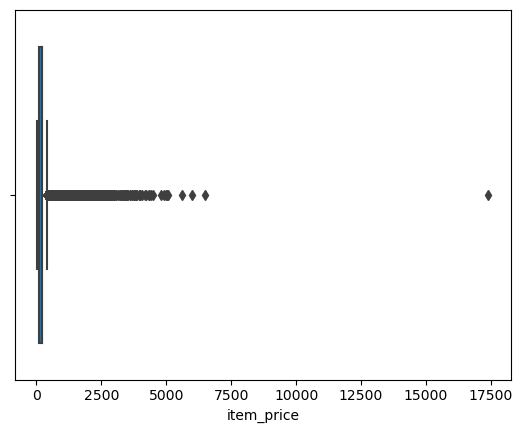

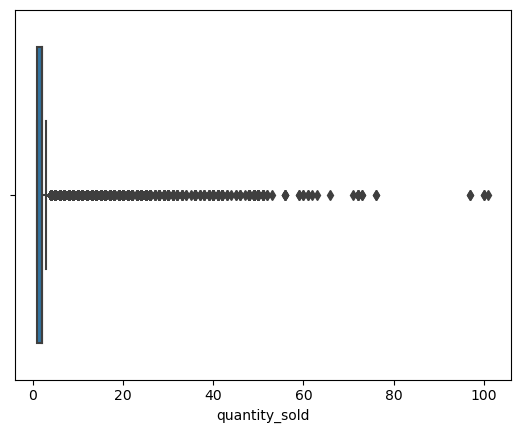

In [59]:
sns.boxplot(x='item_price', data=df)
plt.show()

sns.boxplot(x='quantity_sold', data=df)
plt.show()

In [60]:
df2 = df[df['item_price']>=2000]
df2

item_description          transaction_date  shop_id  \
2762       STRAWBERRY MILK 180ML  2021-12-08T00:00:00.000Z  SHOP070   
6609             TONIC PET 500ML  2021-12-03T00:00:00.000Z  SHOP046   
10831          GINGER BEER 500ML  2021-10-16T00:00:00.000Z  SHOP126   
10836   DRY GINGER ALE PET 500ML  2021-10-16T00:00:00.000Z  SHOP126   
11271       FIT O MIXED FRUIT 1L  2021-10-16T00:00:00.000Z  SHOP111   
...                          ...                       ...      ...   
467944                       NaN  2021-10-31T00:00:00.000Z  SHOP054   
470159     STRAWBERRY MILK 180ML  2021-12-15T00:00:00.000Z  SHOP018   
470863                       NaN  2021-12-09T00:00:00.000Z  SHOP022   
473033                       NaN  2021-12-14T00:00:00.000Z  SHOP118   
473718           FIT O ORANGE 1L  2021-12-12T00:00:00.000Z  SHOP018   

        item_price  quantity_sold  
2762          2100             30  
6609          2720             17  
10831         2500             26  
10836         2400             15  
11271         2700             11  
...            ...            ...  
467944        2100             30  
470159        2450             36  
470863        2450             36  
473033        2800             40  
473718        2320              8  

[265 rows x 5 columns]

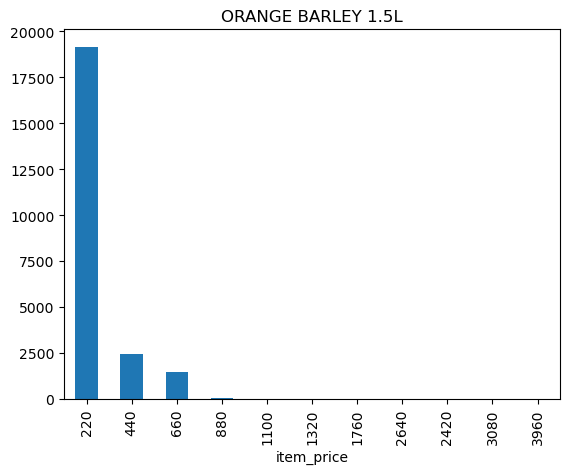

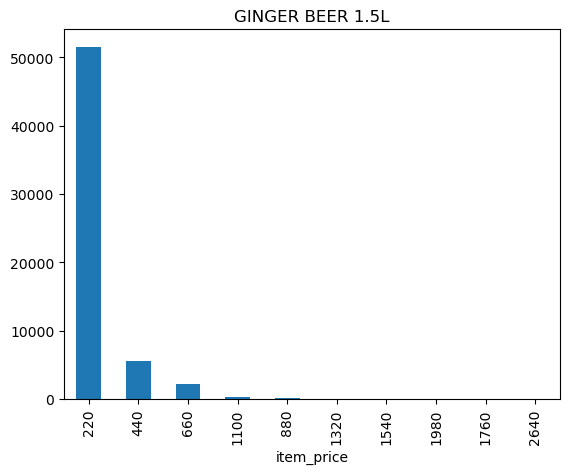

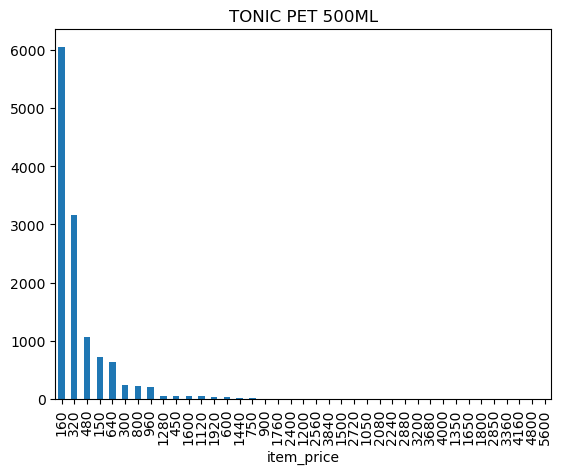

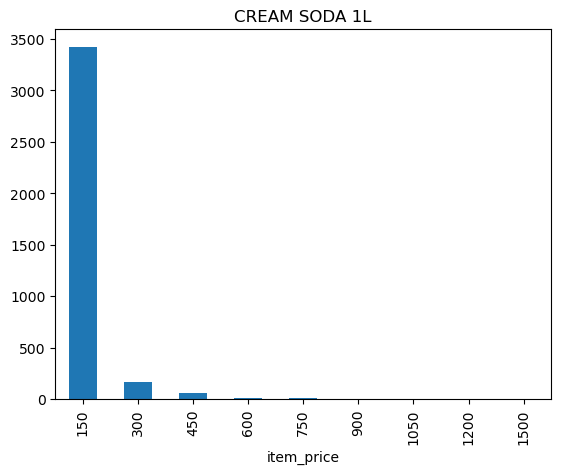

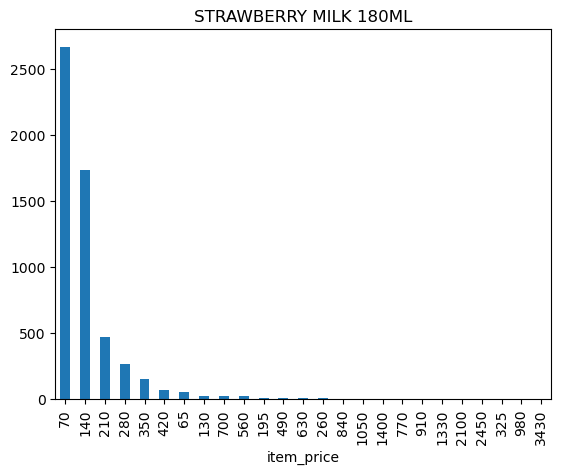

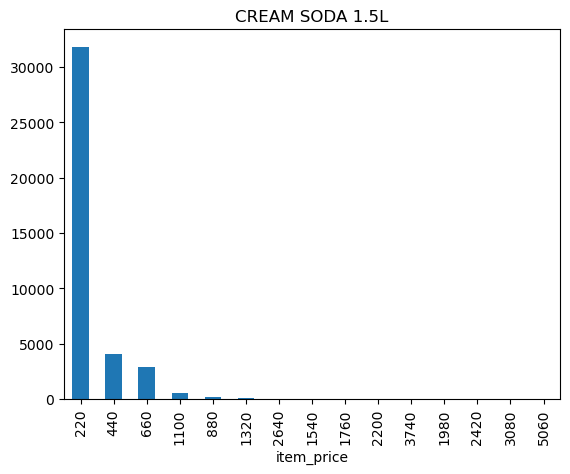

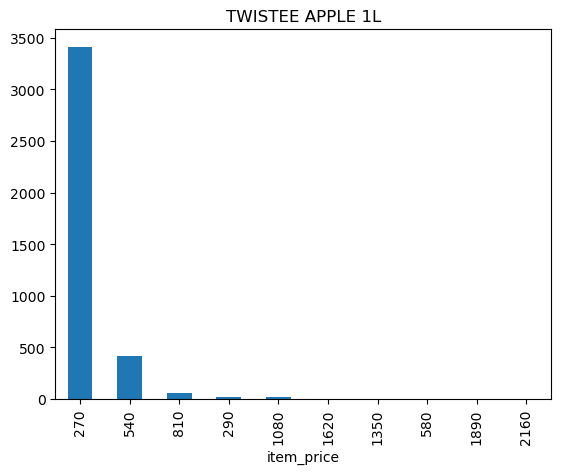

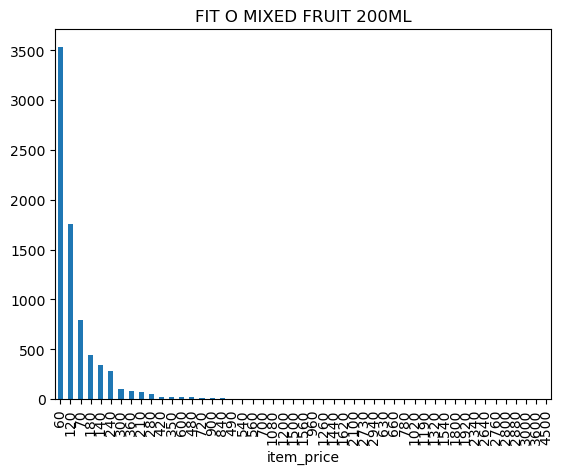

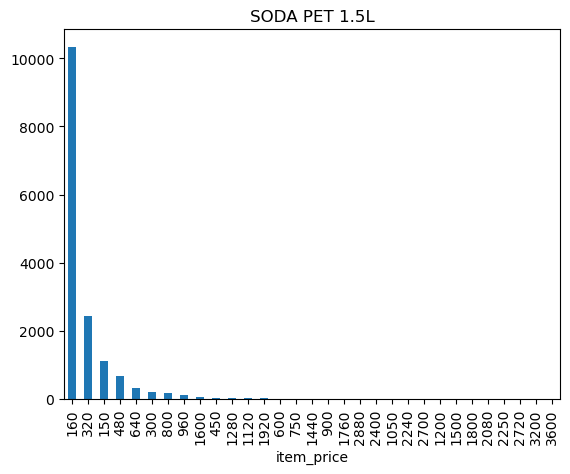

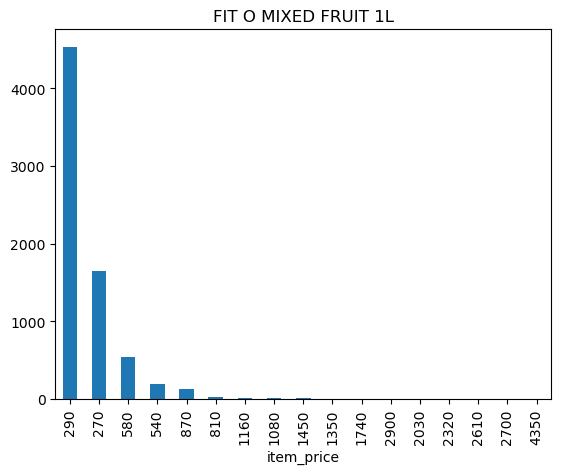

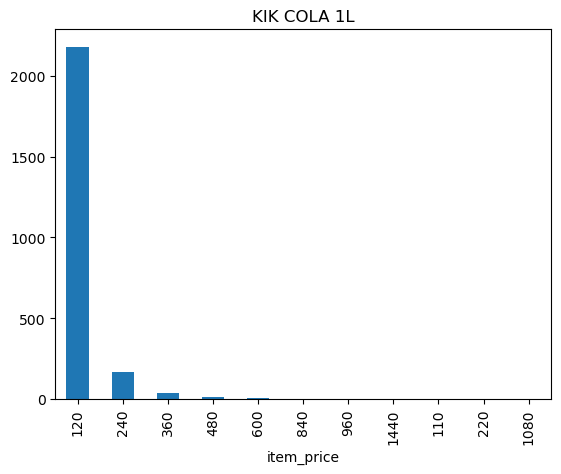

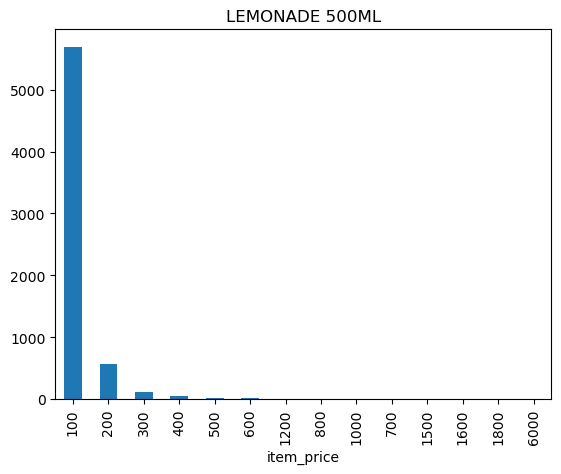

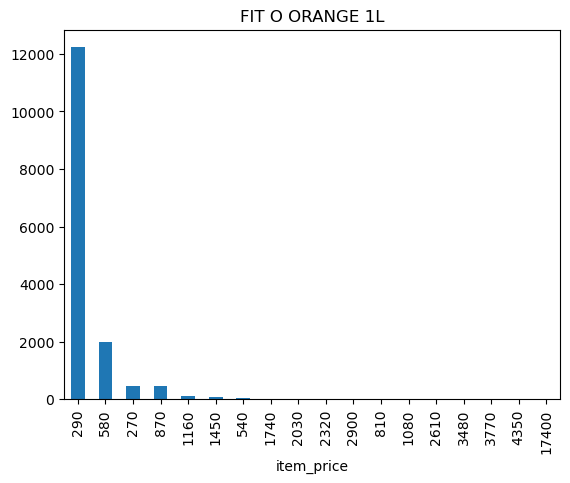

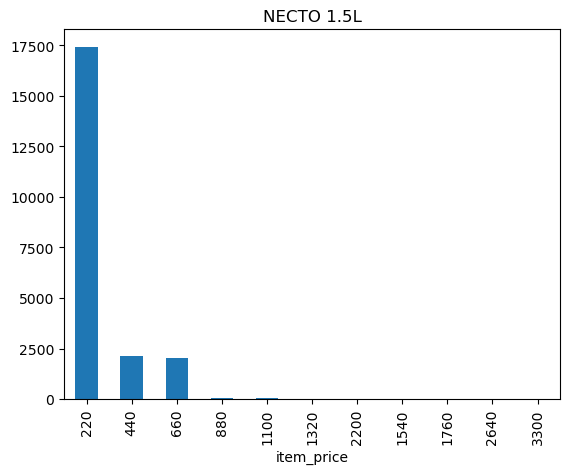

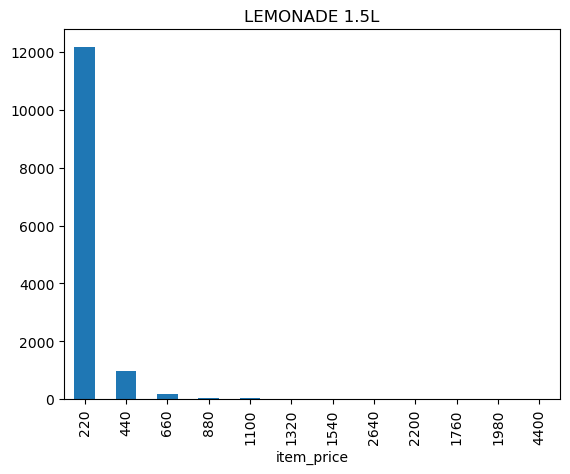

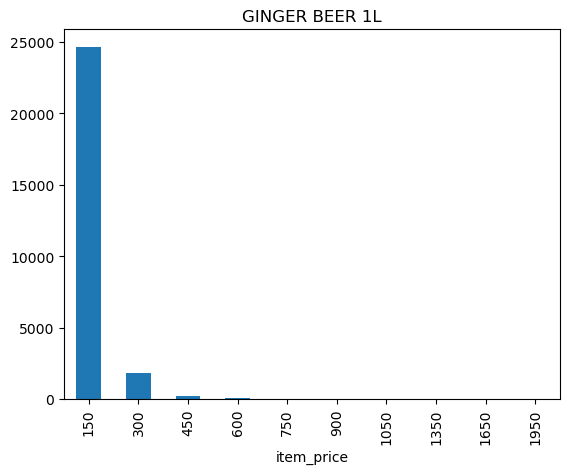

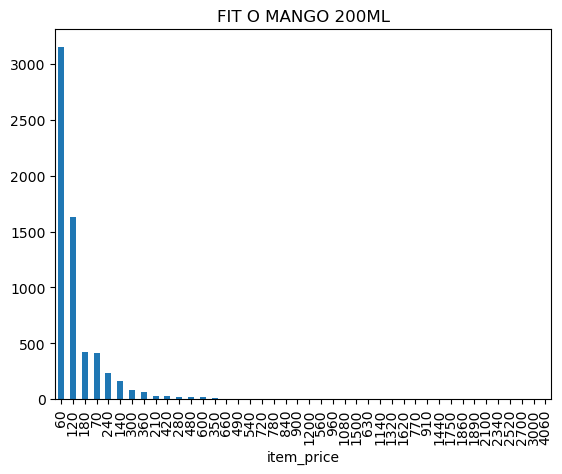

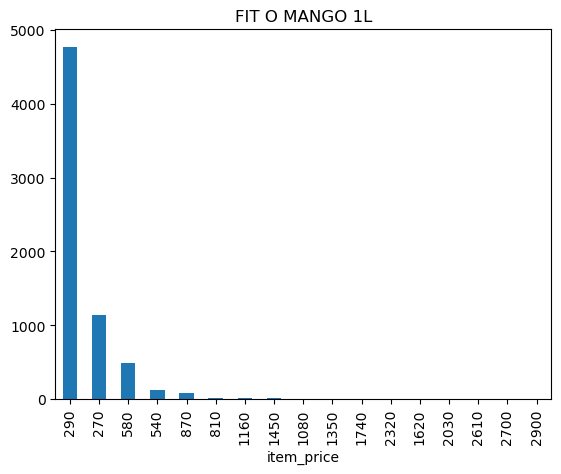

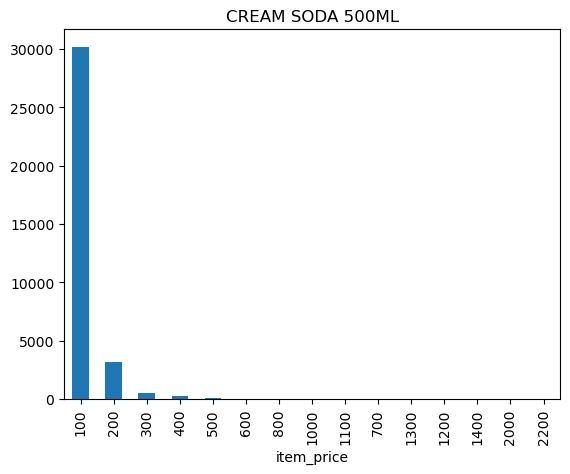

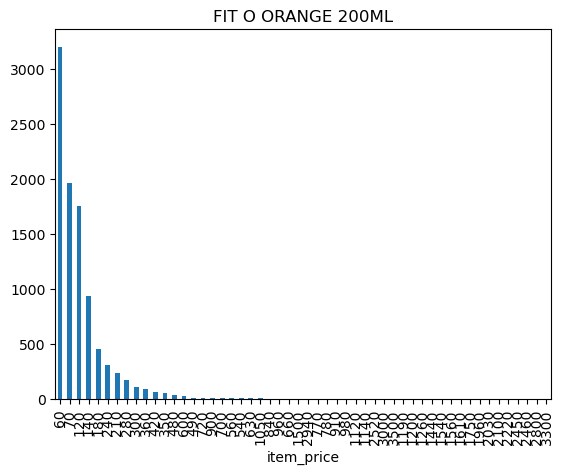

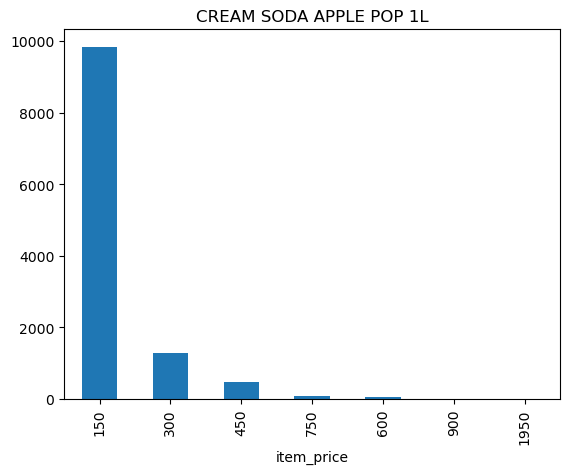

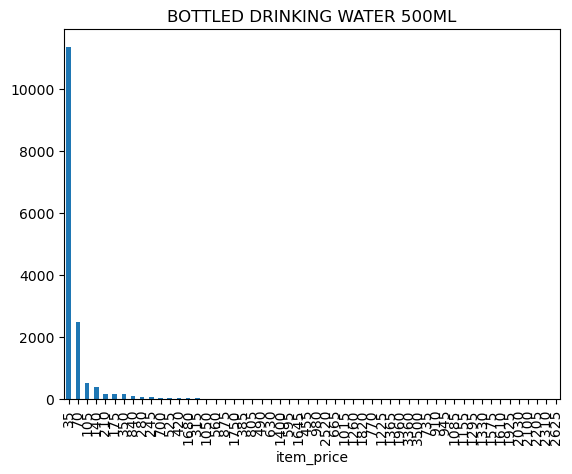

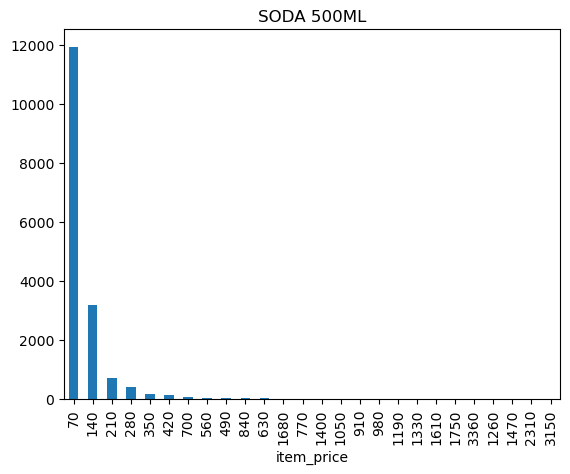

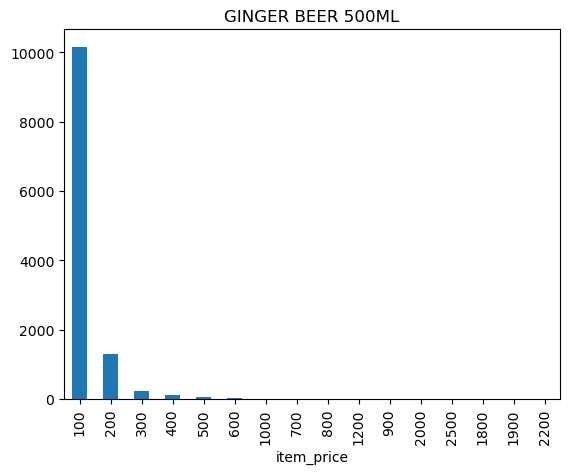

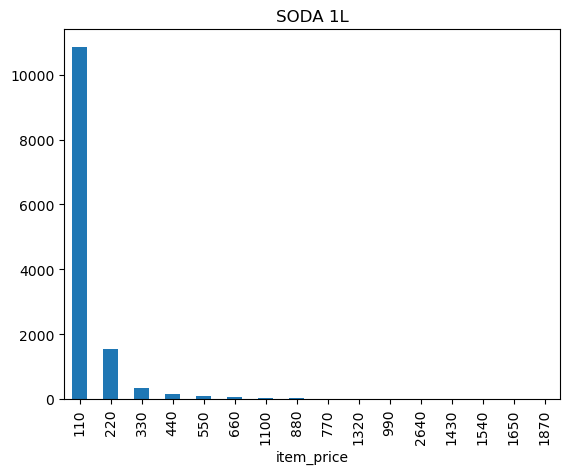

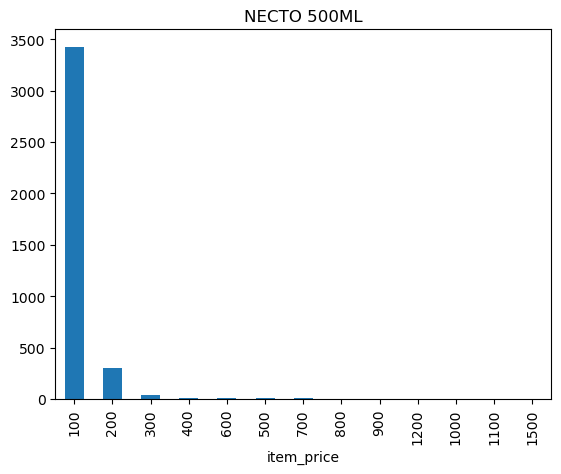

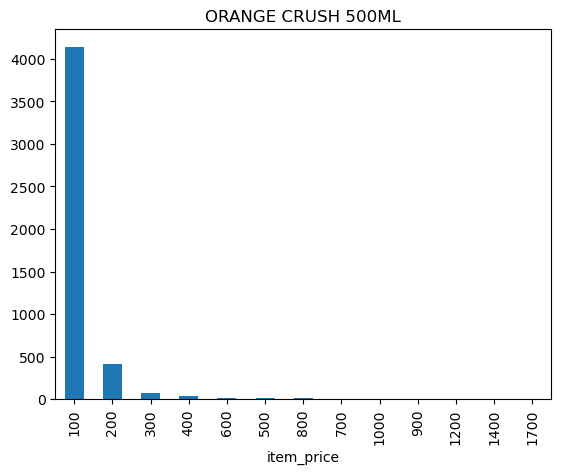

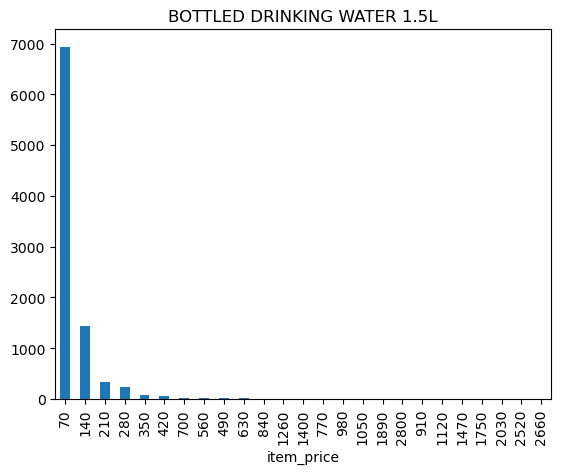

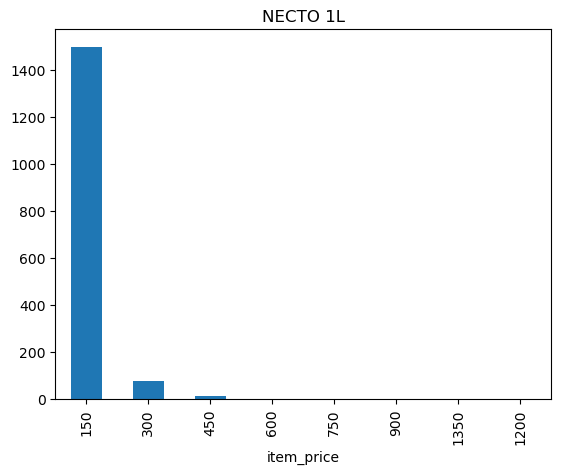

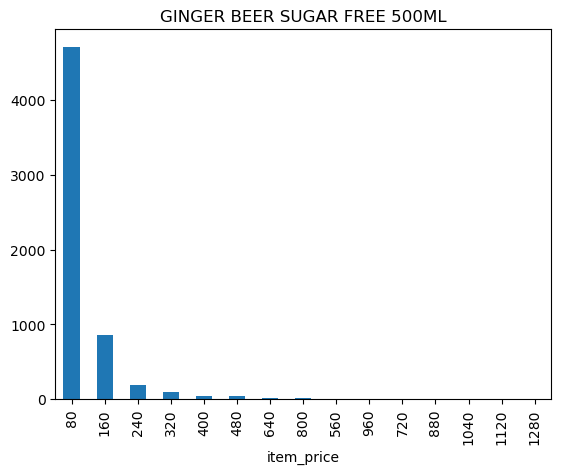

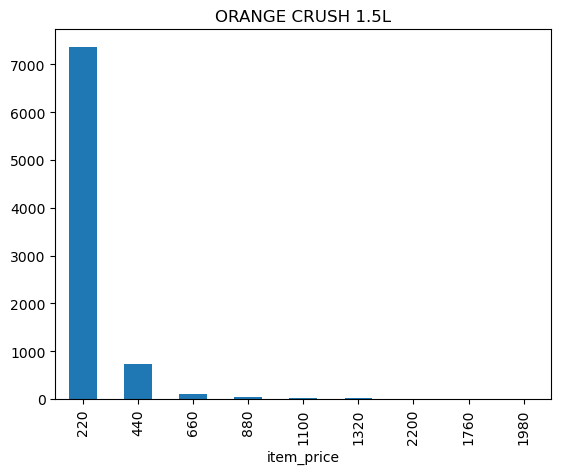

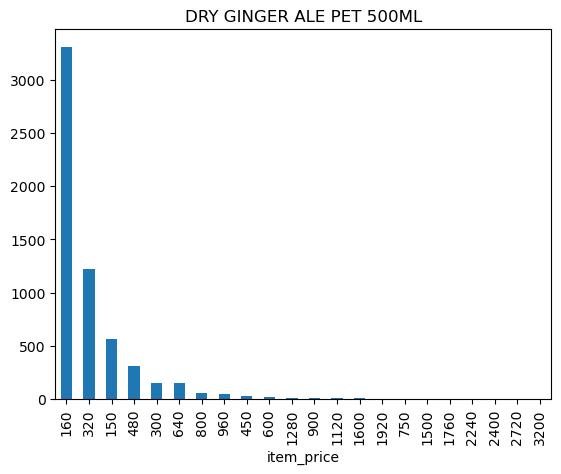

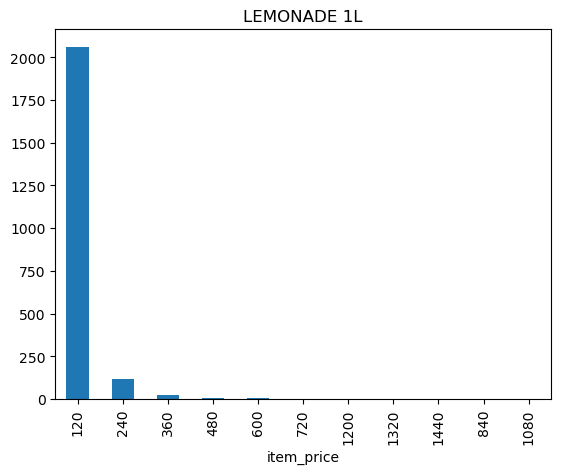

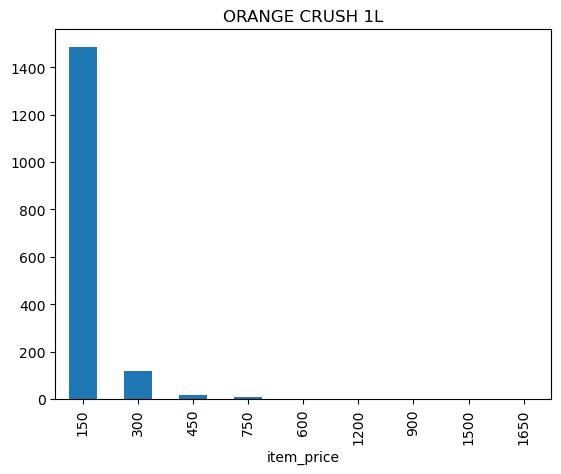

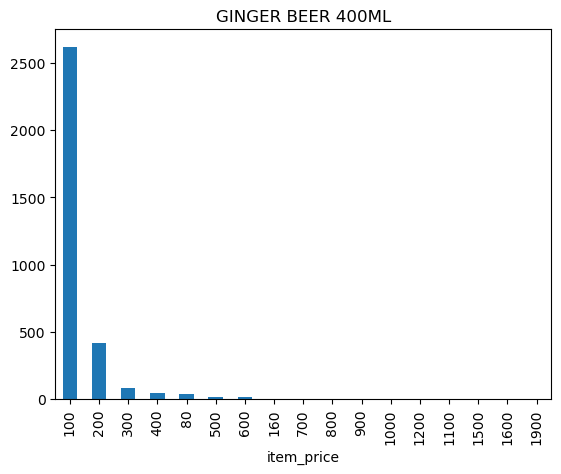

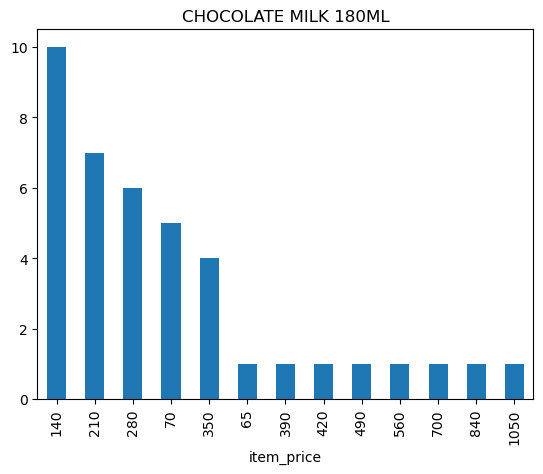

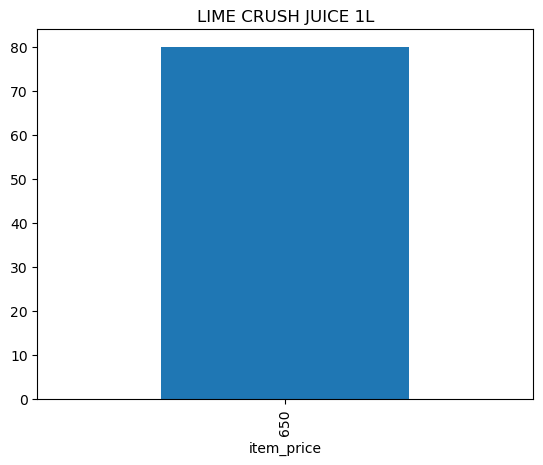

In [61]:
# Filter out any rows with null values in the "item_description" or "item_price" columns
df2 = df.dropna(subset=['item_description', 'item_price'])

# Filter out any non-numeric values in the "item_price" column
# df2 = df2[pd.to_numeric(df2['item_price'], errors='coerce').notnull()]

# Convert the "item_price" column to a numeric data type
# df2['item_price'] = pd.to_numeric(df2['item_price'])

# Group the DataFrame by the "item_description" column and calculate the count of each price using the groupby and value_counts methods
counts = df2.groupby('item_description')['item_price'].value_counts()

# Iterate over the unique items in the DataFrame and plot a bar graph for each item using the plot method
for item in df2['item_description'].unique():
    if item is not None:
        counts[item].plot(kind='bar', title=item)
        plt.show()

In [62]:
def weekly_prices(items):
  for item in items:
    df_item = df[df['item_description'] == item]
    df_item['transaction_date'] = pd.to_datetime(df_item['transaction_date'])

    date_range = pd.date_range(start='2021-10-15', end='2021-12-15', freq='W')

    # create a new column with the week number of each row
    df_item['week_number'] = df_item['transaction_date'].dt.week

    # group the dataframe by shop and week number, and sum the item prices
    grouped = df_item.groupby(['week_number'])['item_price'].value_counts().unstack()

    # normalize the dataframe
    grouped = grouped.div(grouped.sum(axis=1), axis=0)

    # create a stacked bar plot
    ax = grouped.plot(kind='bar', stacked=True,figsize=(50,10))

    # set the x-label and y-label
    ax.set_xlabel('Week')
    ax.set_ylabel('Item Price')
    ax.set_title(item)

    # set the tick labels of the x-axis to the week number of each row
    ax.set_xticklabels(grouped.index, rotation=90)

    # show the plot
    plt.show()

In [63]:
def item_count_prices(items):
  for item in items:
    df_item = df[df['item_description'] == item]

    # group the dataframe by shop and week number, and sum the item prices
    grouped = df_item.groupby(['quantity_sold'])['item_price'].value_counts().unstack()

    # normalize the dataframe
    grouped = grouped.div(grouped.sum(axis=1), axis=0)

    # create a stacked bar plot
    ax = grouped.plot(kind='bar', stacked=True,figsize=(50,10))

    # set the x-label and y-label
    ax.set_xlabel('quantity_sold')
    ax.set_ylabel('Item Price')
    ax.set_title(item)

    # set the tick labels of the x-axis to the week number of each row
    ax.set_xticklabels(grouped.index, rotation=90)

    # show the plot
    plt.show()

In [64]:
df['item_description'].unique()

array(['ORANGE BARLEY 1.5L', 'GINGER BEER 1.5L', 'TONIC PET 500ML',
       'CREAM SODA 1L', 'STRAWBERRY MILK 180ML', 'CREAM SODA 1.5L',
       'TWISTEE APPLE 1L', 'FIT O MIXED FRUIT 200ML', 'SODA PET 1.5L',
       'FIT O MIXED FRUIT 1L', 'KIK COLA 1L', 'LEMONADE 500ML',
       'FIT O ORANGE 1L', 'NECTO 1.5L', 'LEMONADE 1.5L', 'GINGER BEER 1L',
       'FIT O MANGO 200ML', 'FIT O MANGO 1L', 'CREAM SODA 500ML',
       'FIT O ORANGE 200ML', nan, 'CREAM SODA APPLE POP 1L',
       'BOTTLED DRINKING WATER 500ML', 'SODA 500ML', 'GINGER BEER 500ML',
       'SODA 1L', 'NECTO 500ML', 'ORANGE CRUSH 500ML',
       'BOTTLED DRINKING WATER 1.5L', 'NECTO 1L',
       'GINGER BEER SUGAR FREE 500ML', 'ORANGE CRUSH 1.5L',
       'DRY GINGER ALE PET 500ML', 'LEMONADE 1L', 'ORANGE CRUSH 1L',
       'GINGER BEER 400ML', 'CHOCOLATE MILK 180ML', 'LIME CRUSH JUICE 1L'],
      dtype=object)

week ekata anuwa price eka wenas wenawada nadda kiyala, and discount check

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


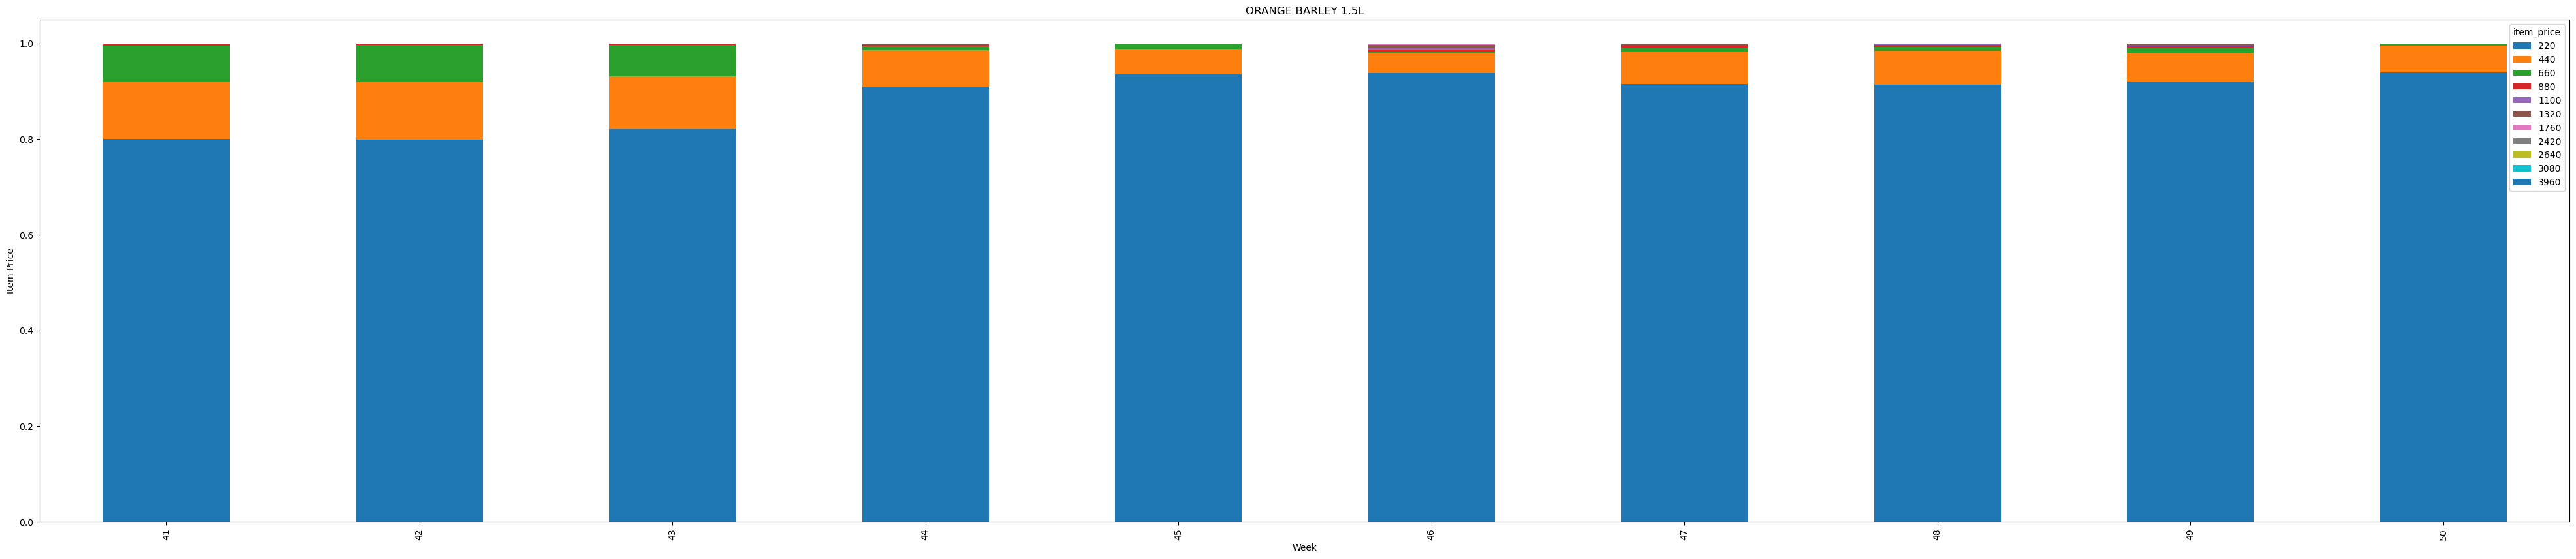

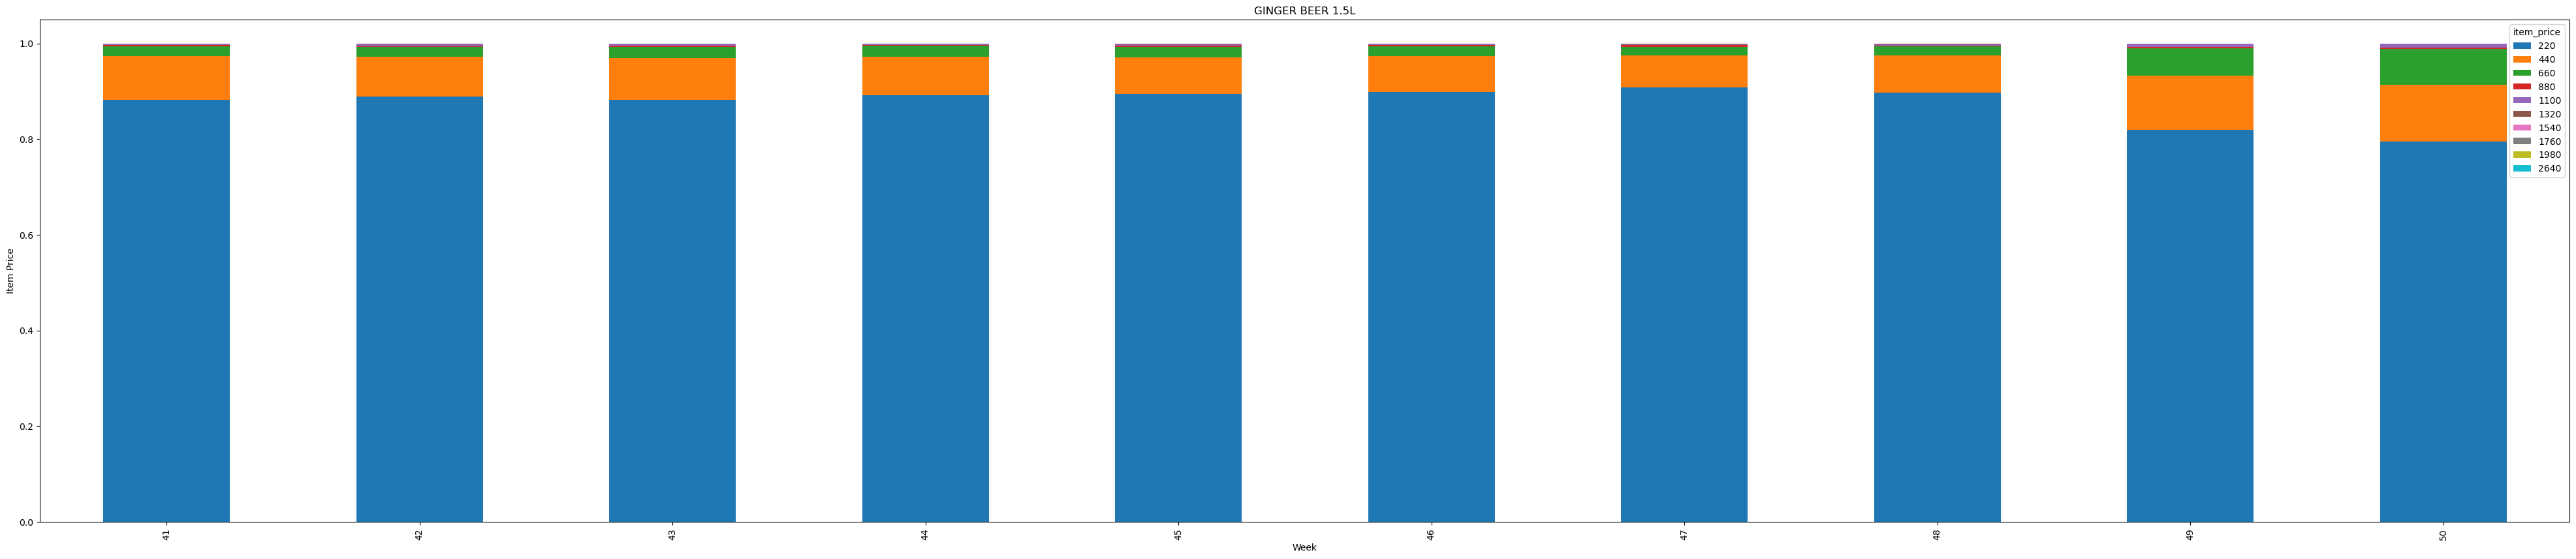

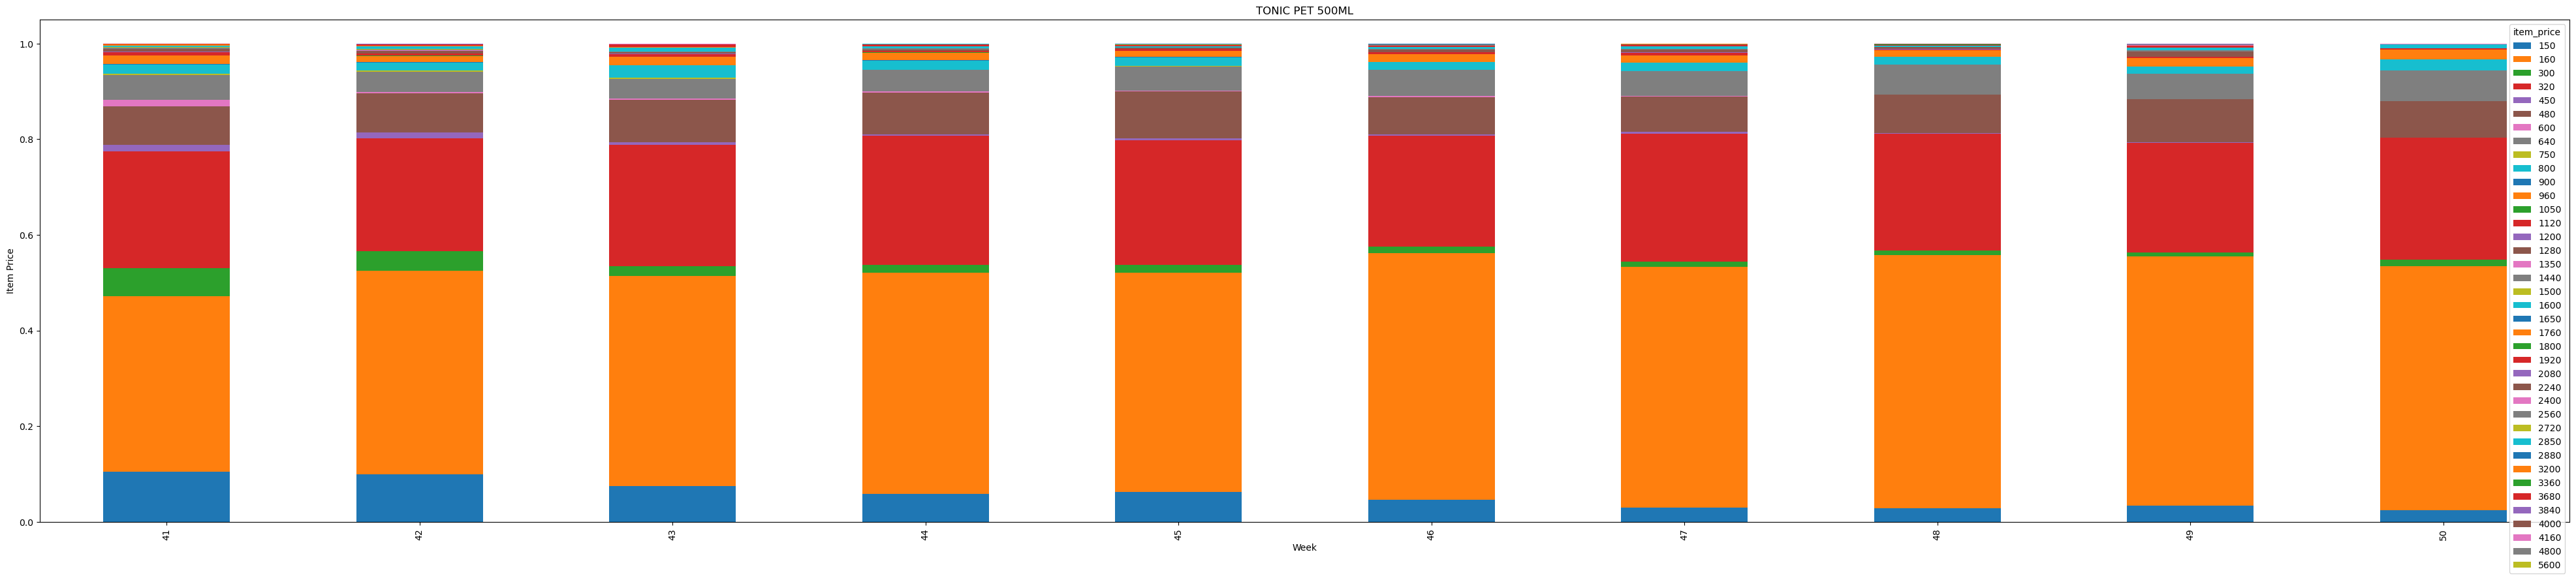

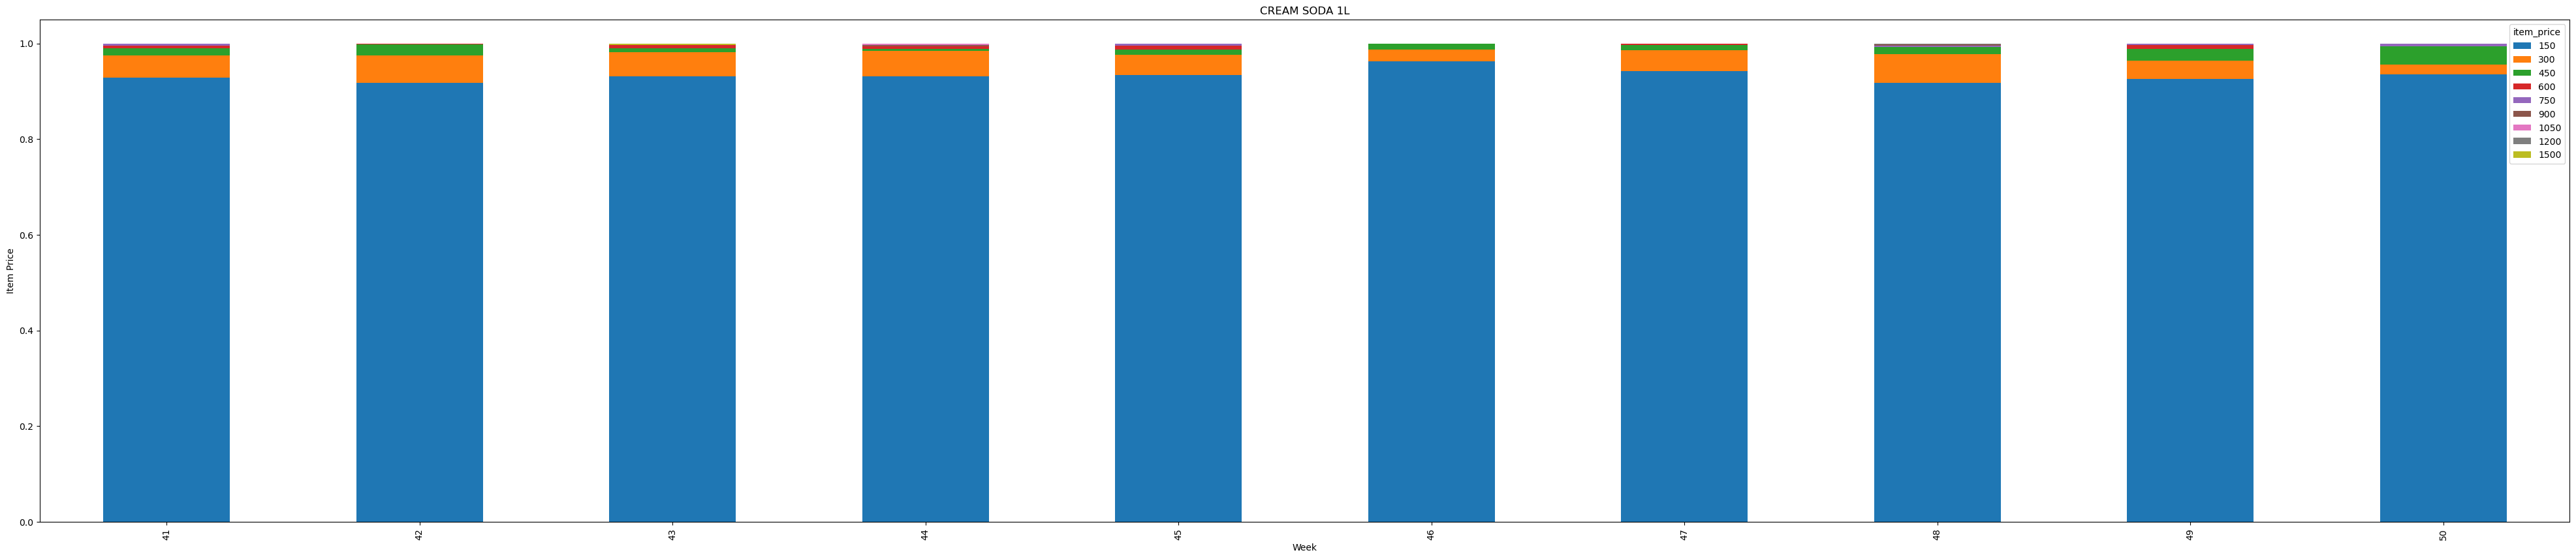

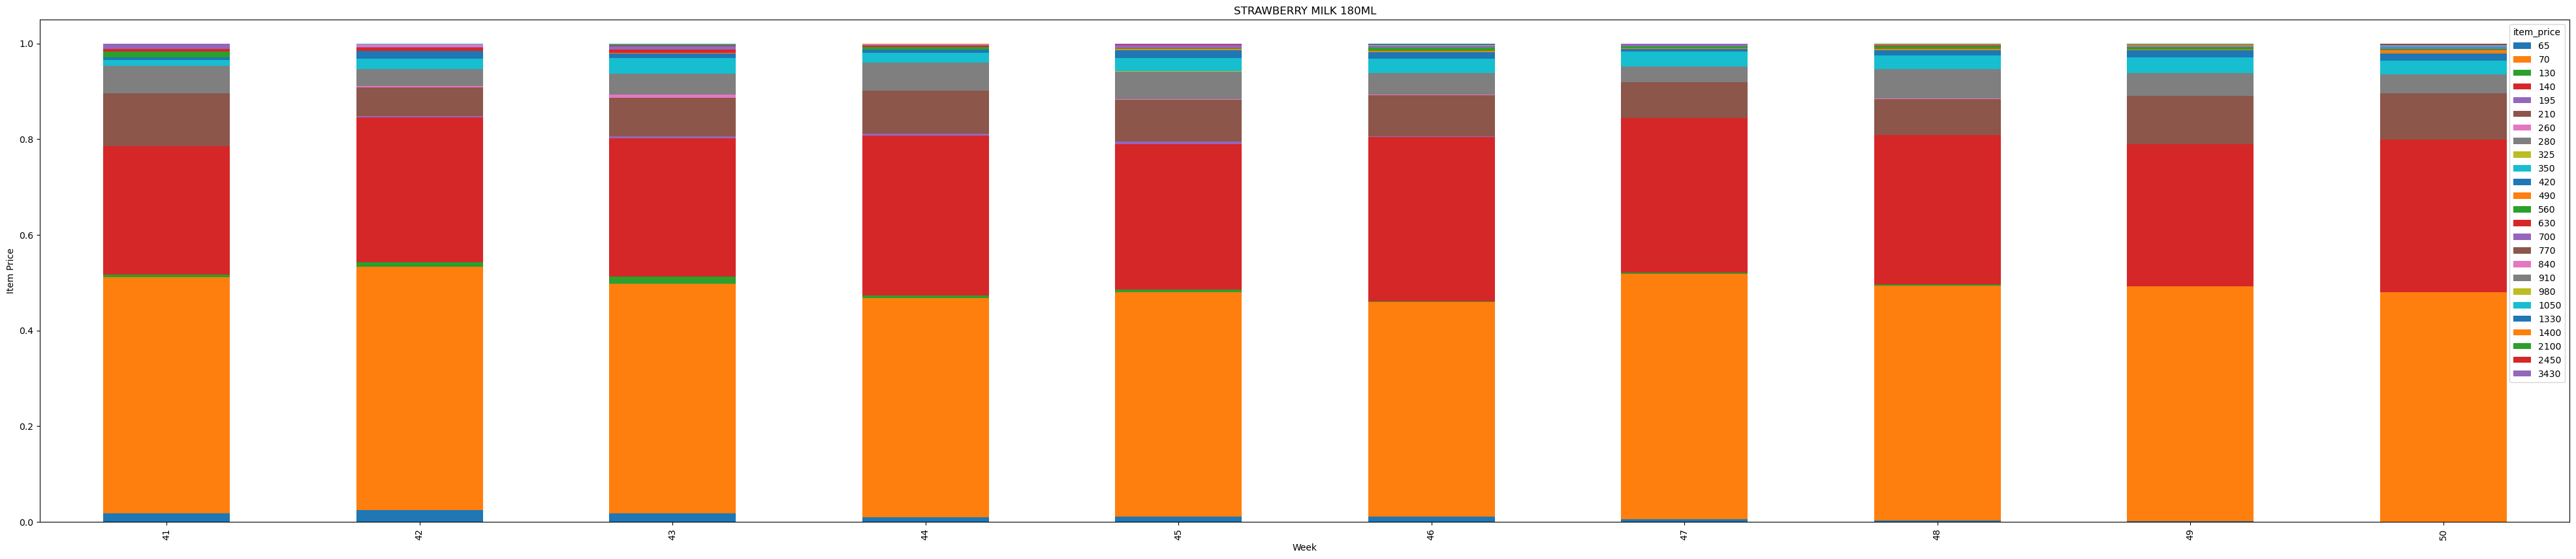

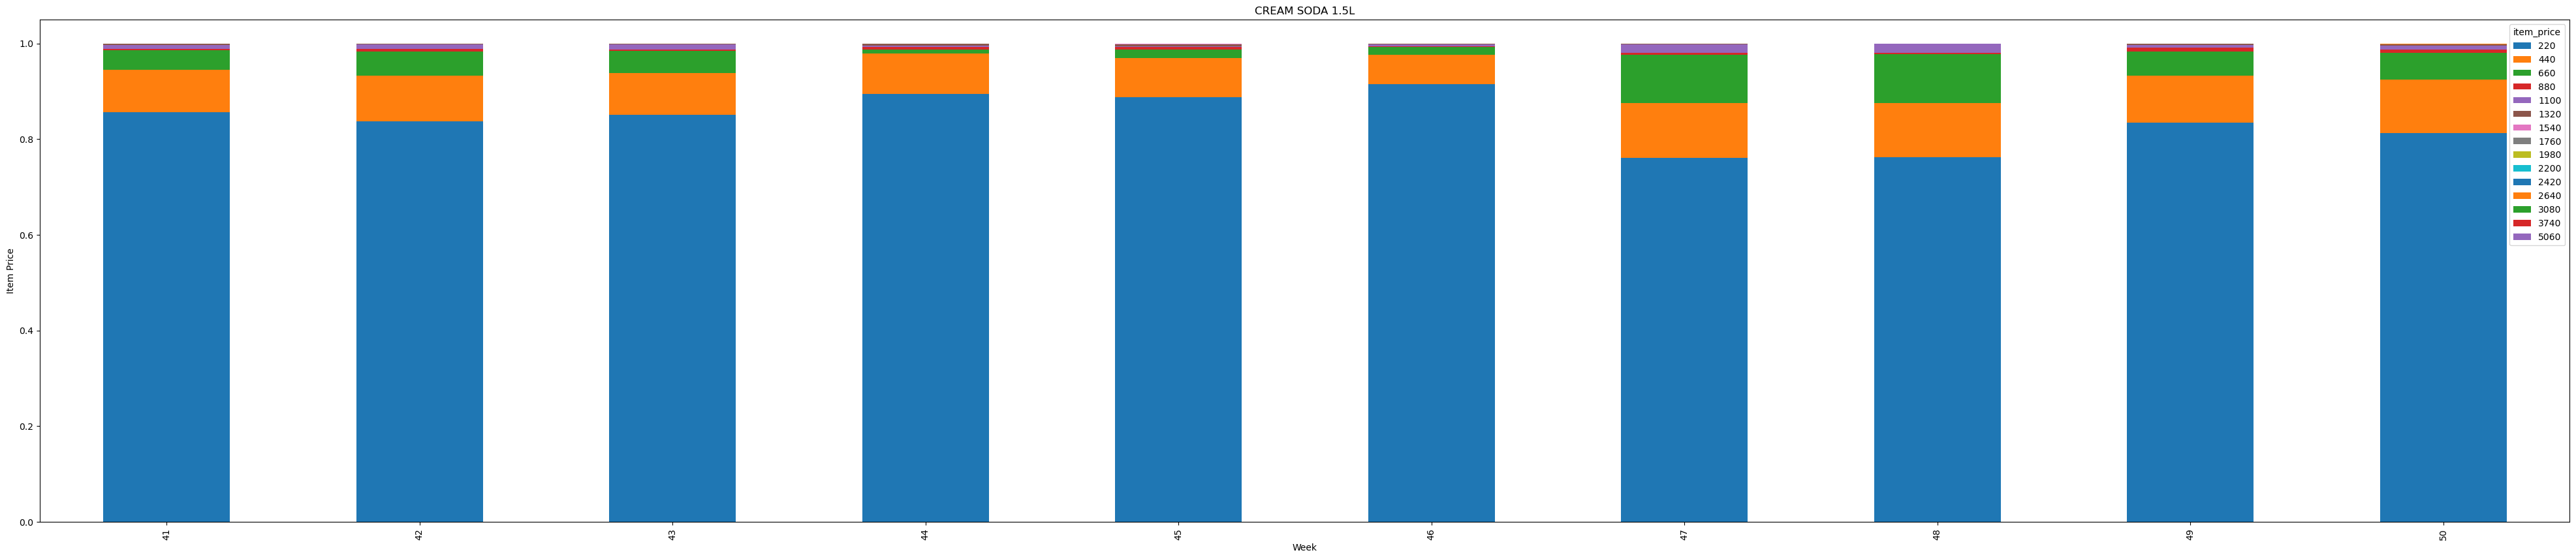

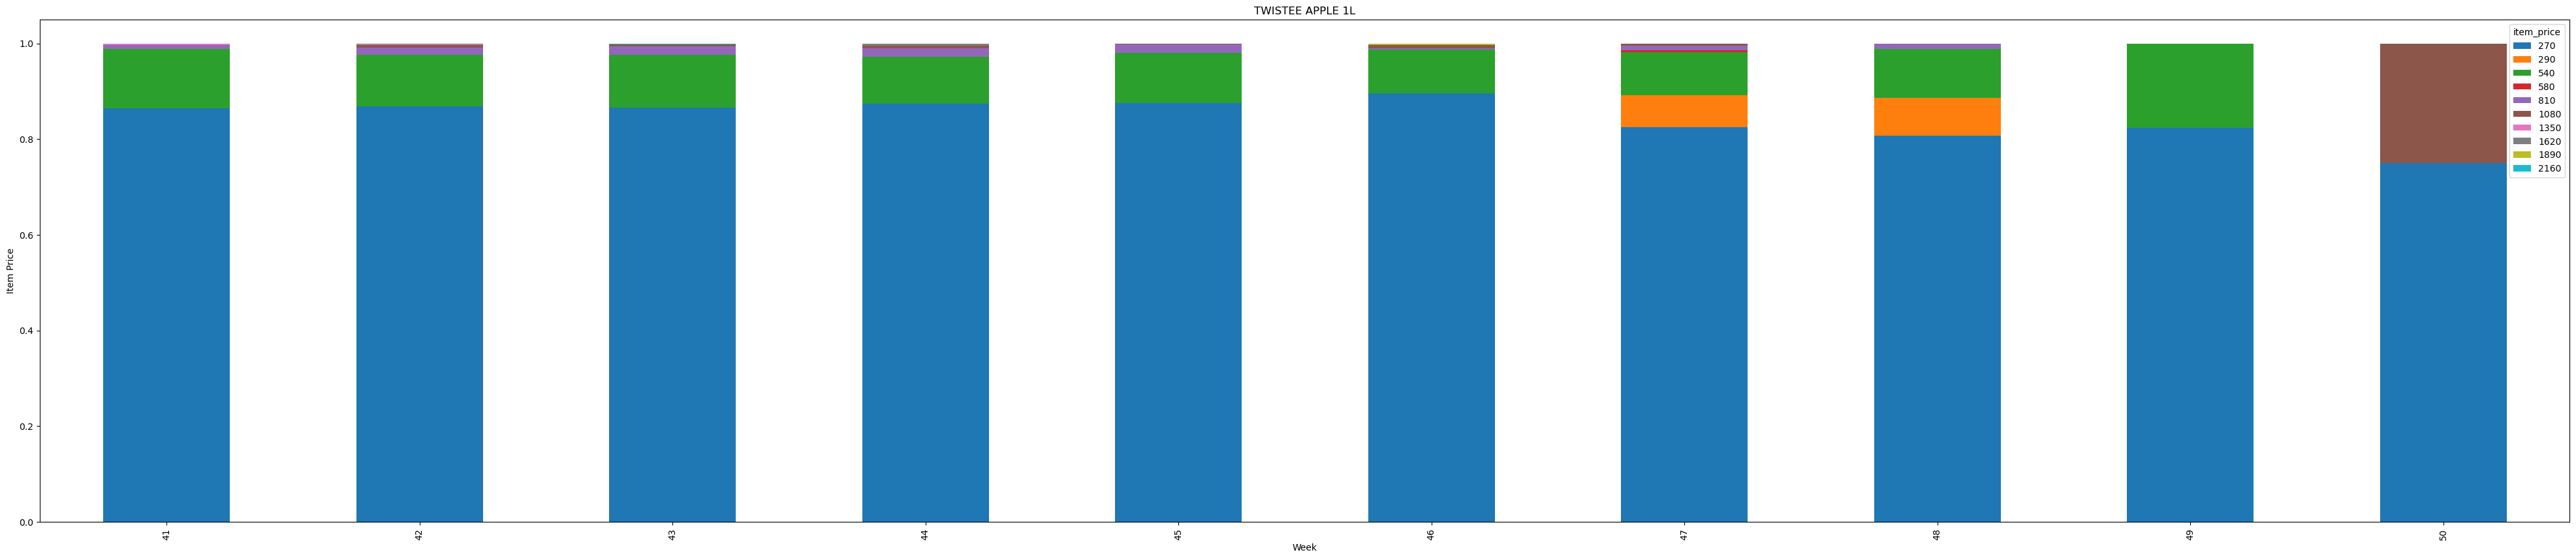

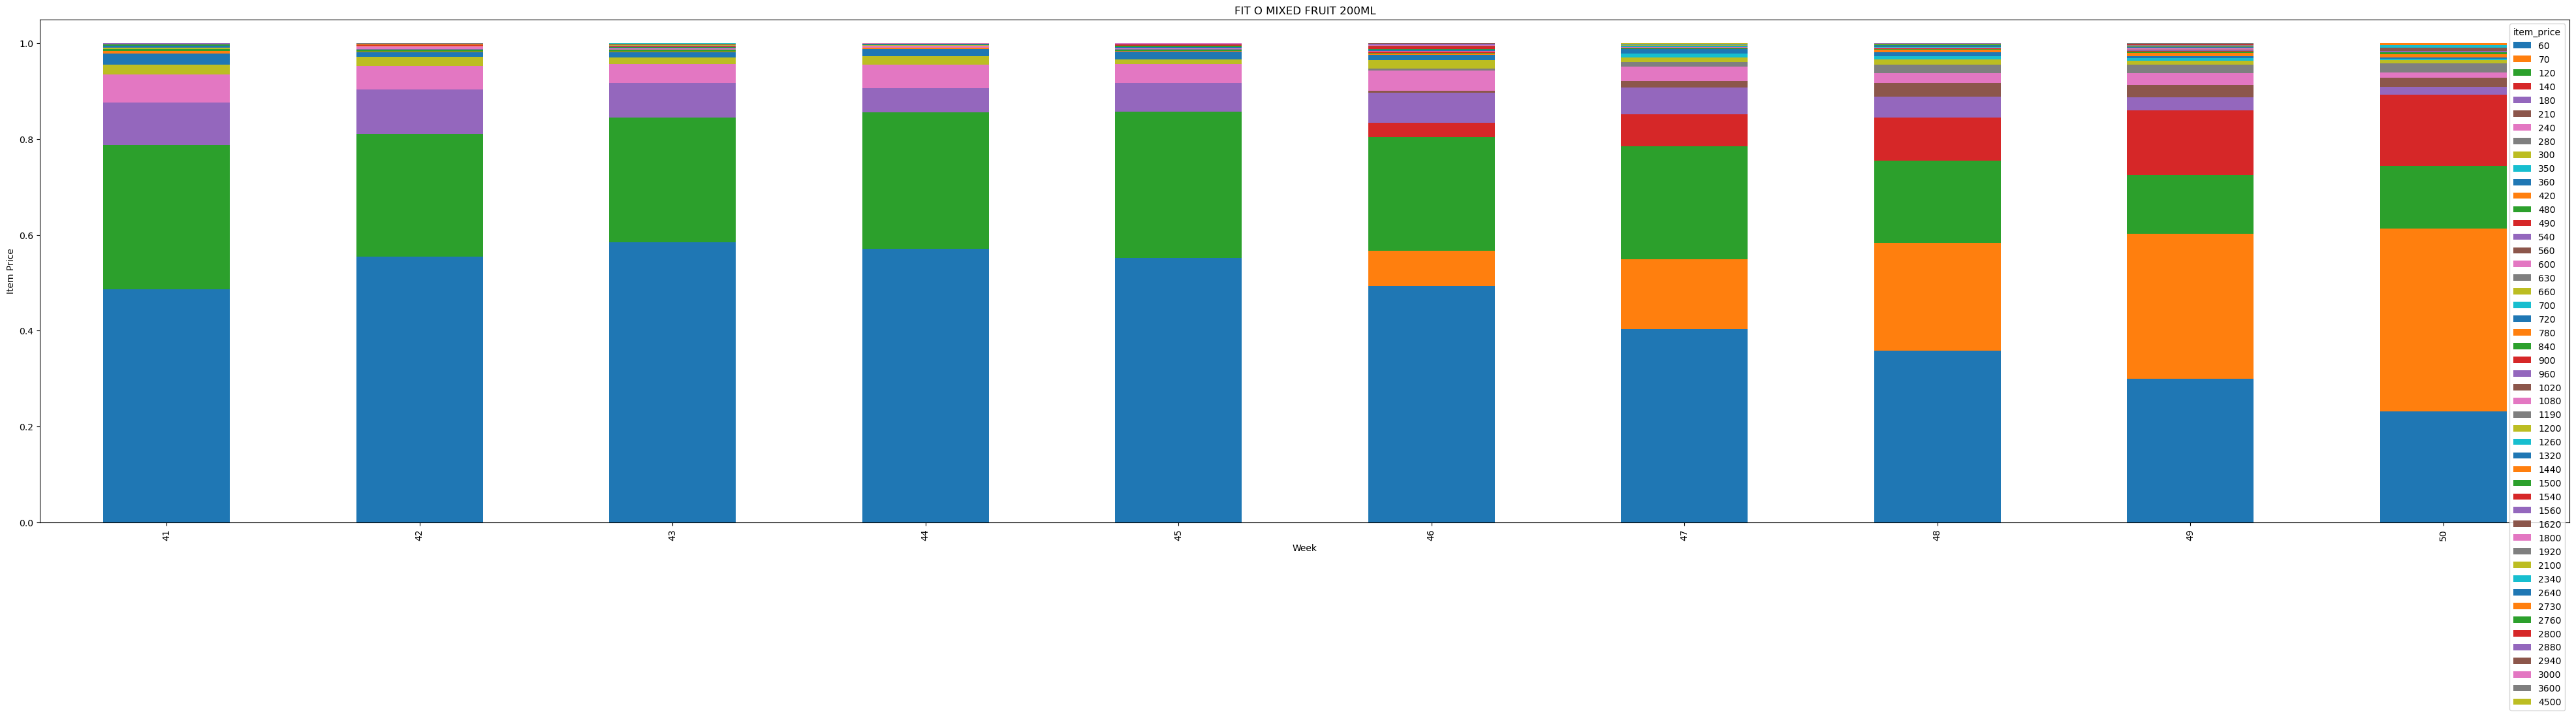

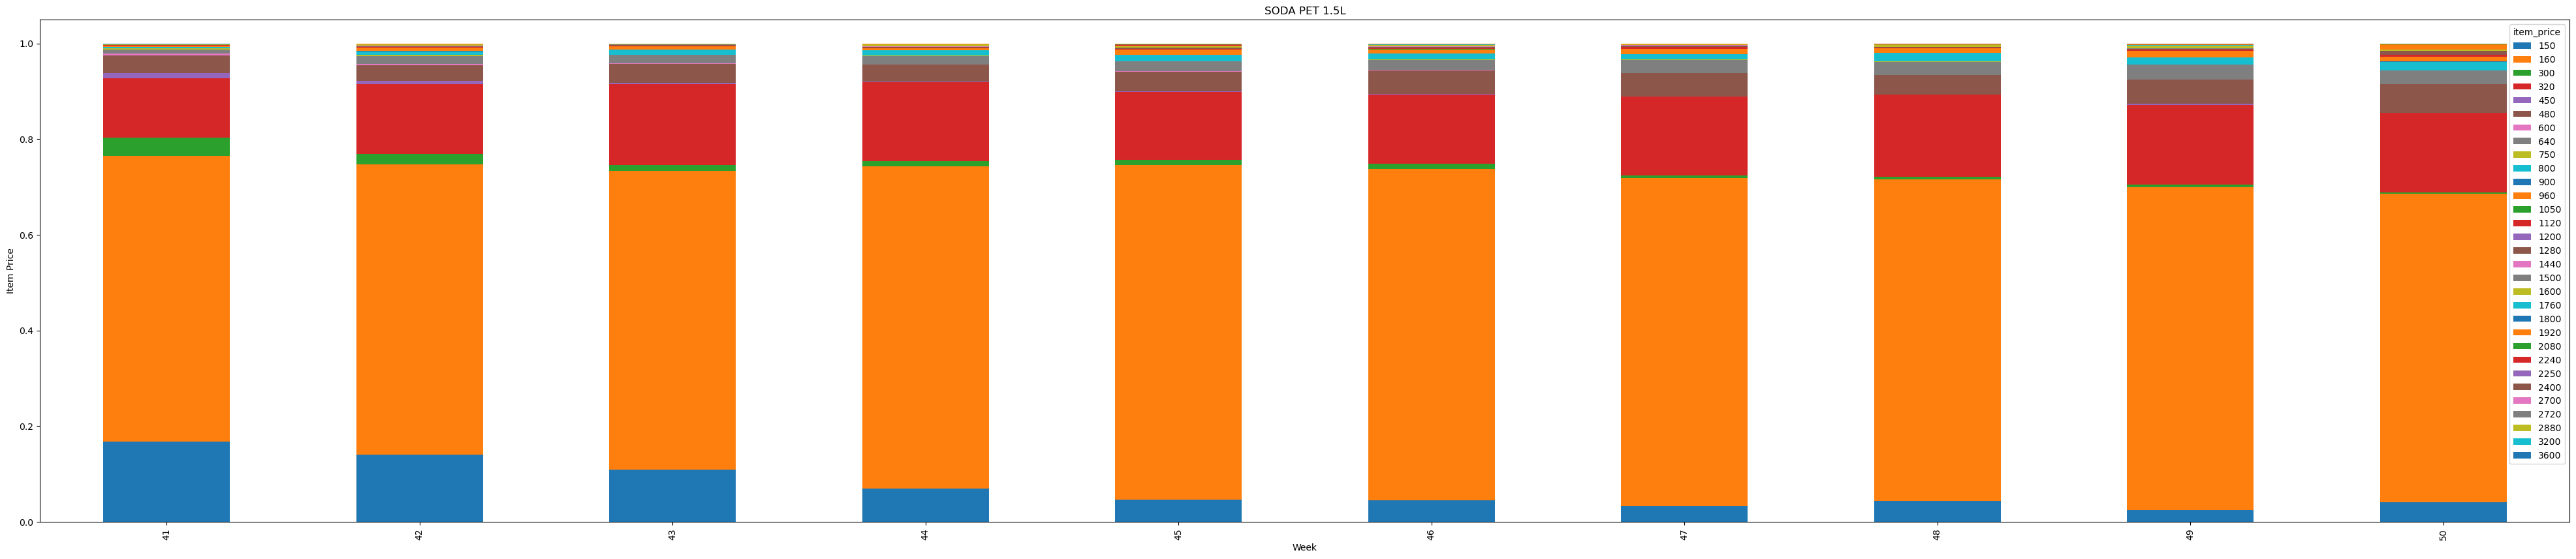

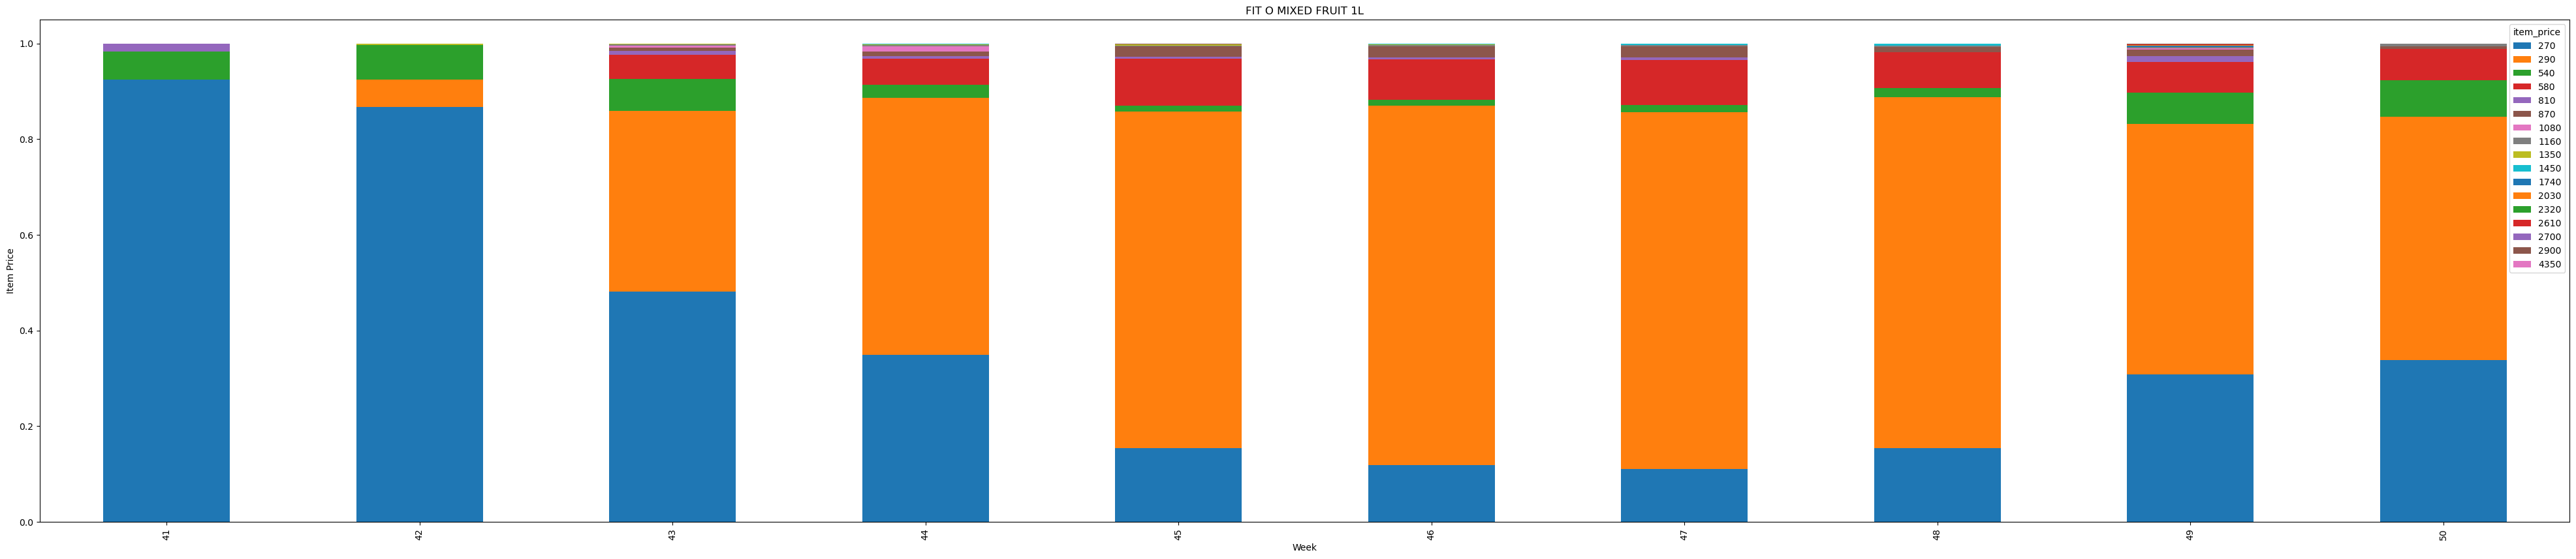

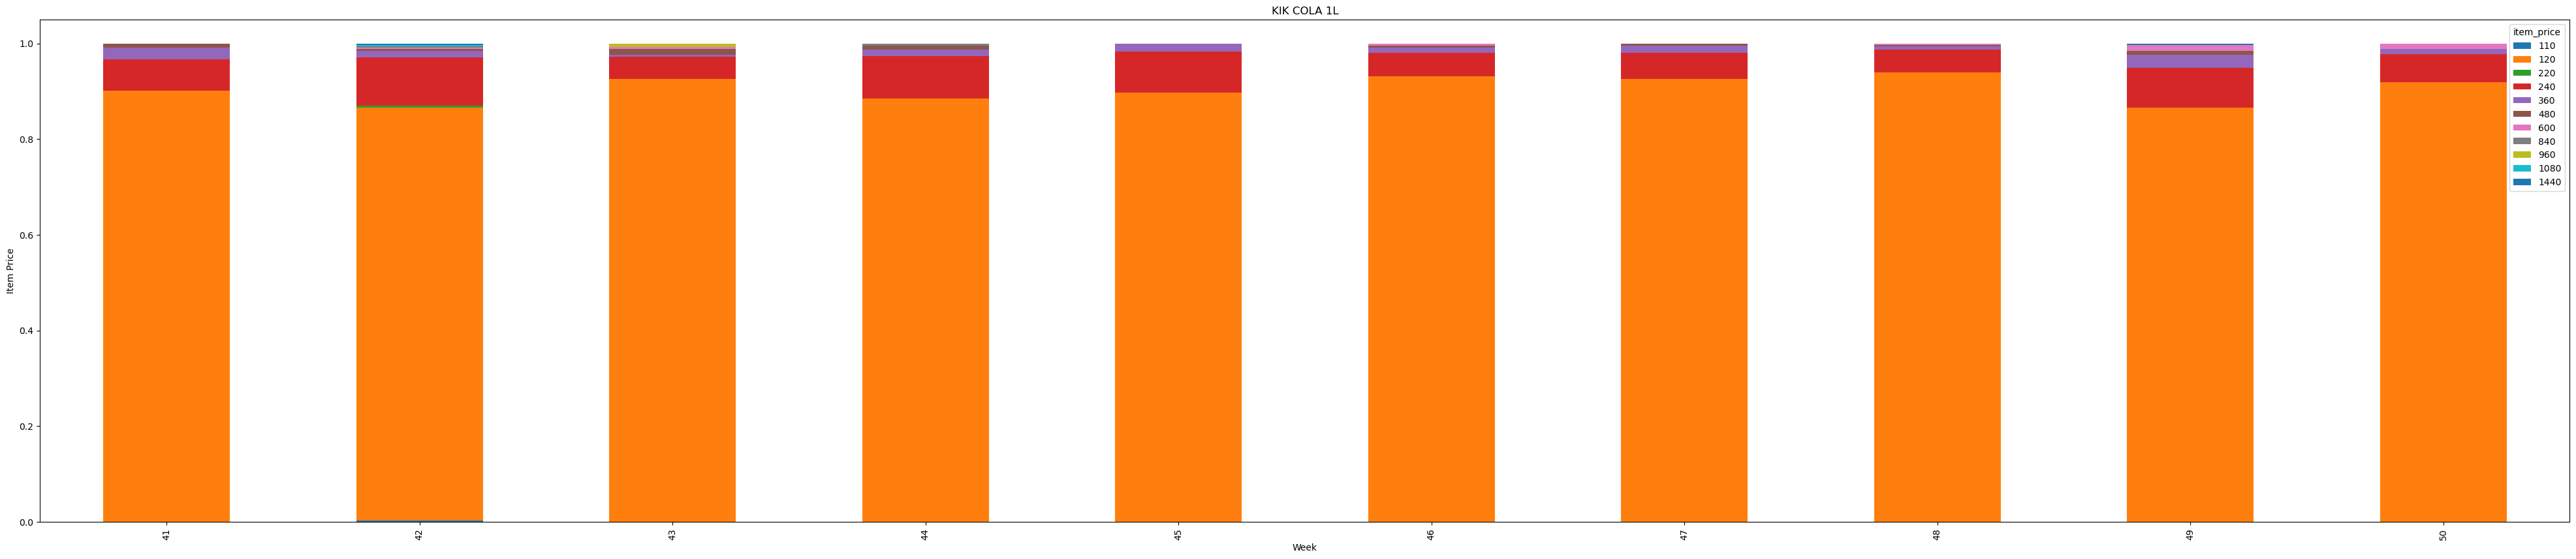

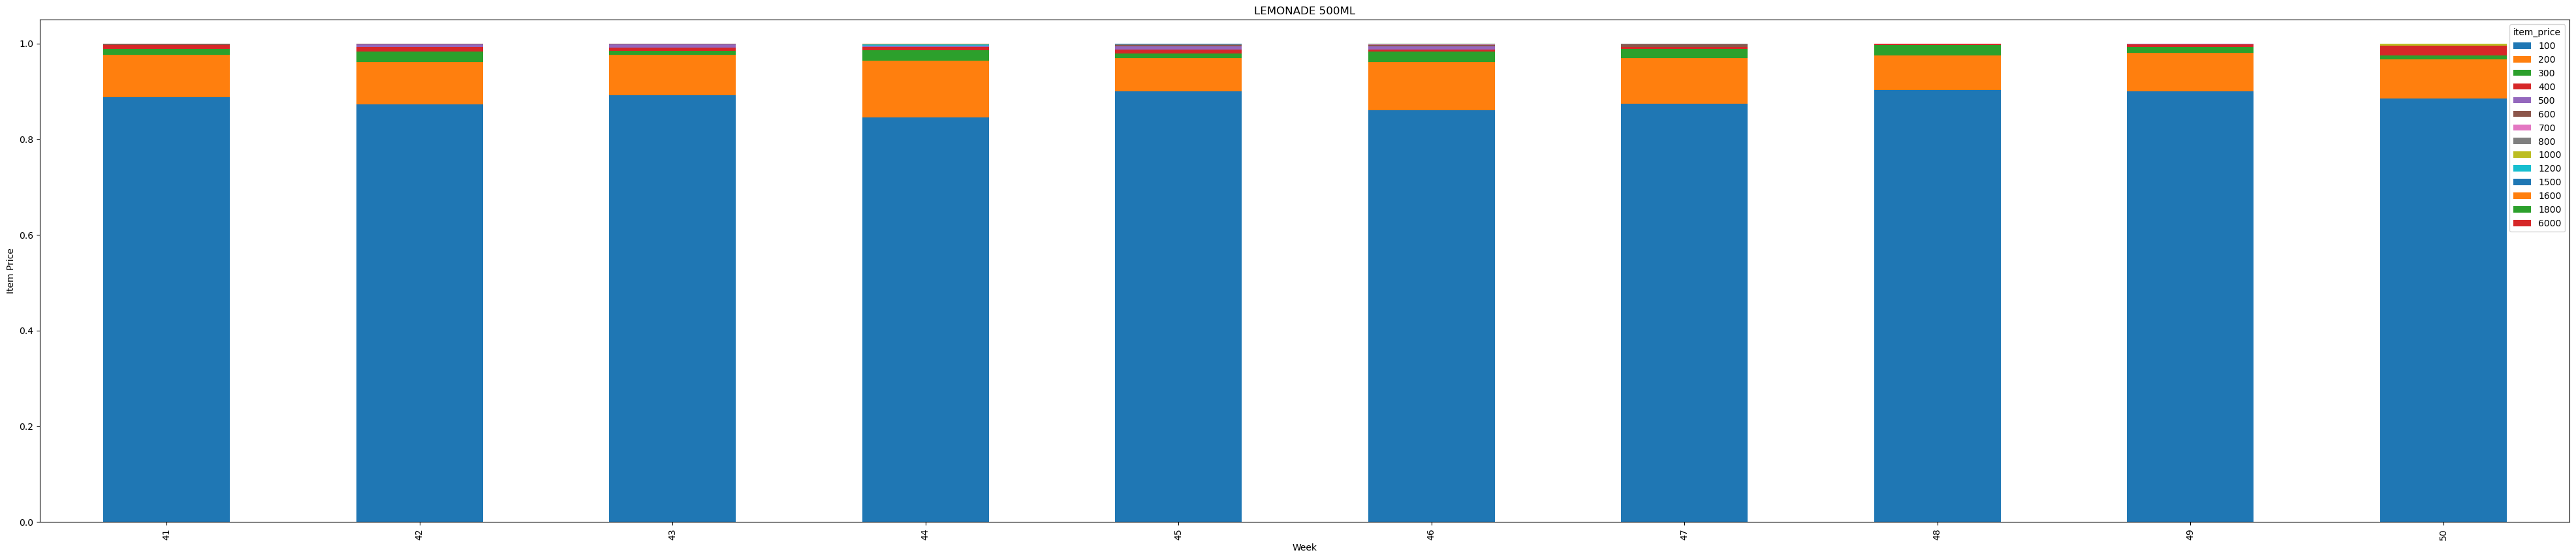

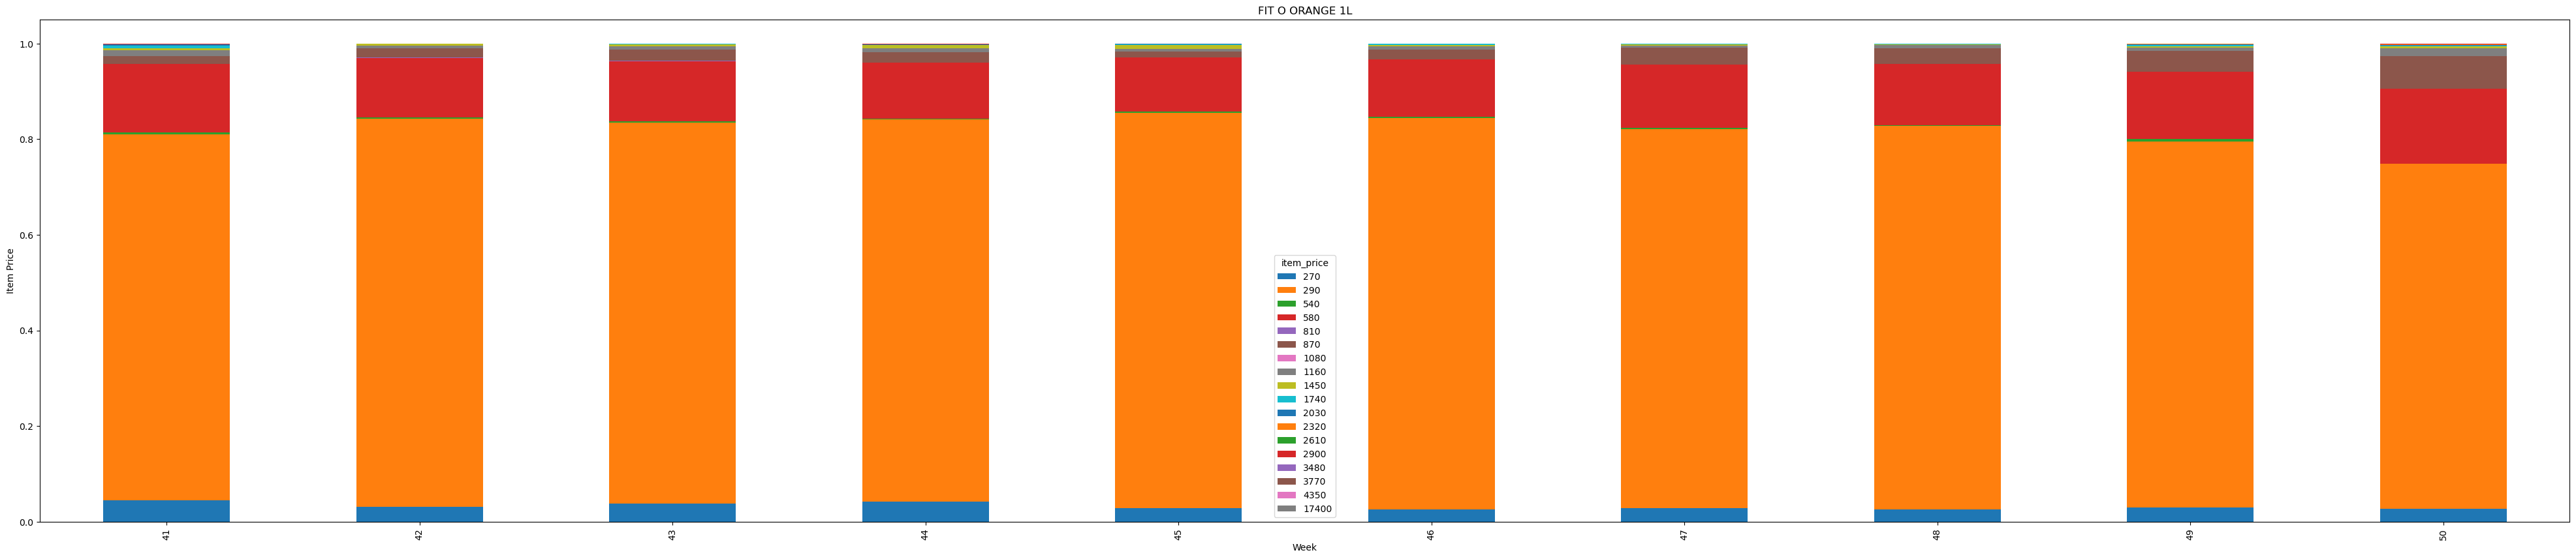

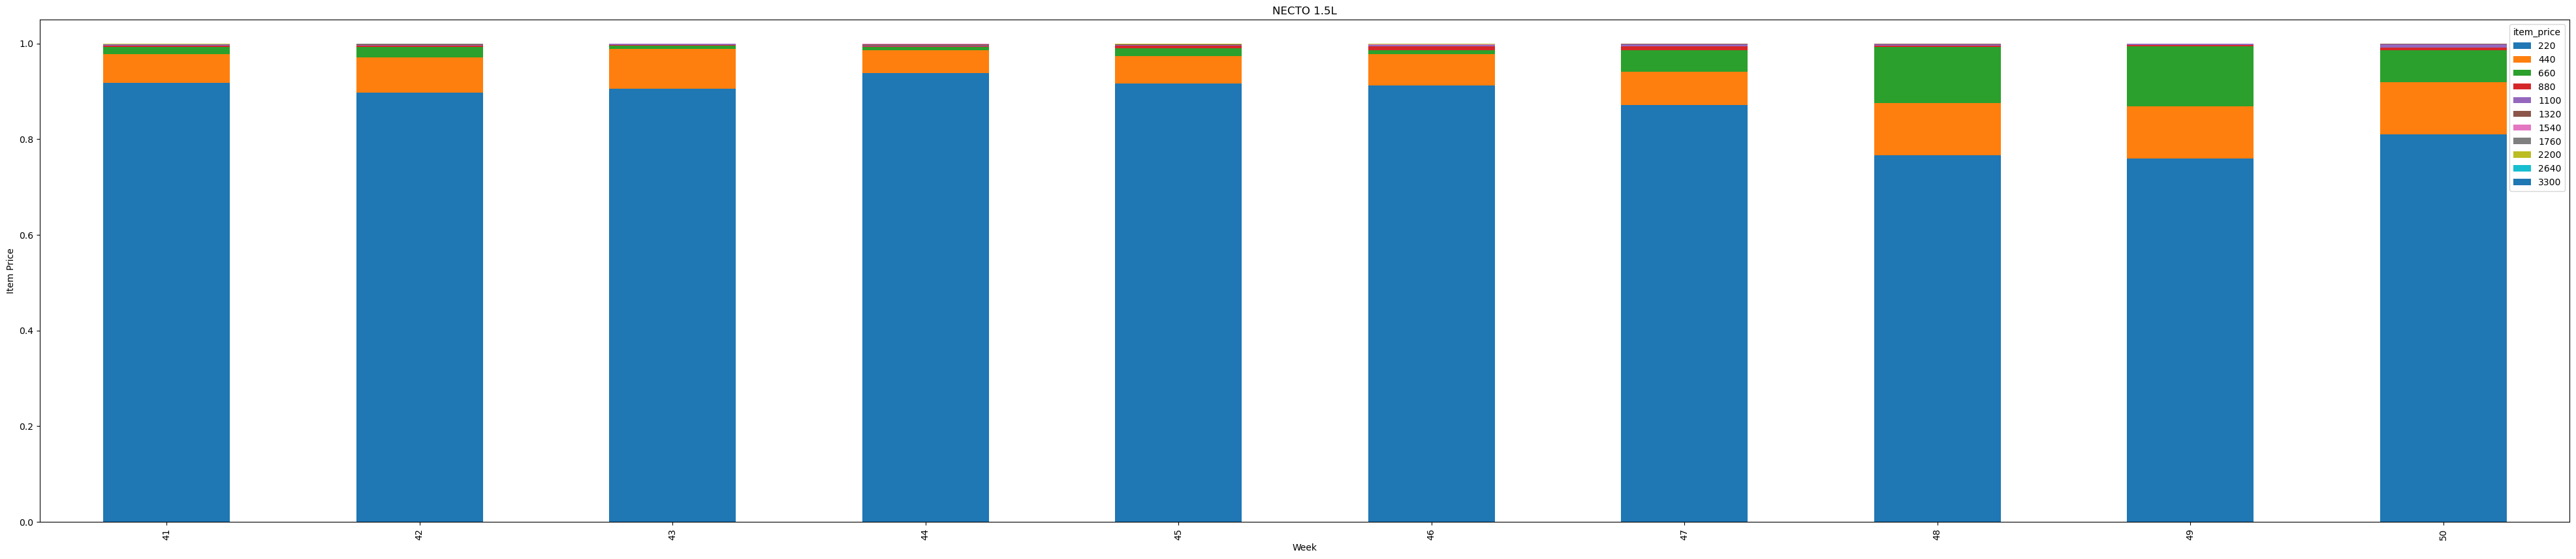

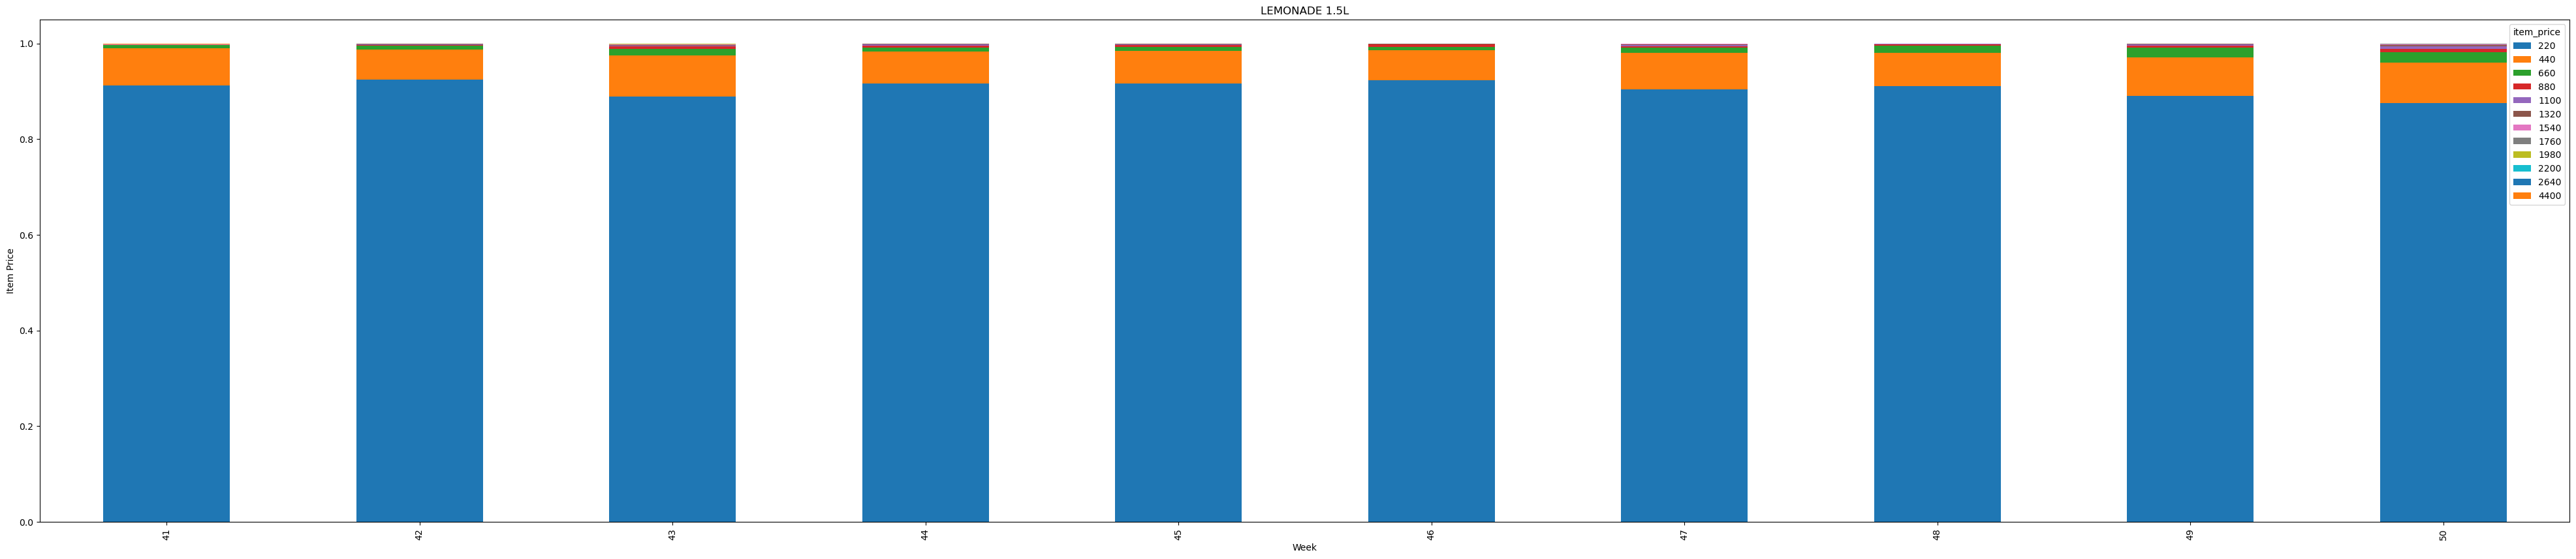

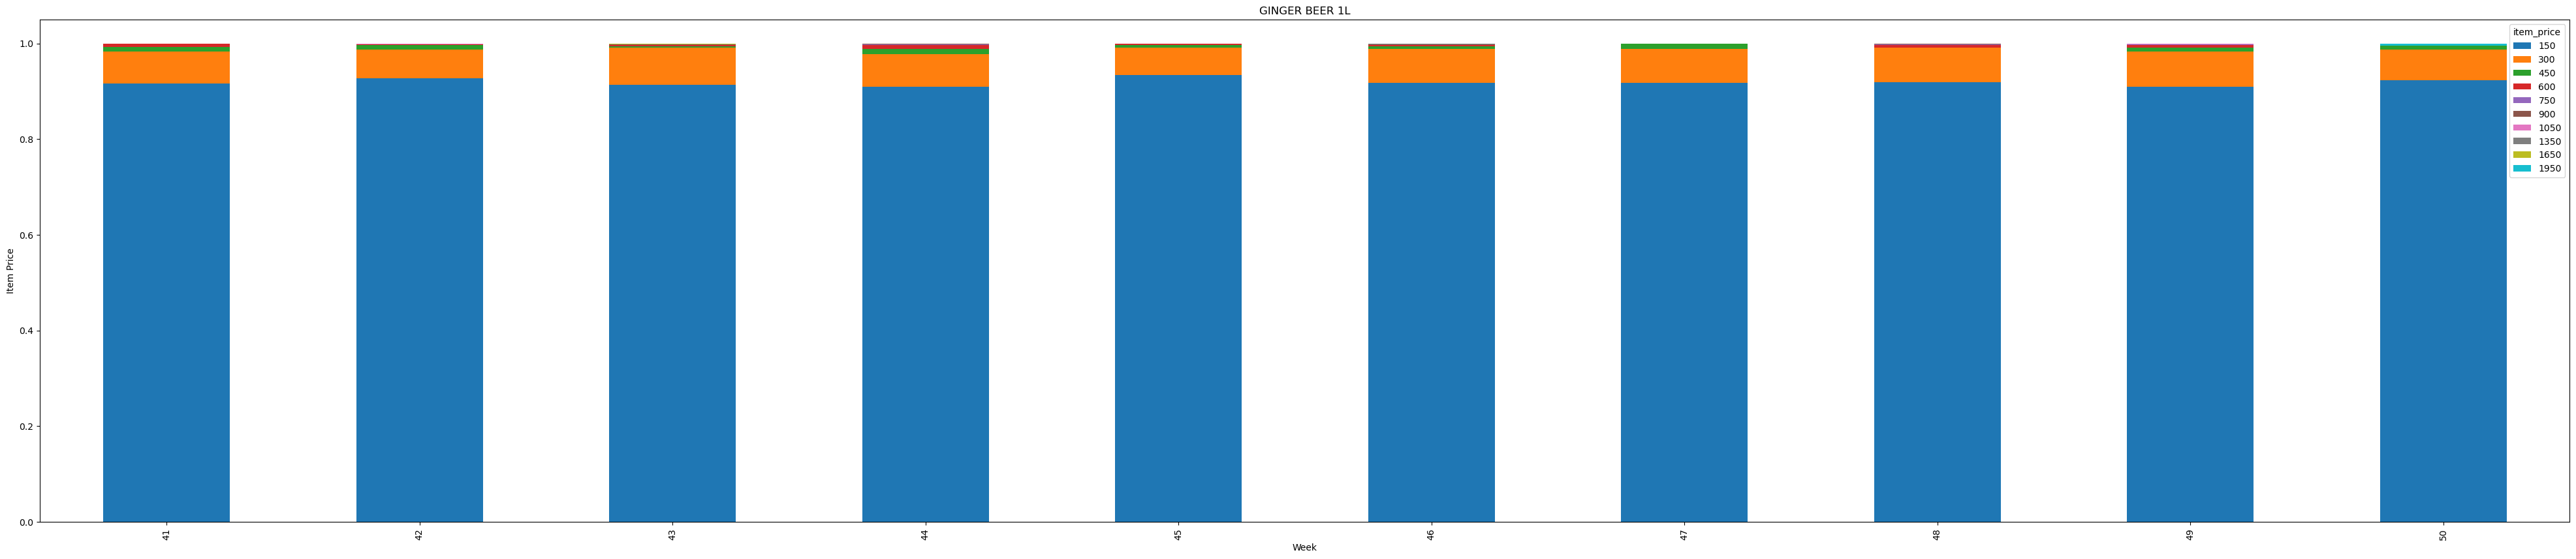

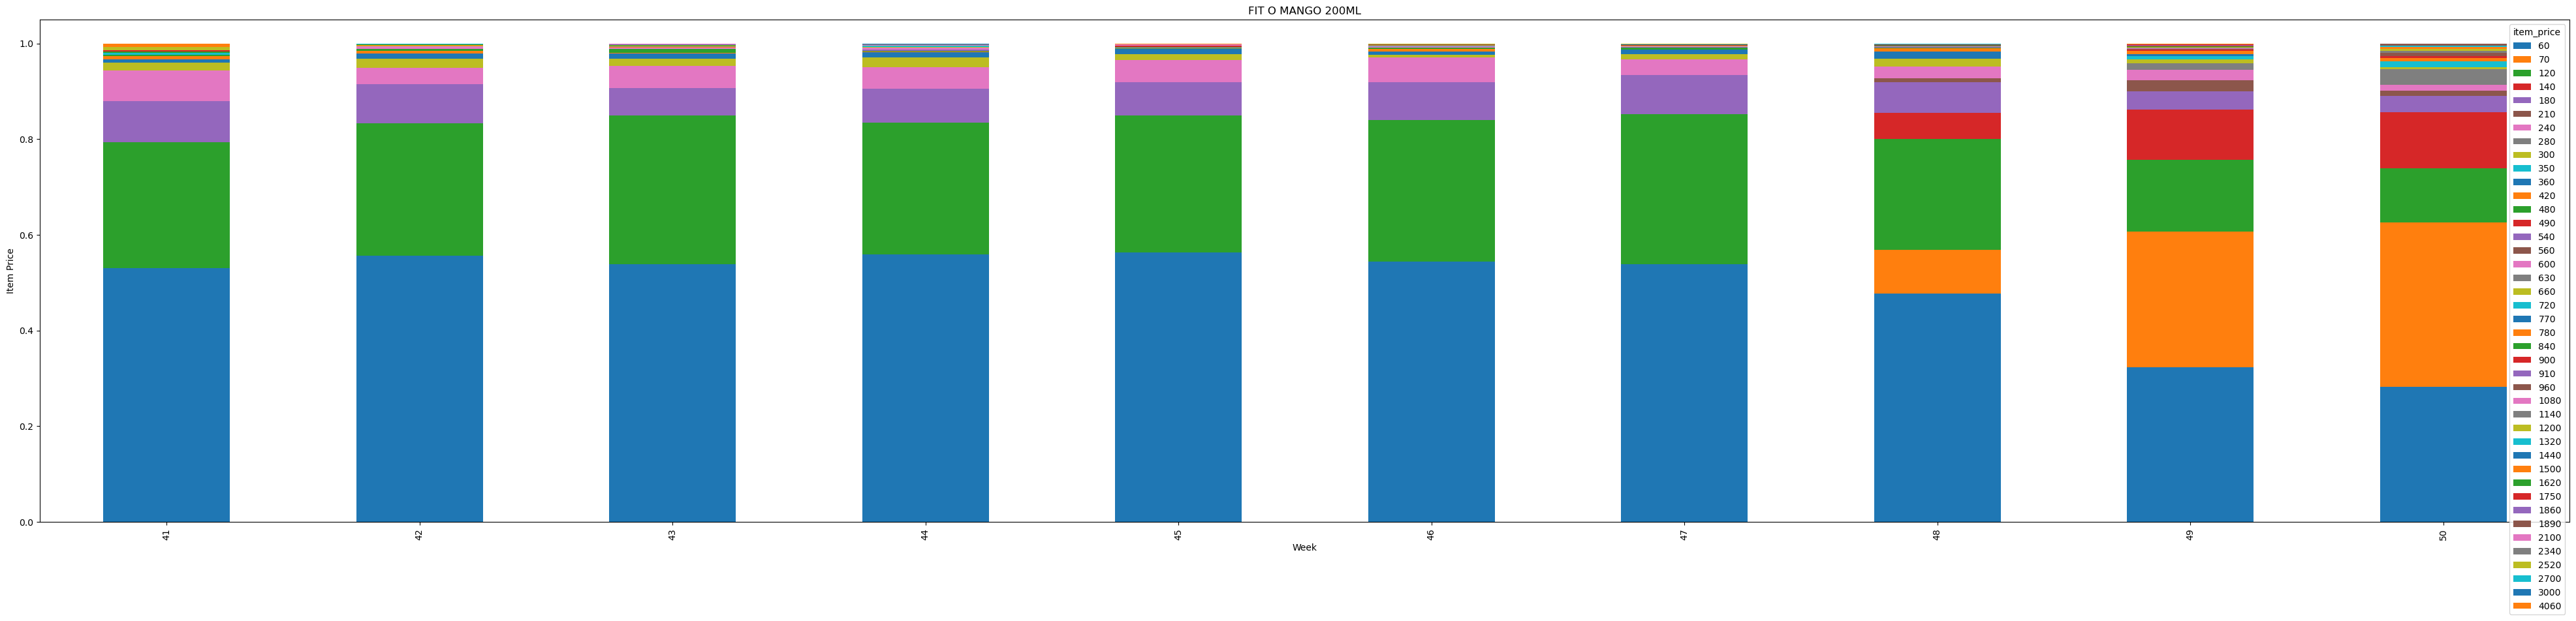

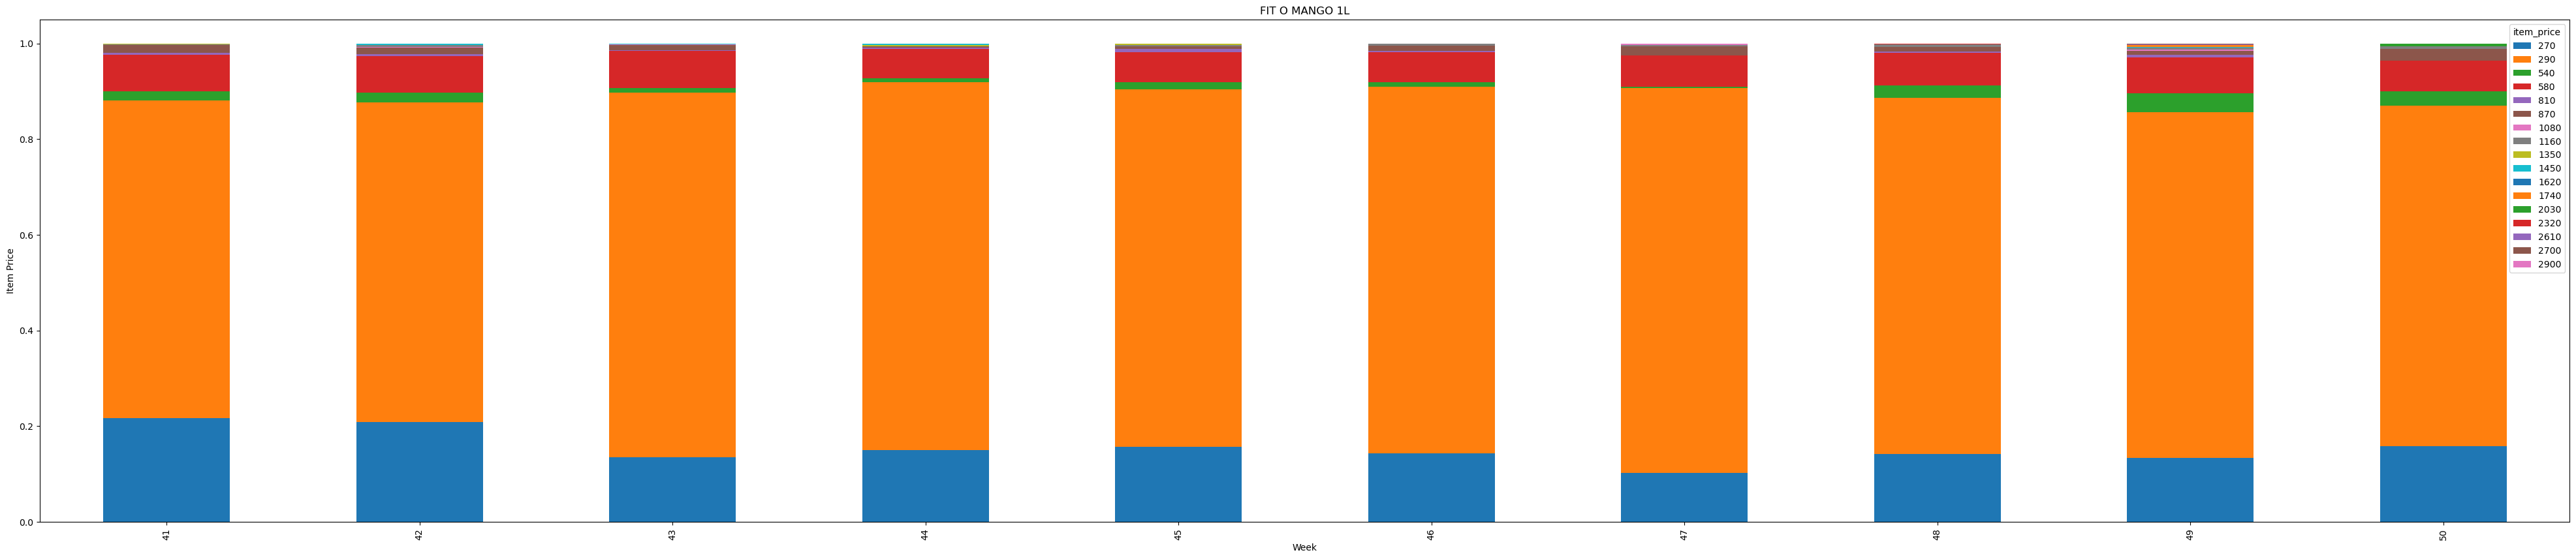

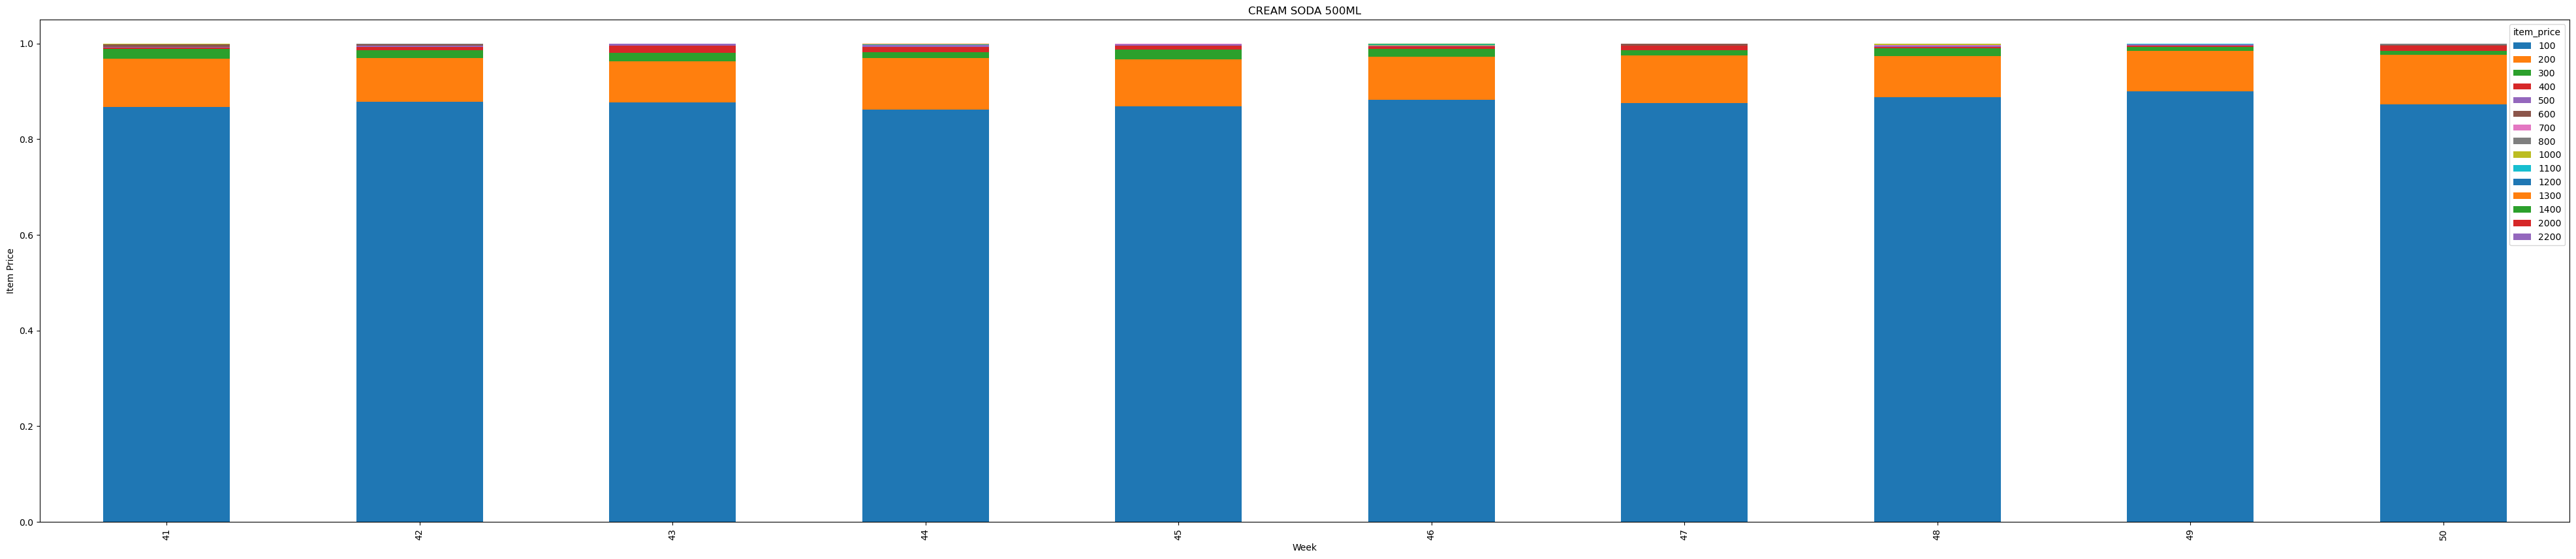

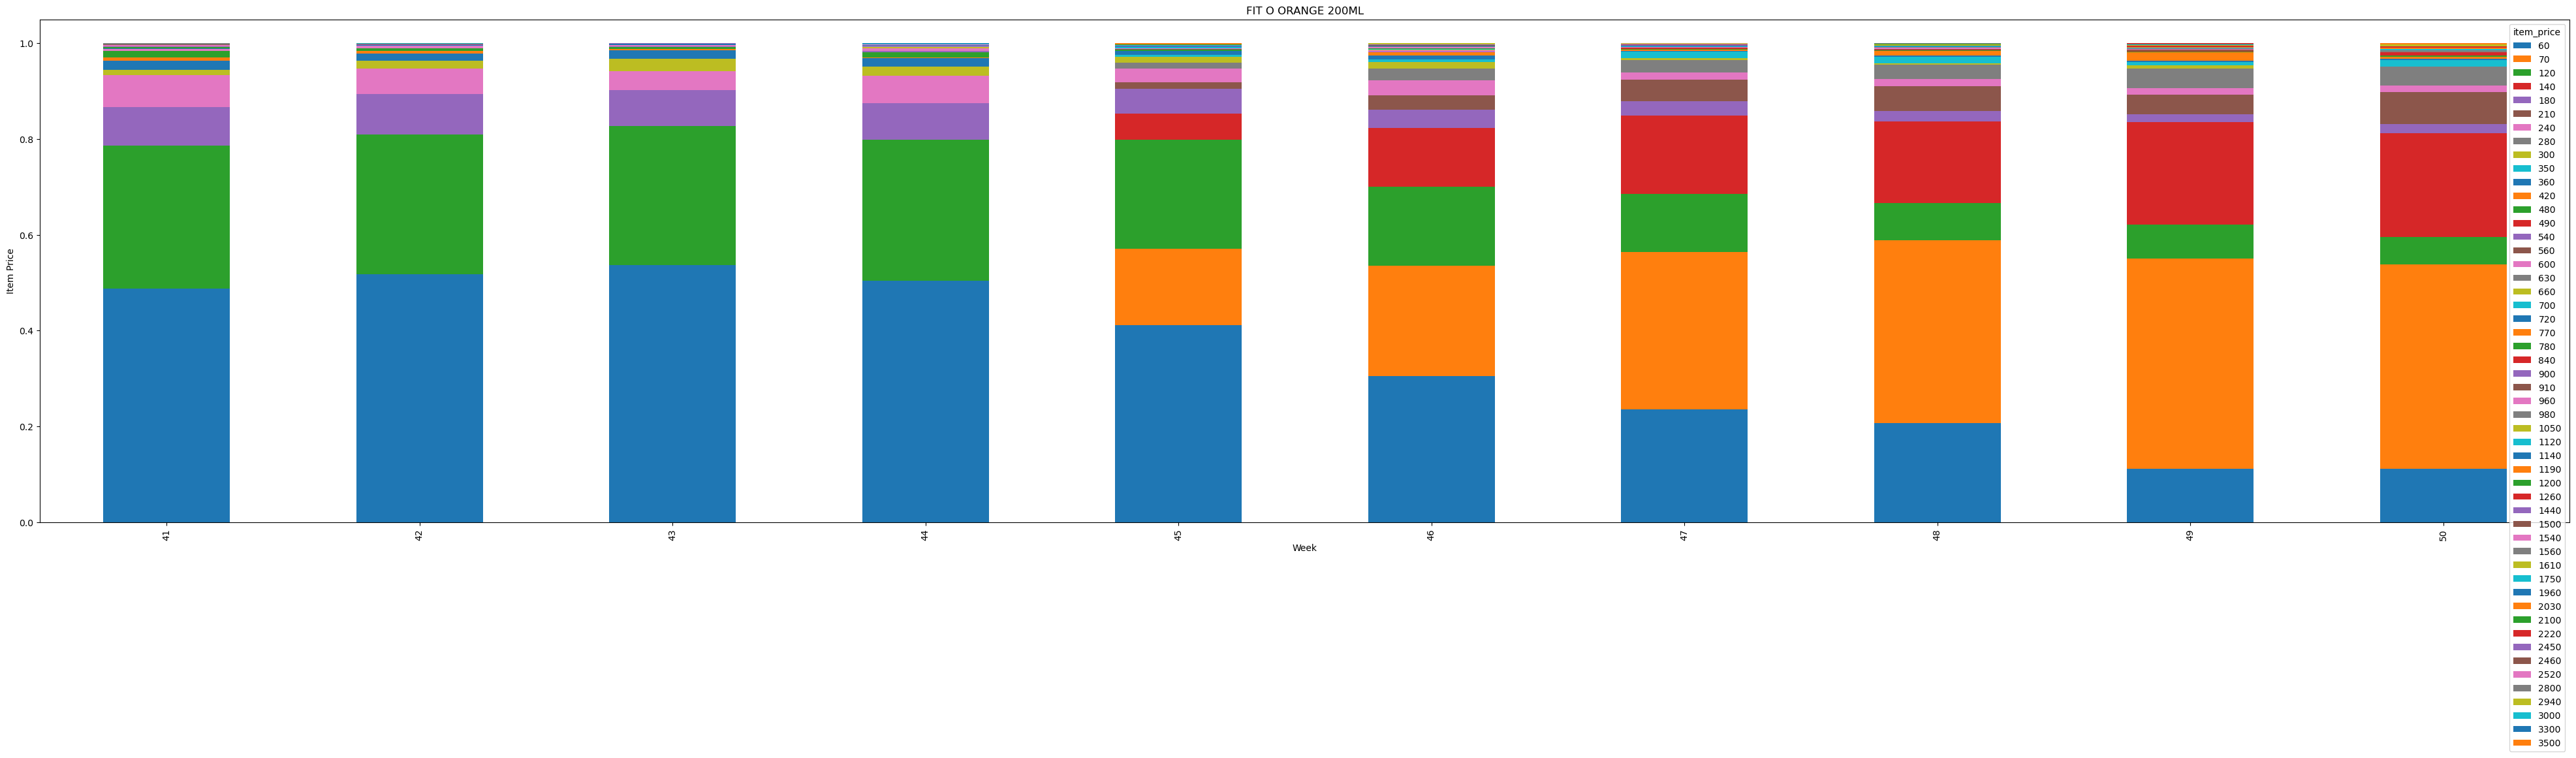

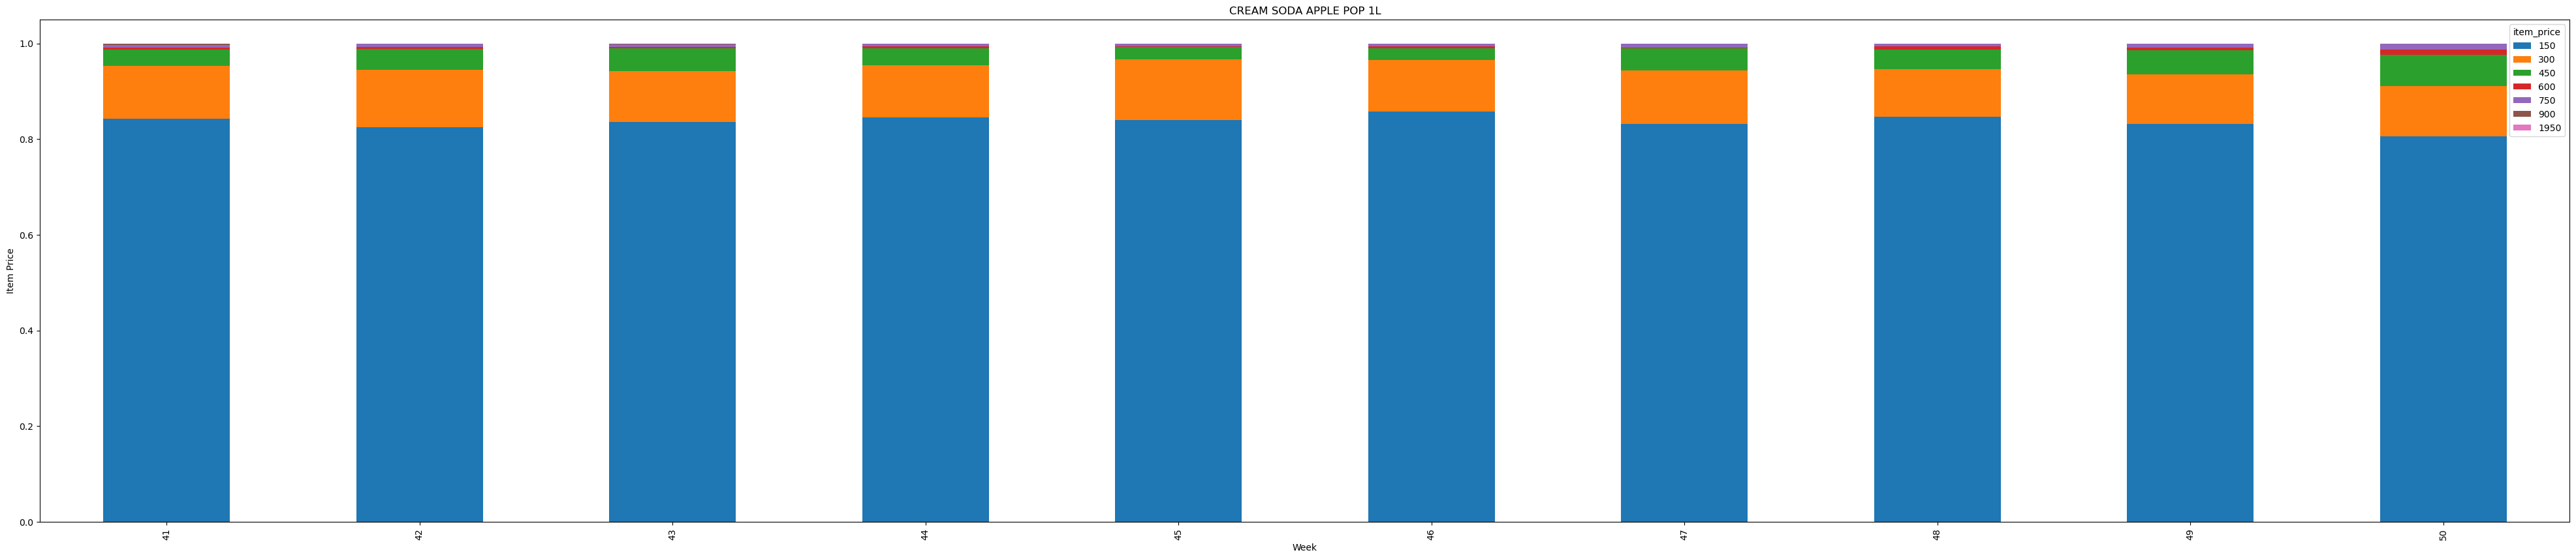

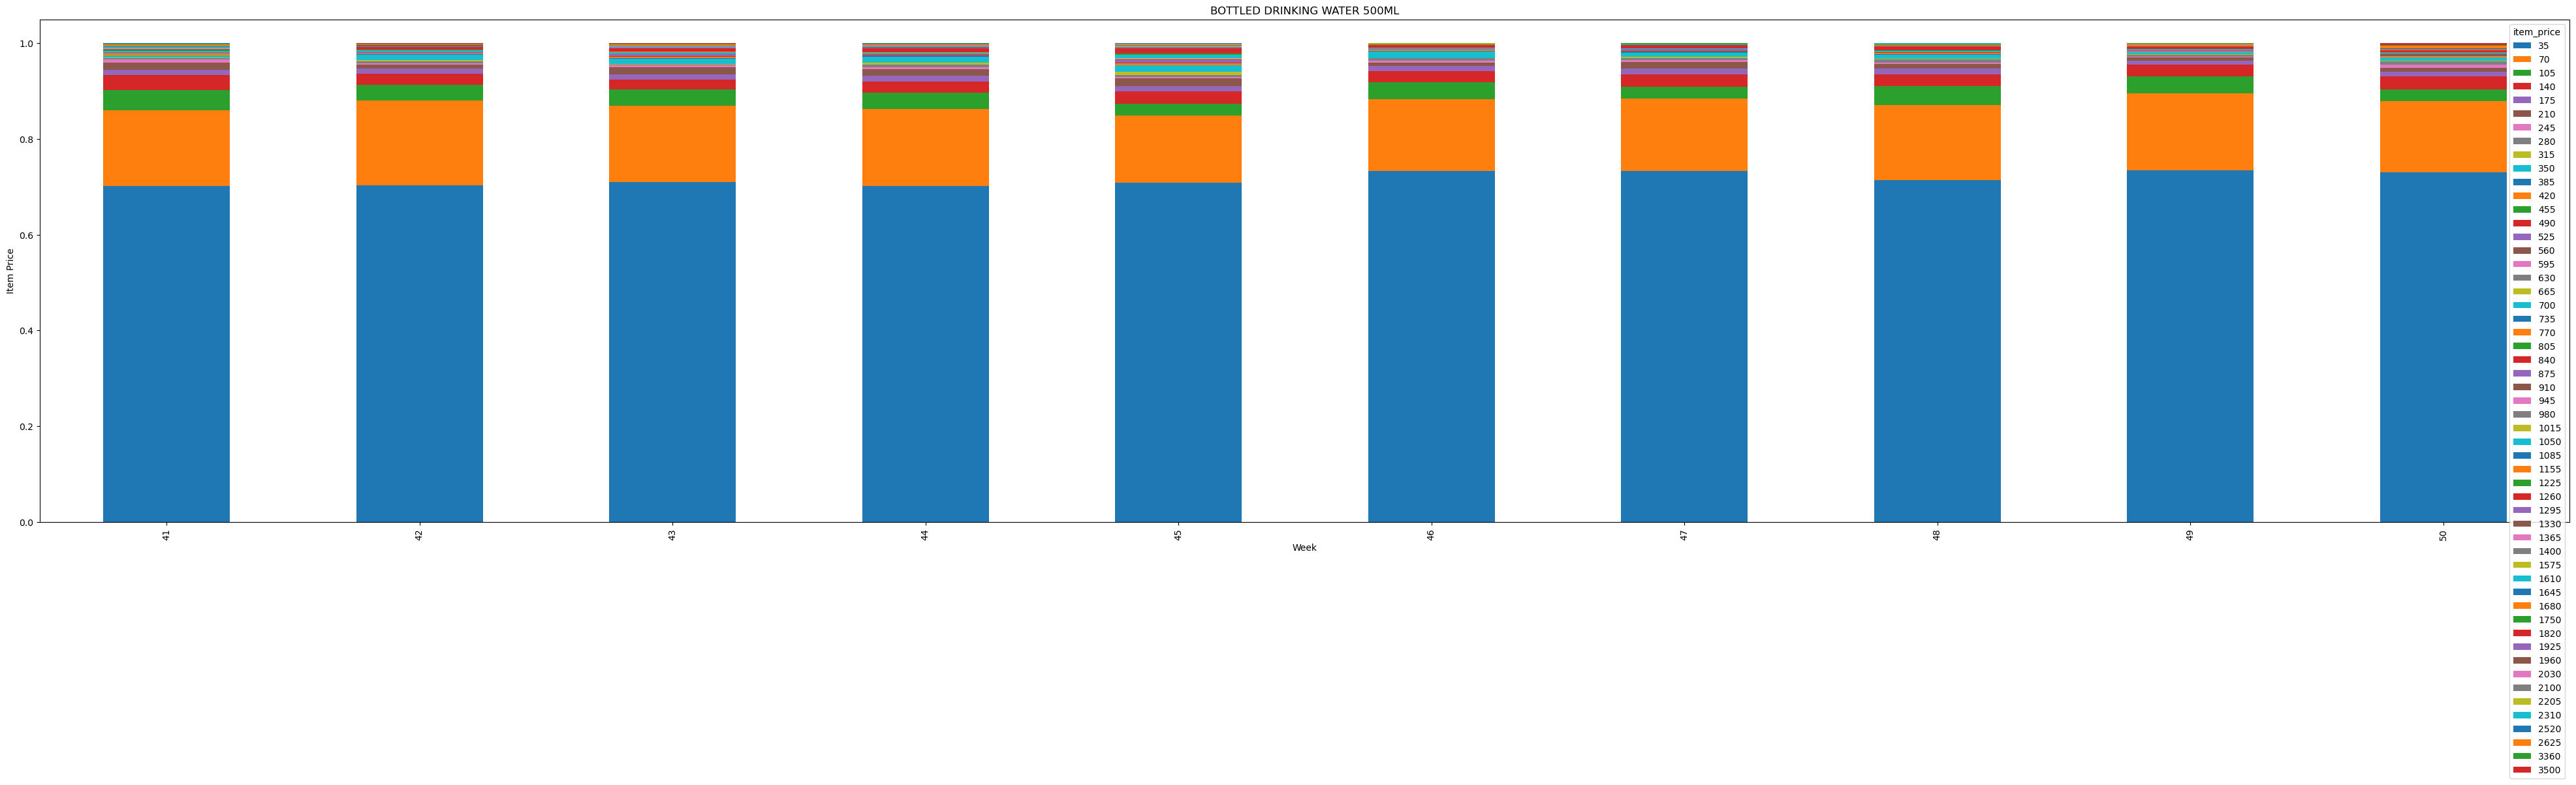

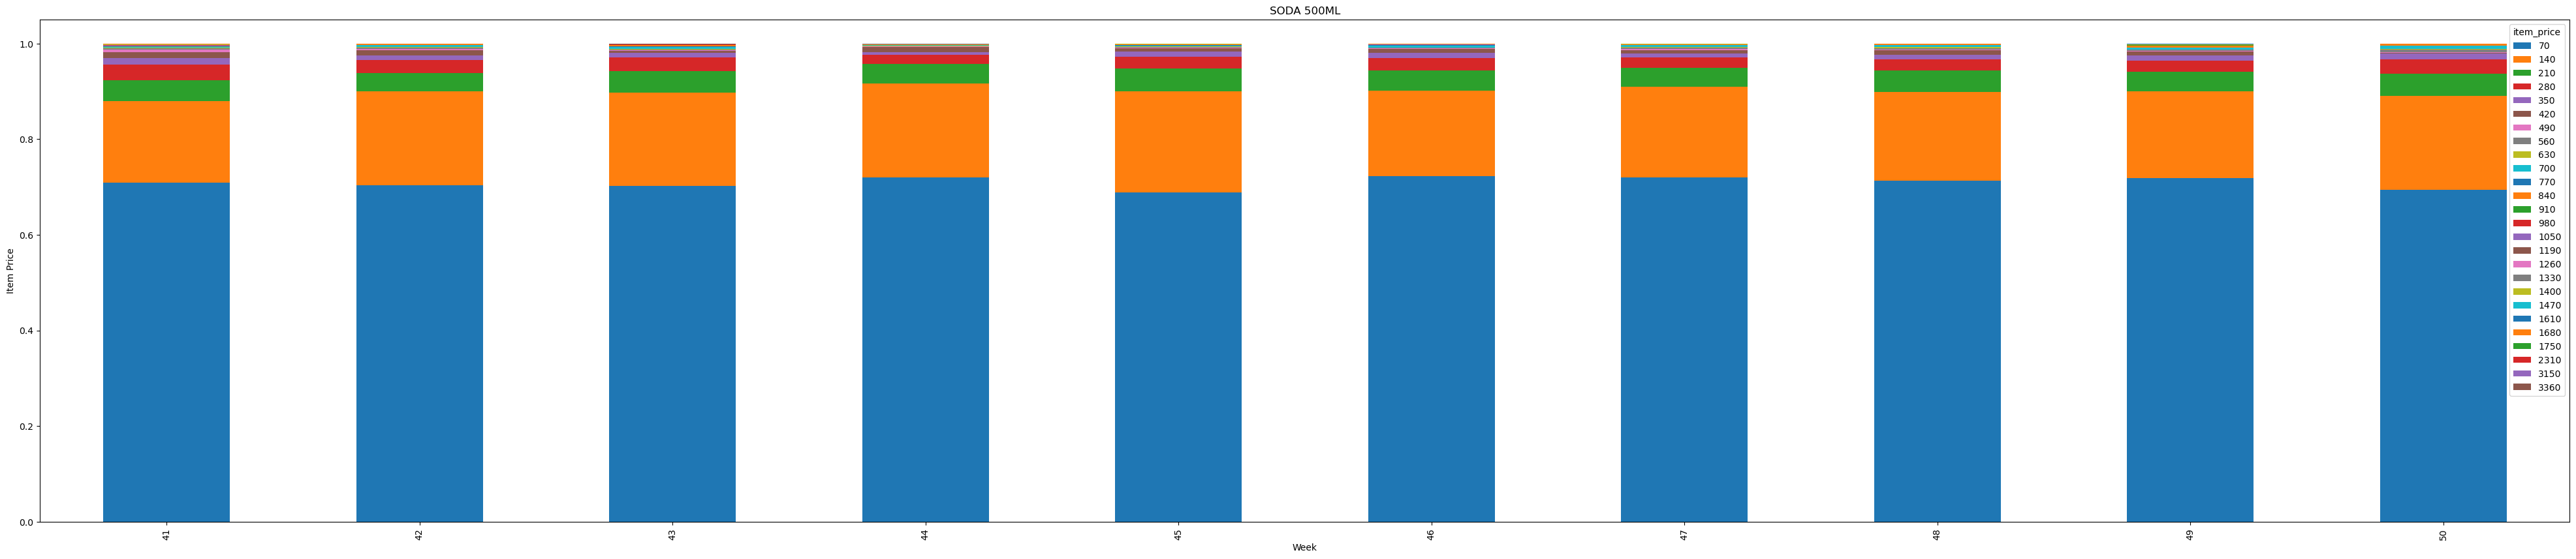

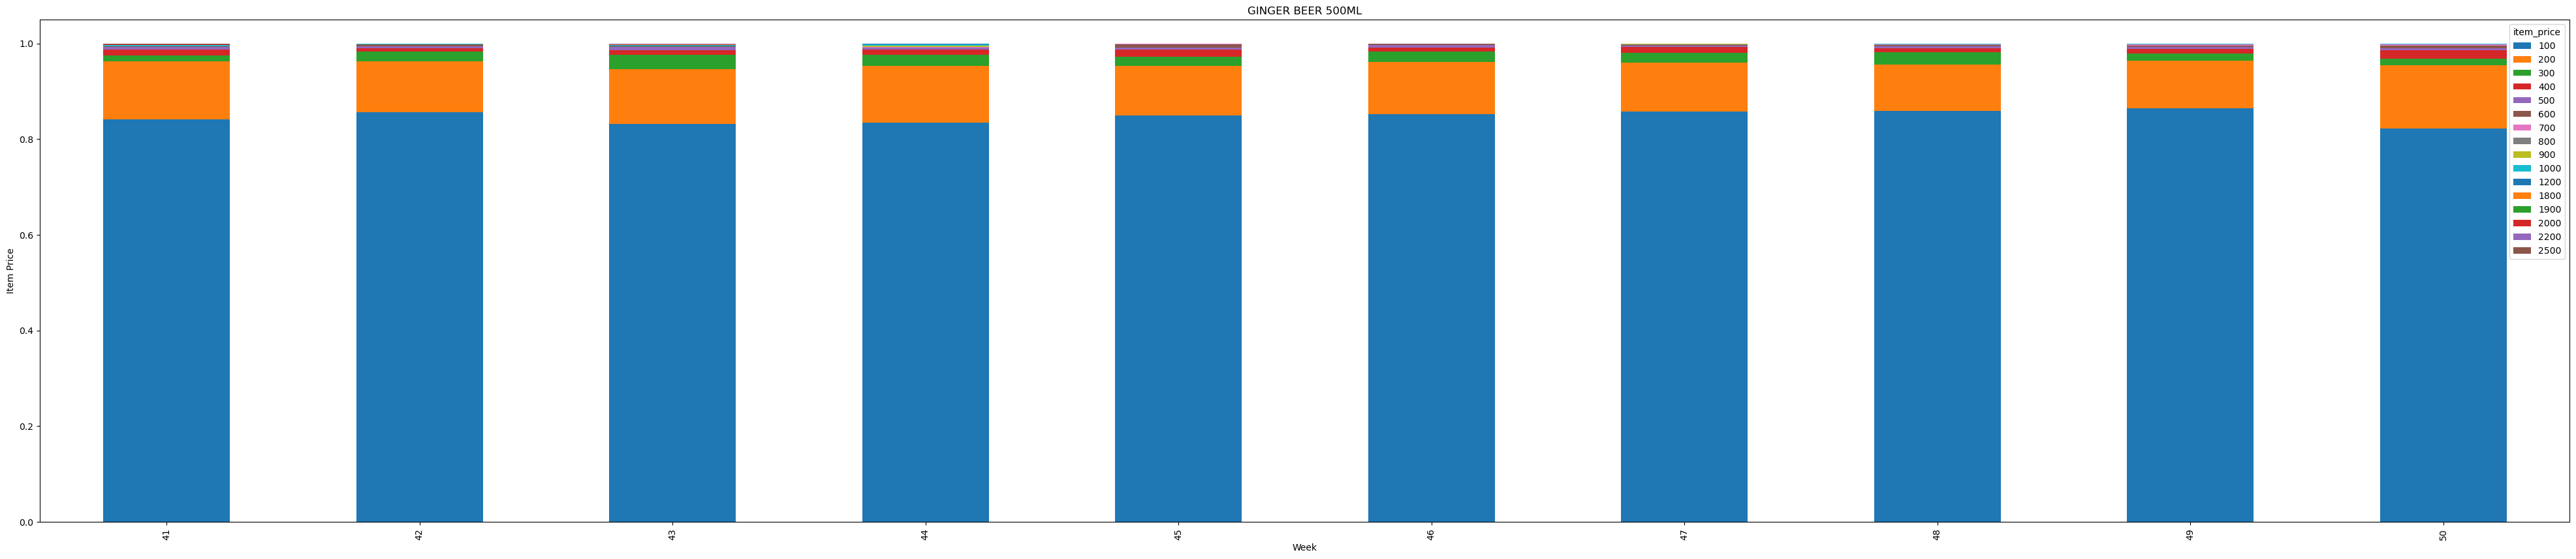

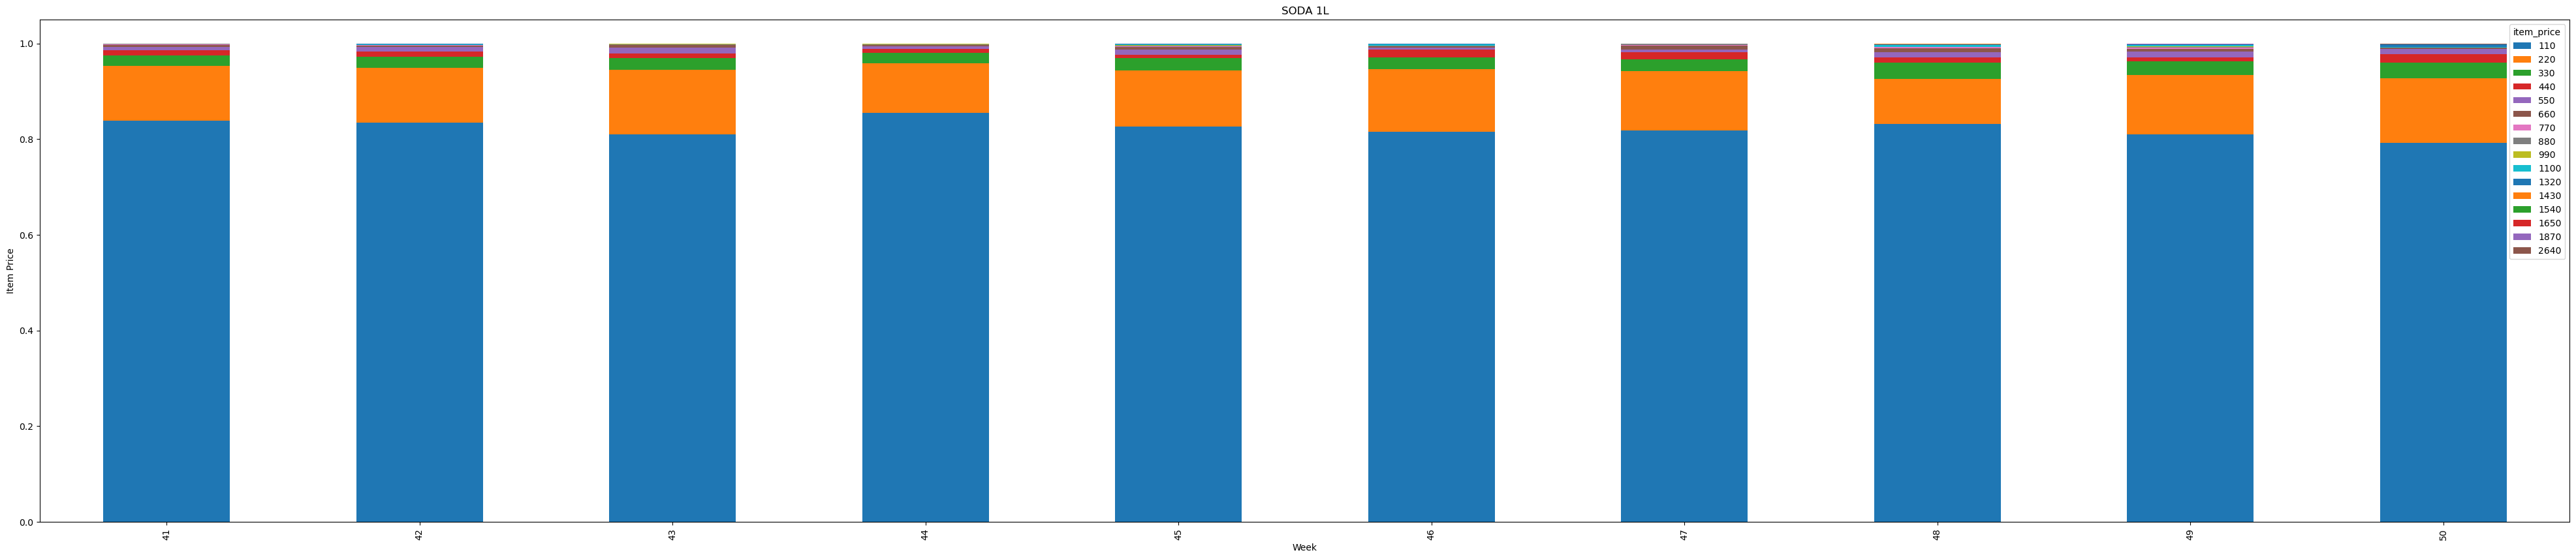

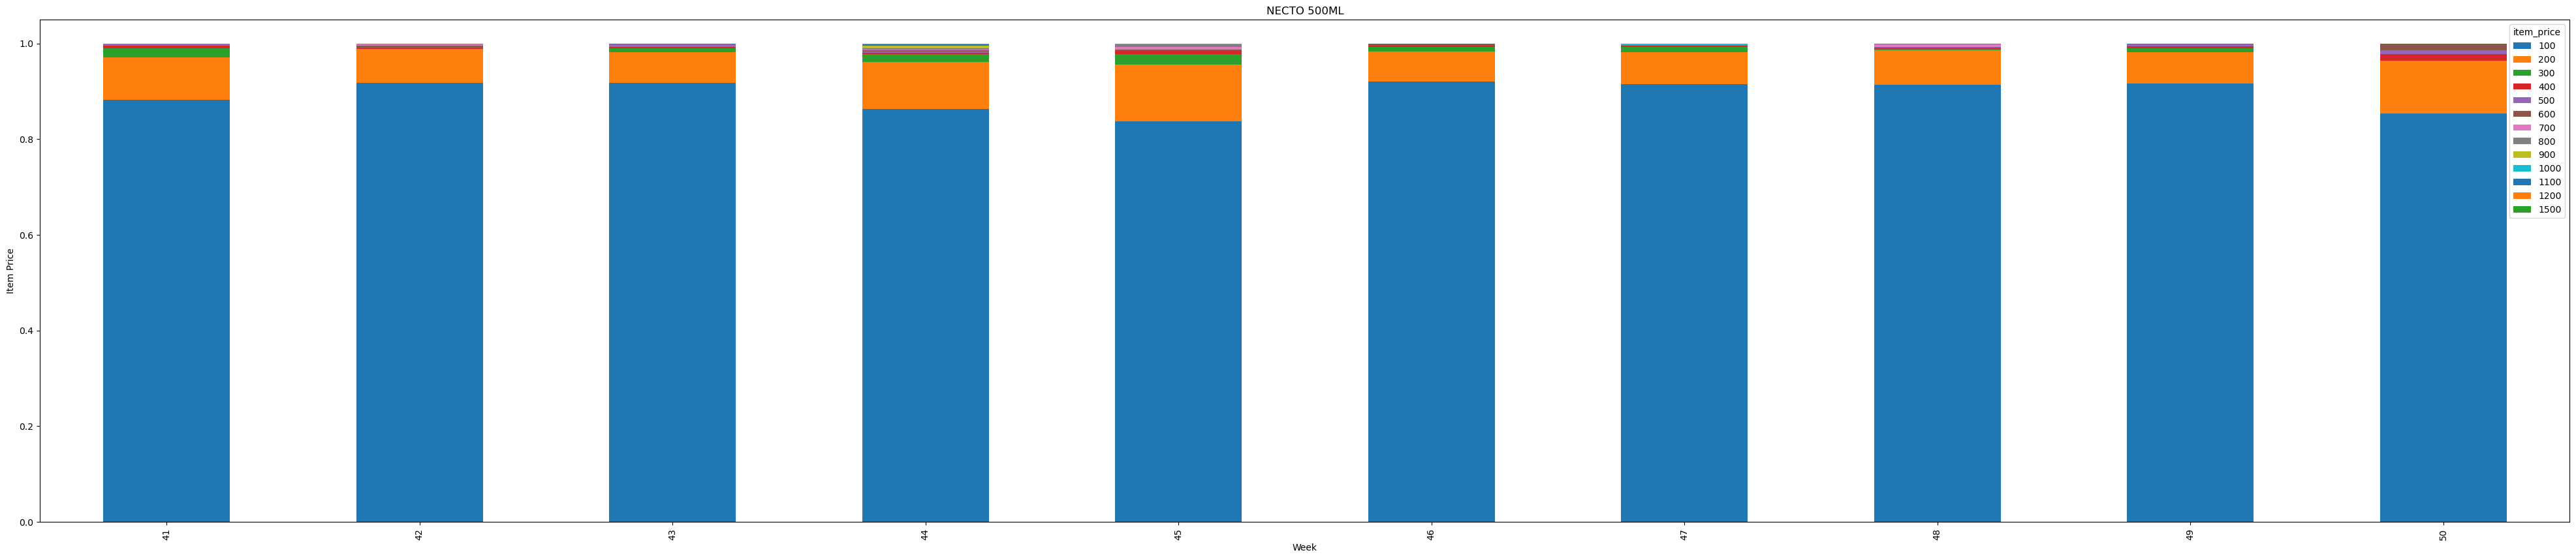

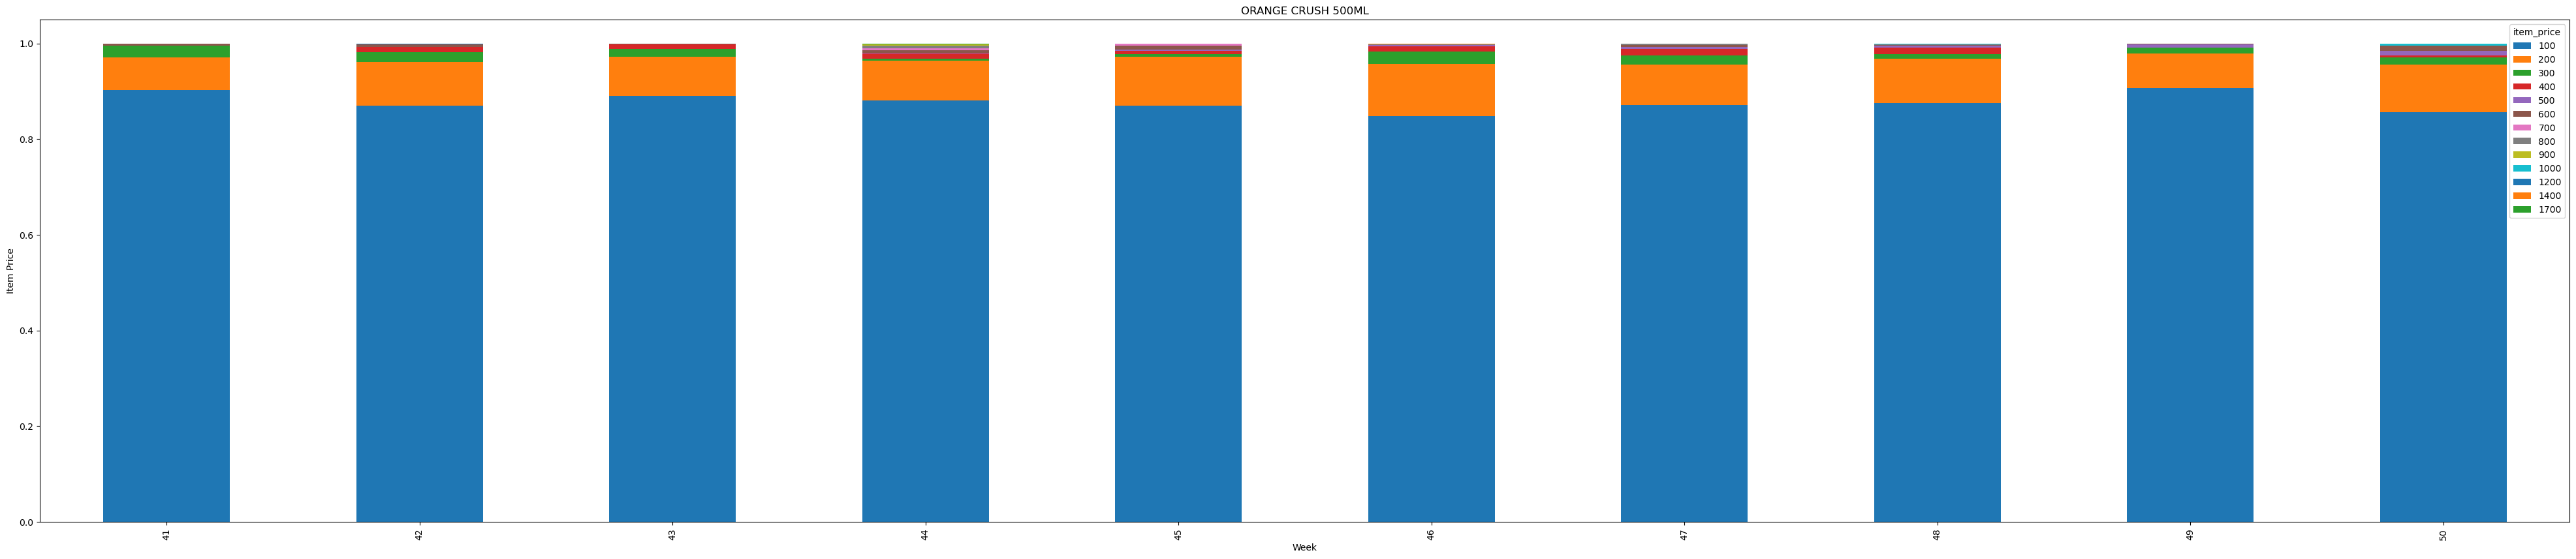

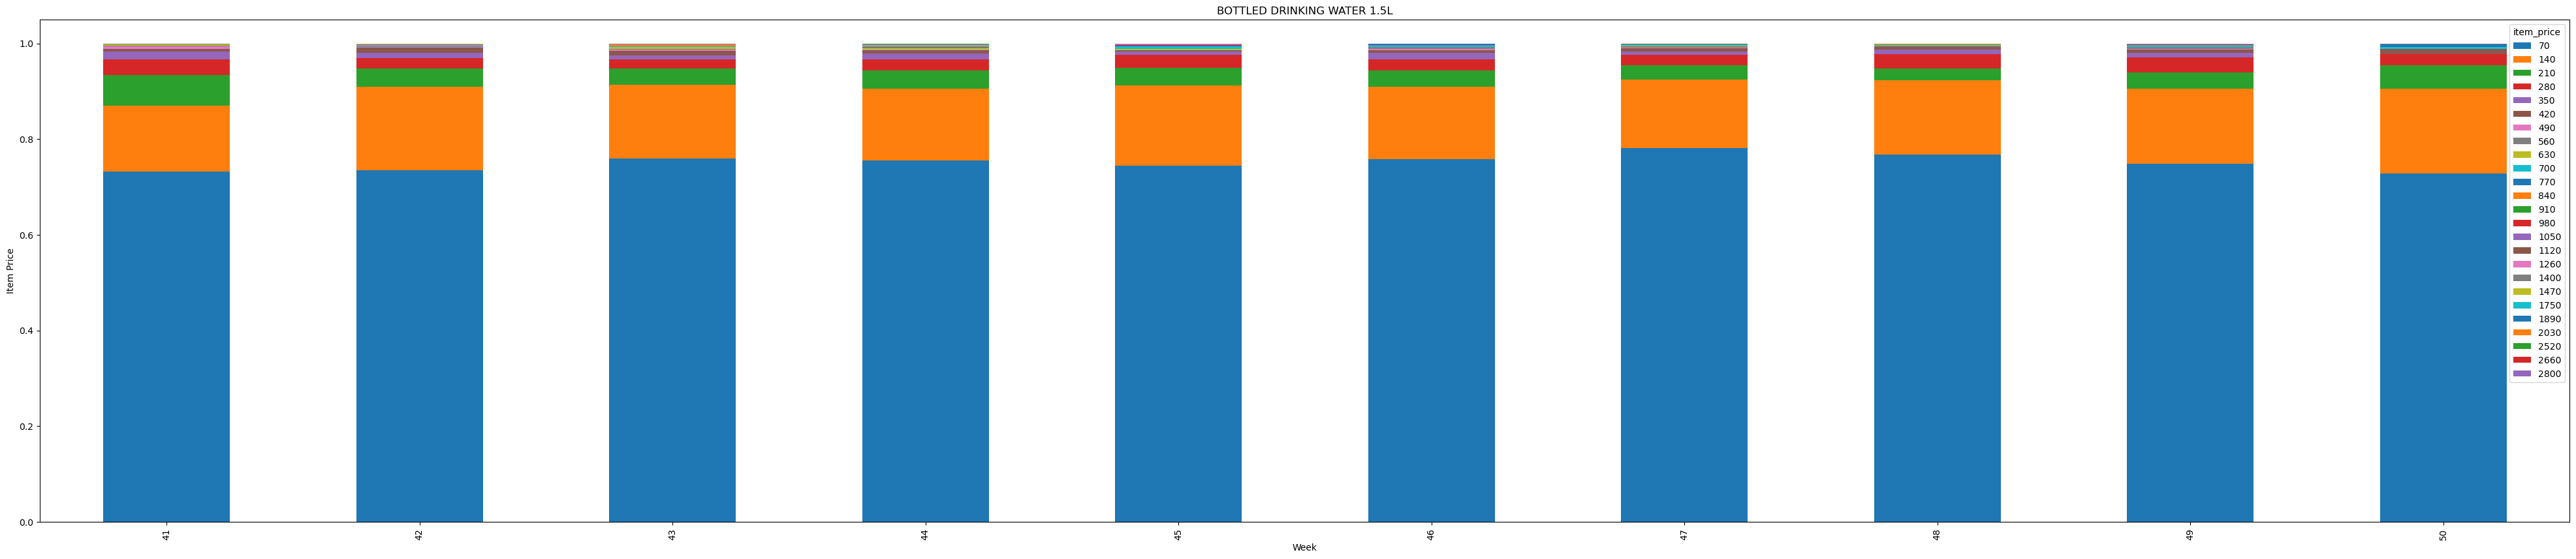

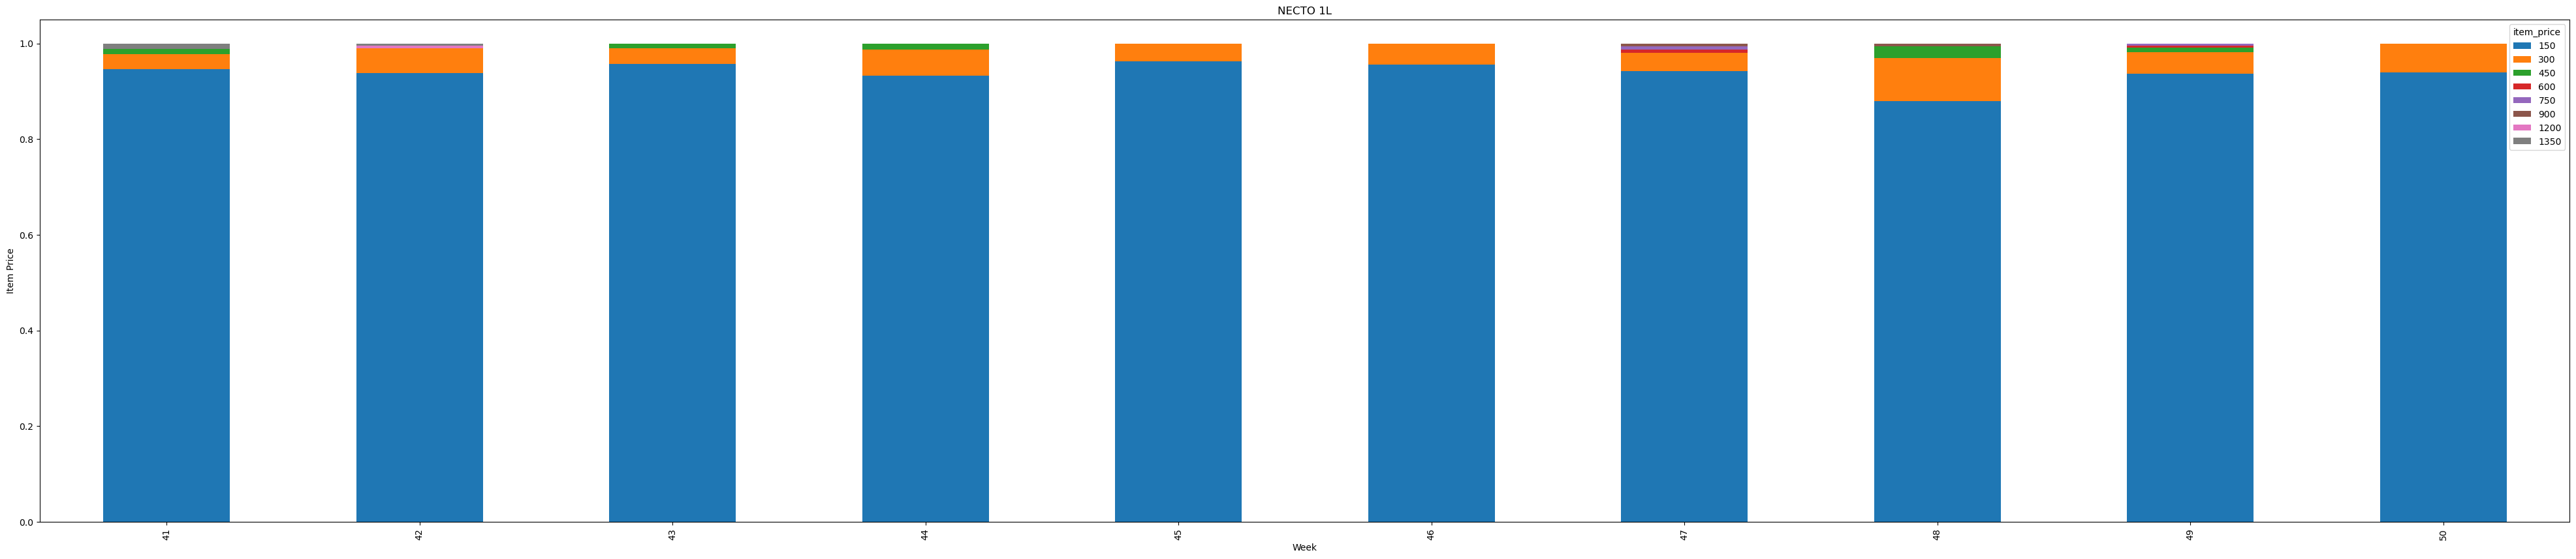

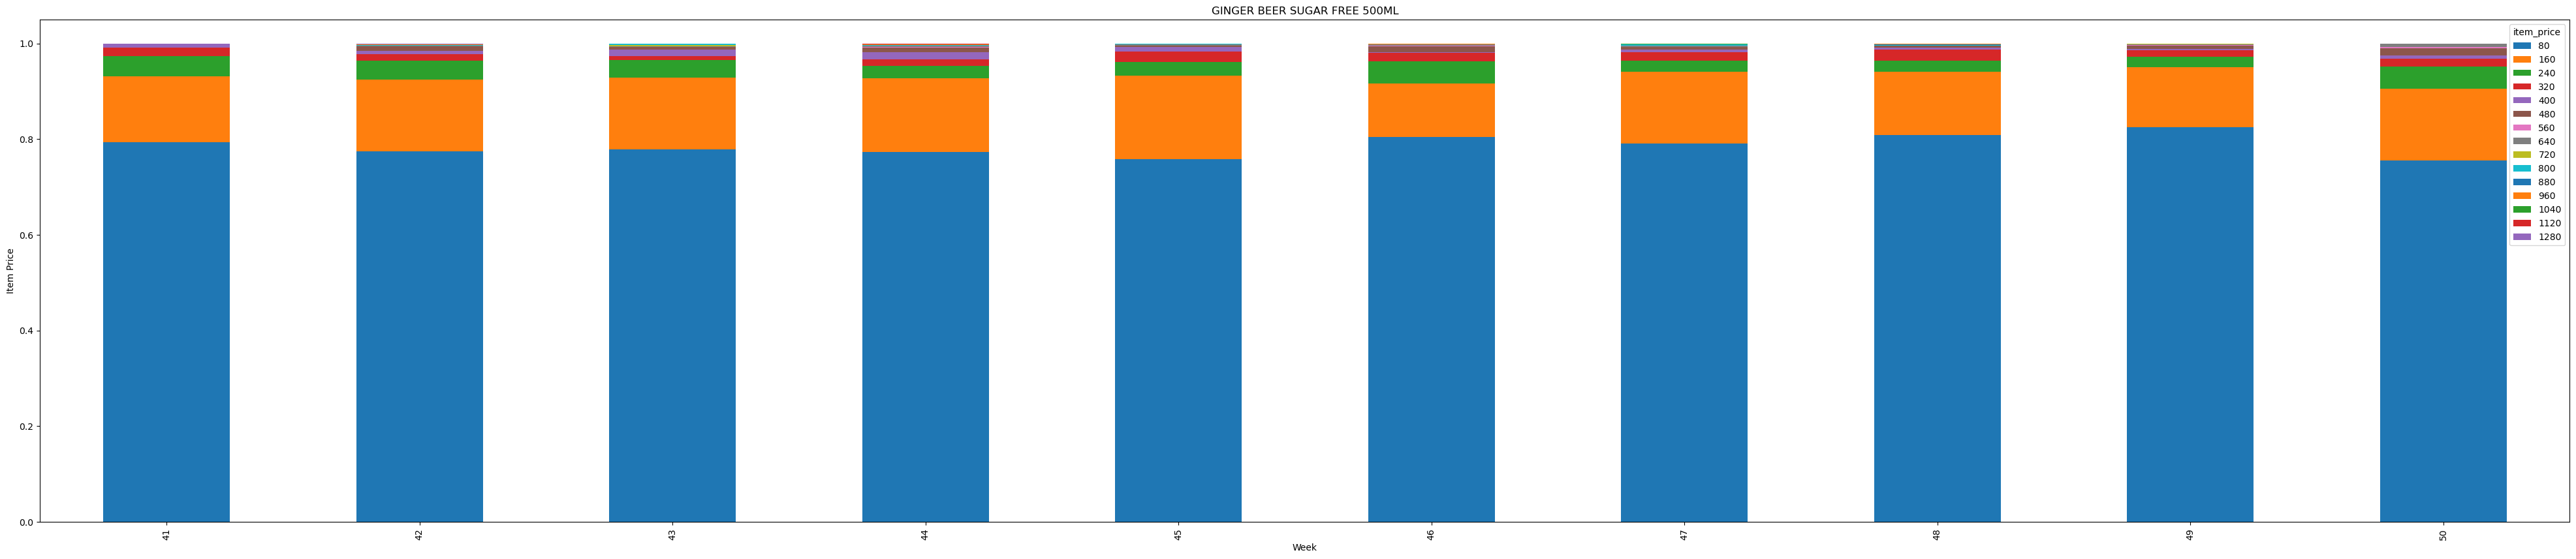

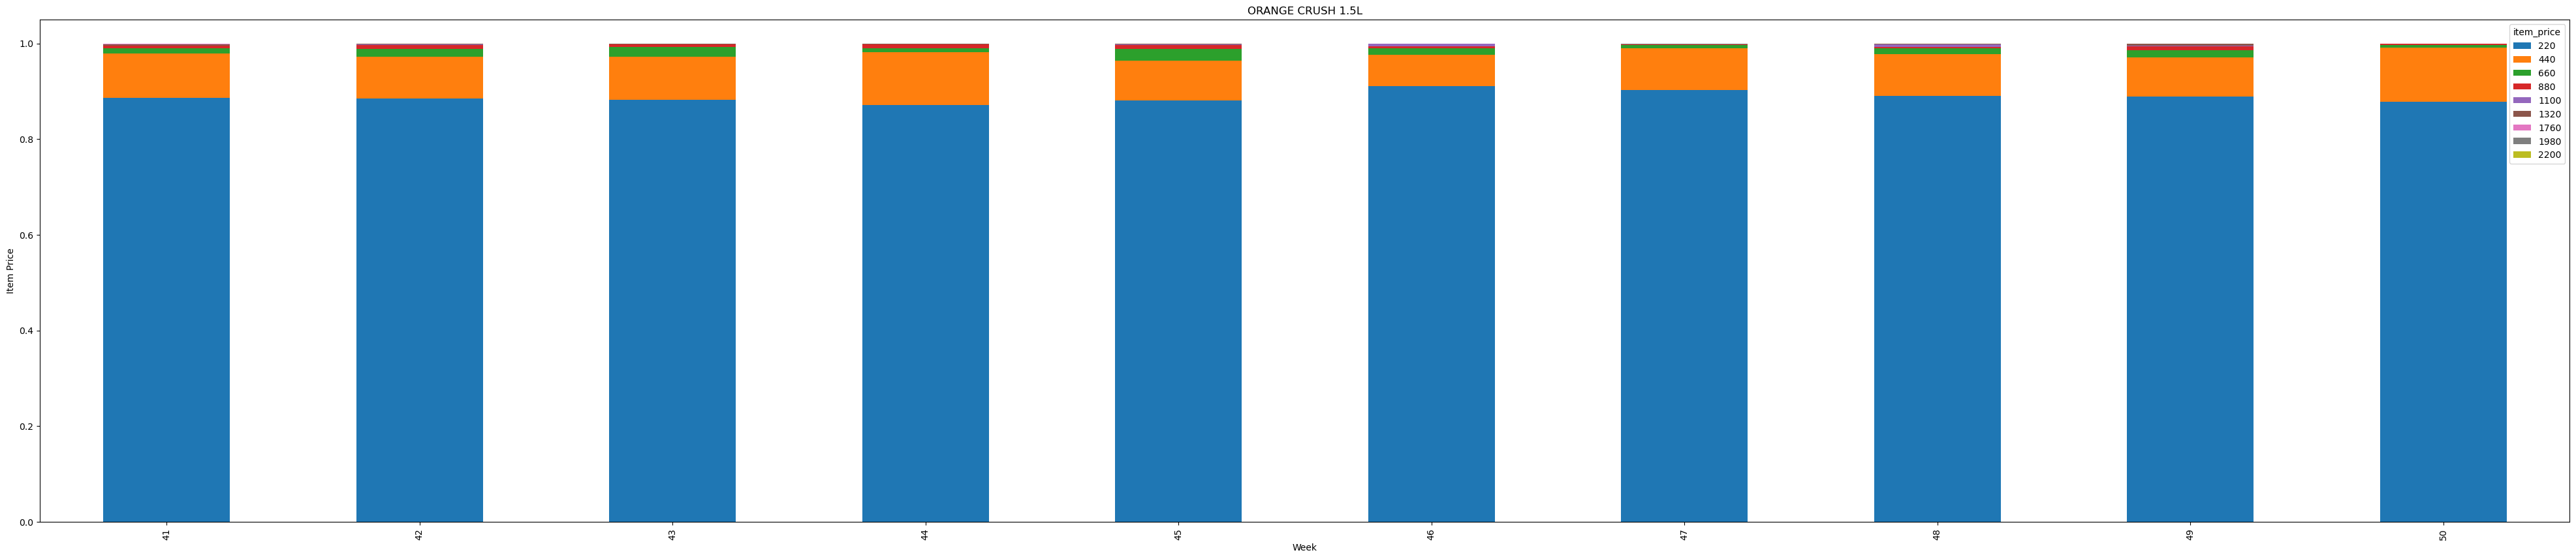

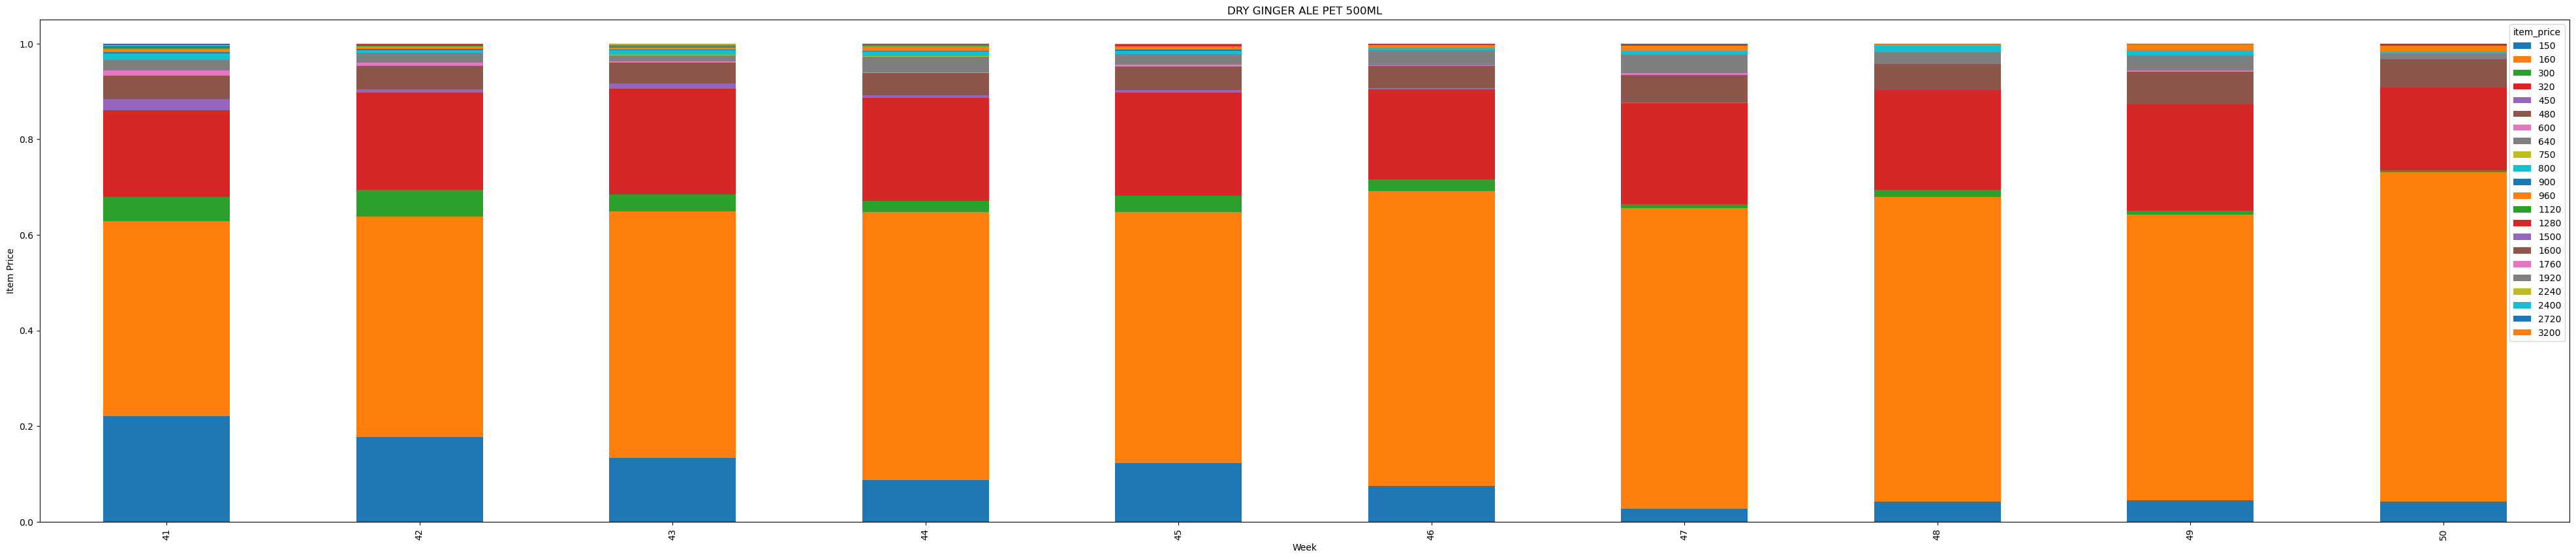

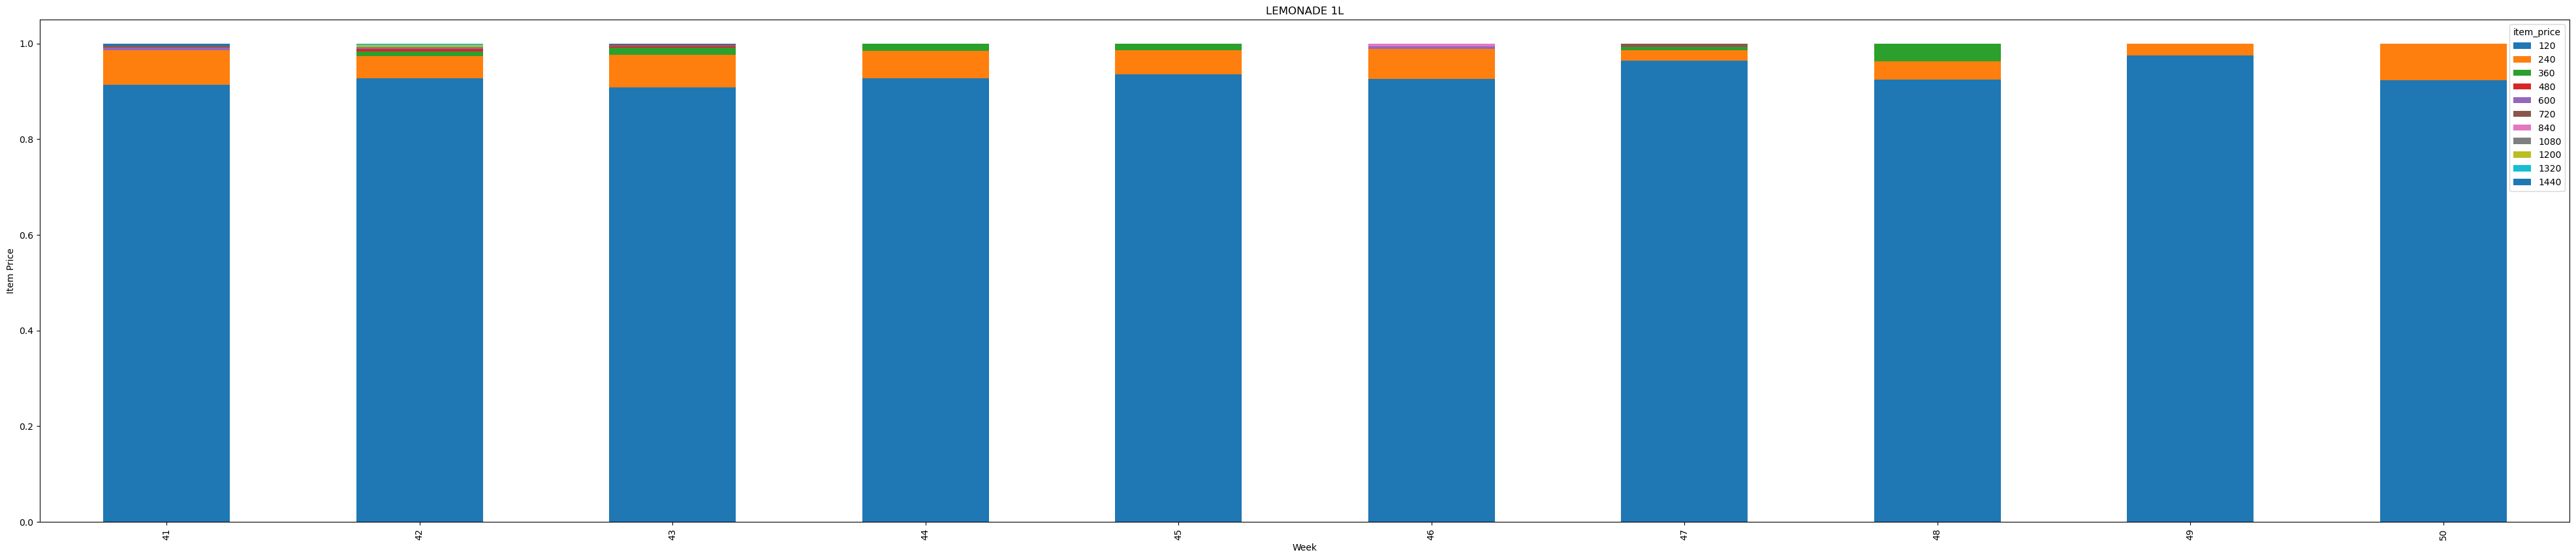

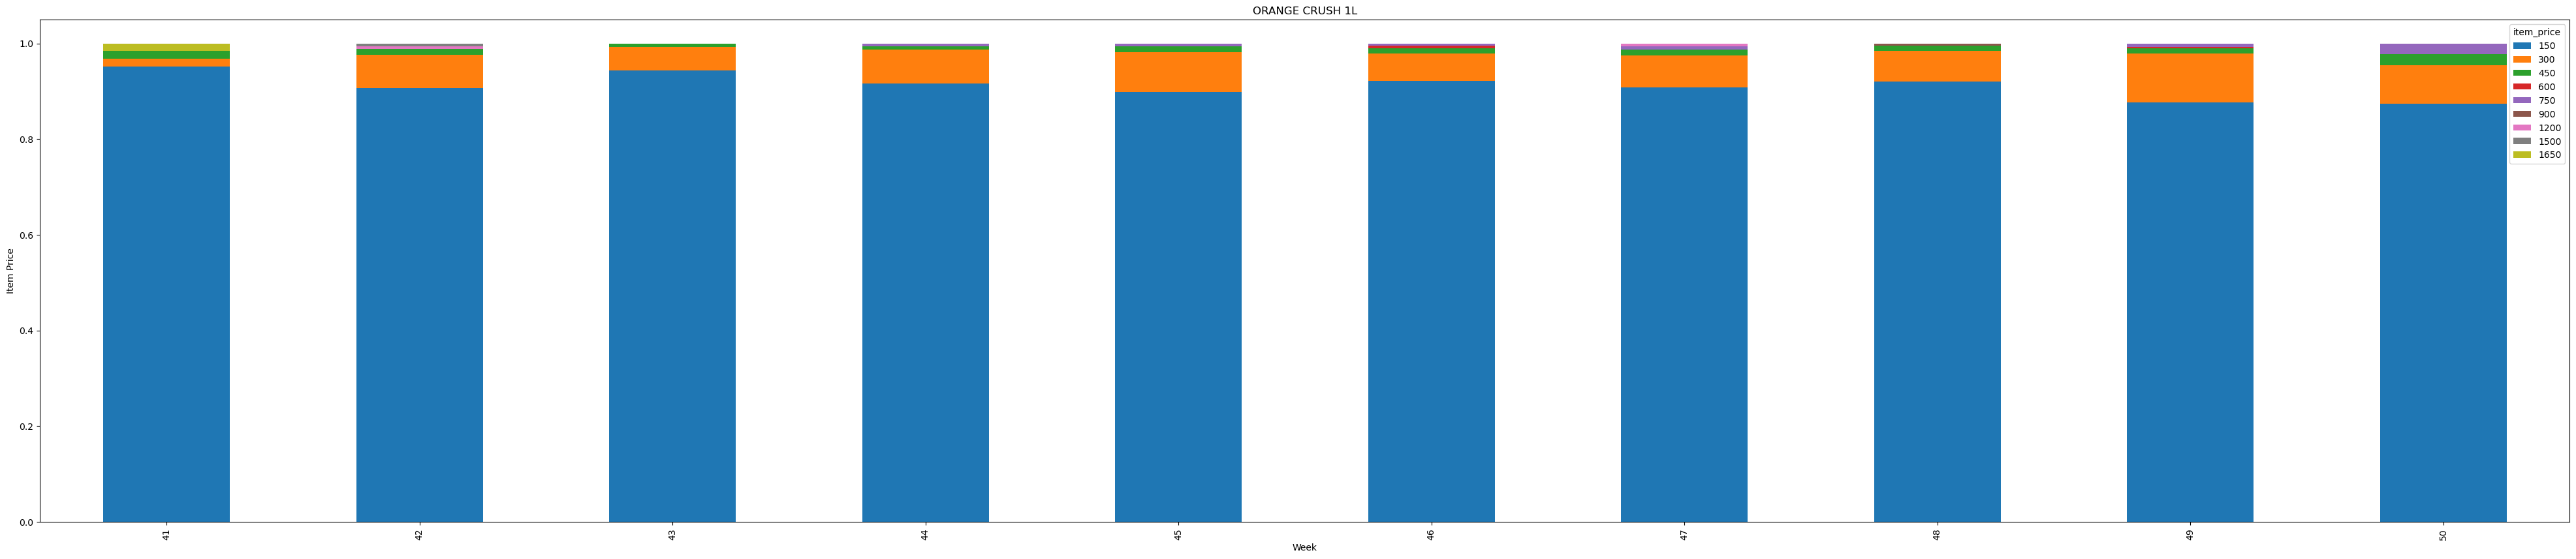

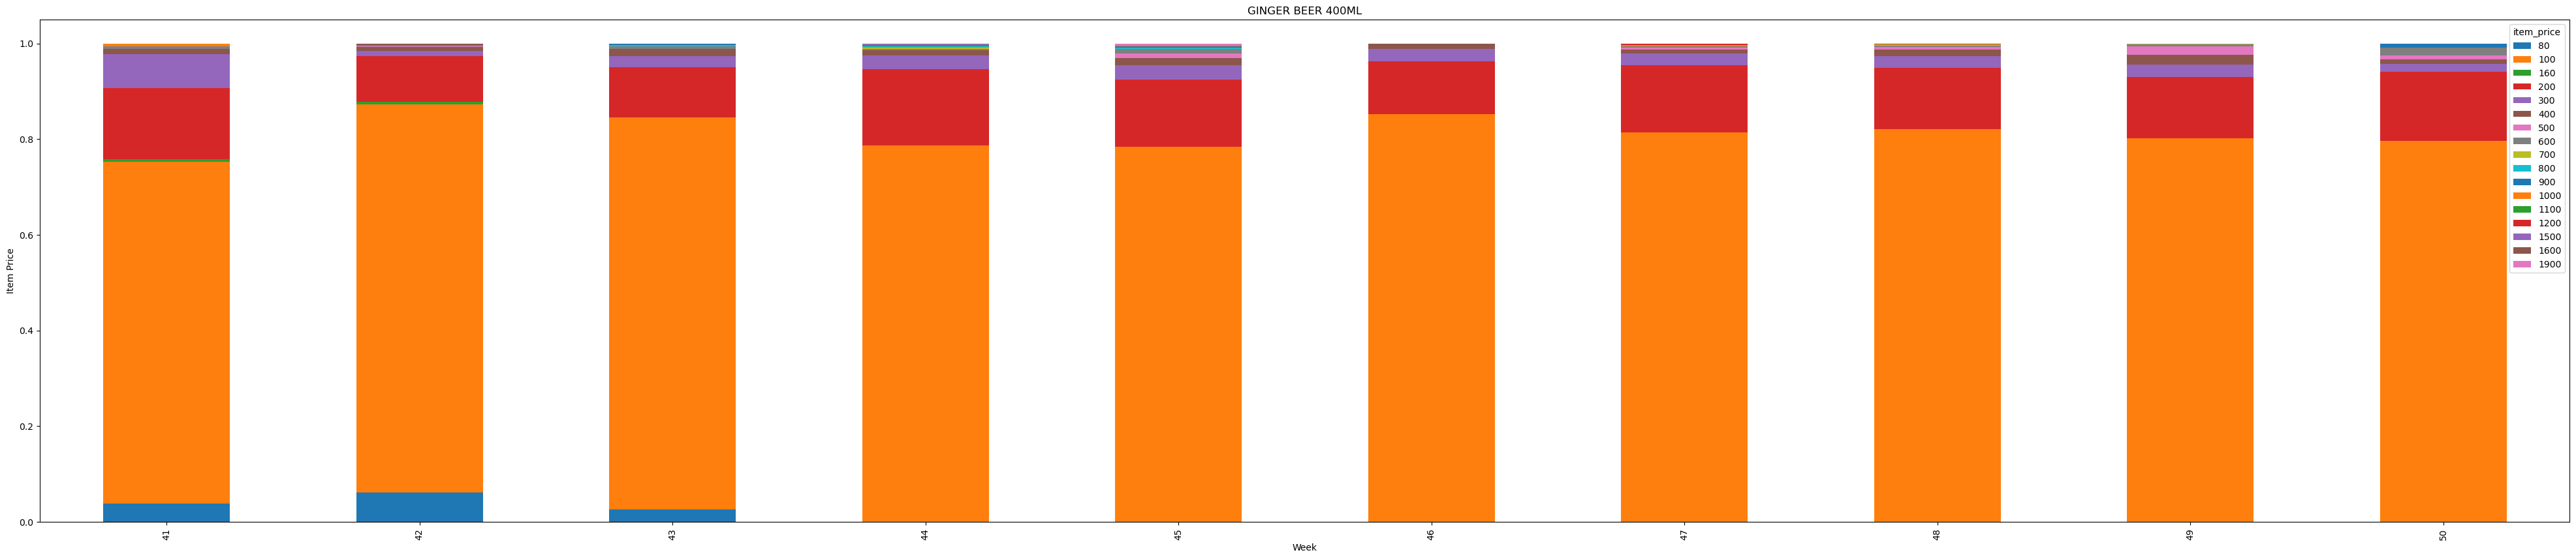

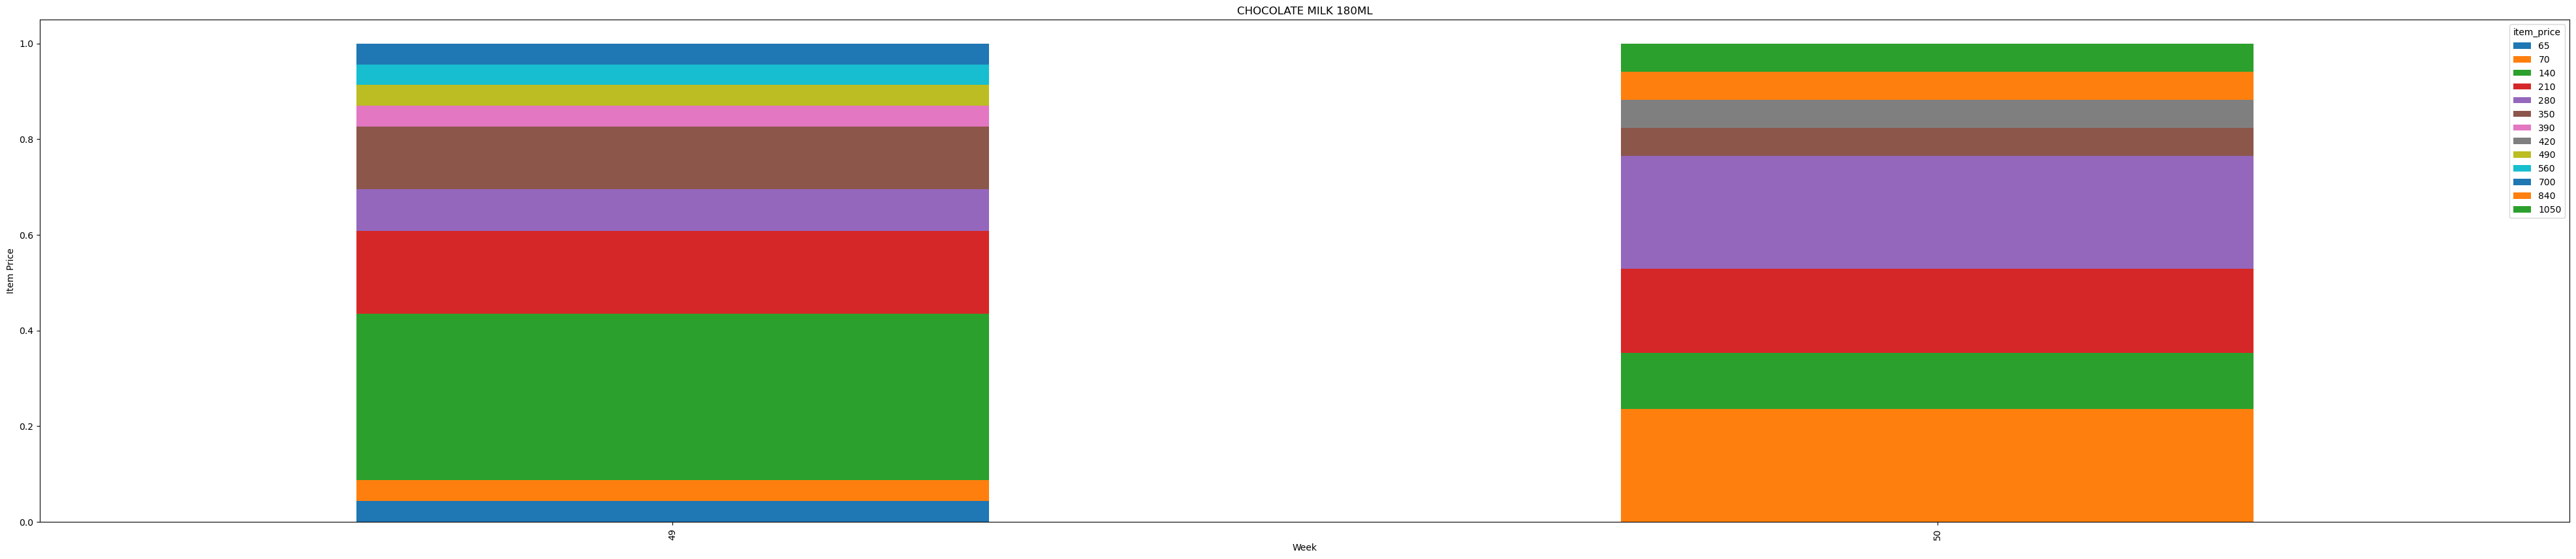

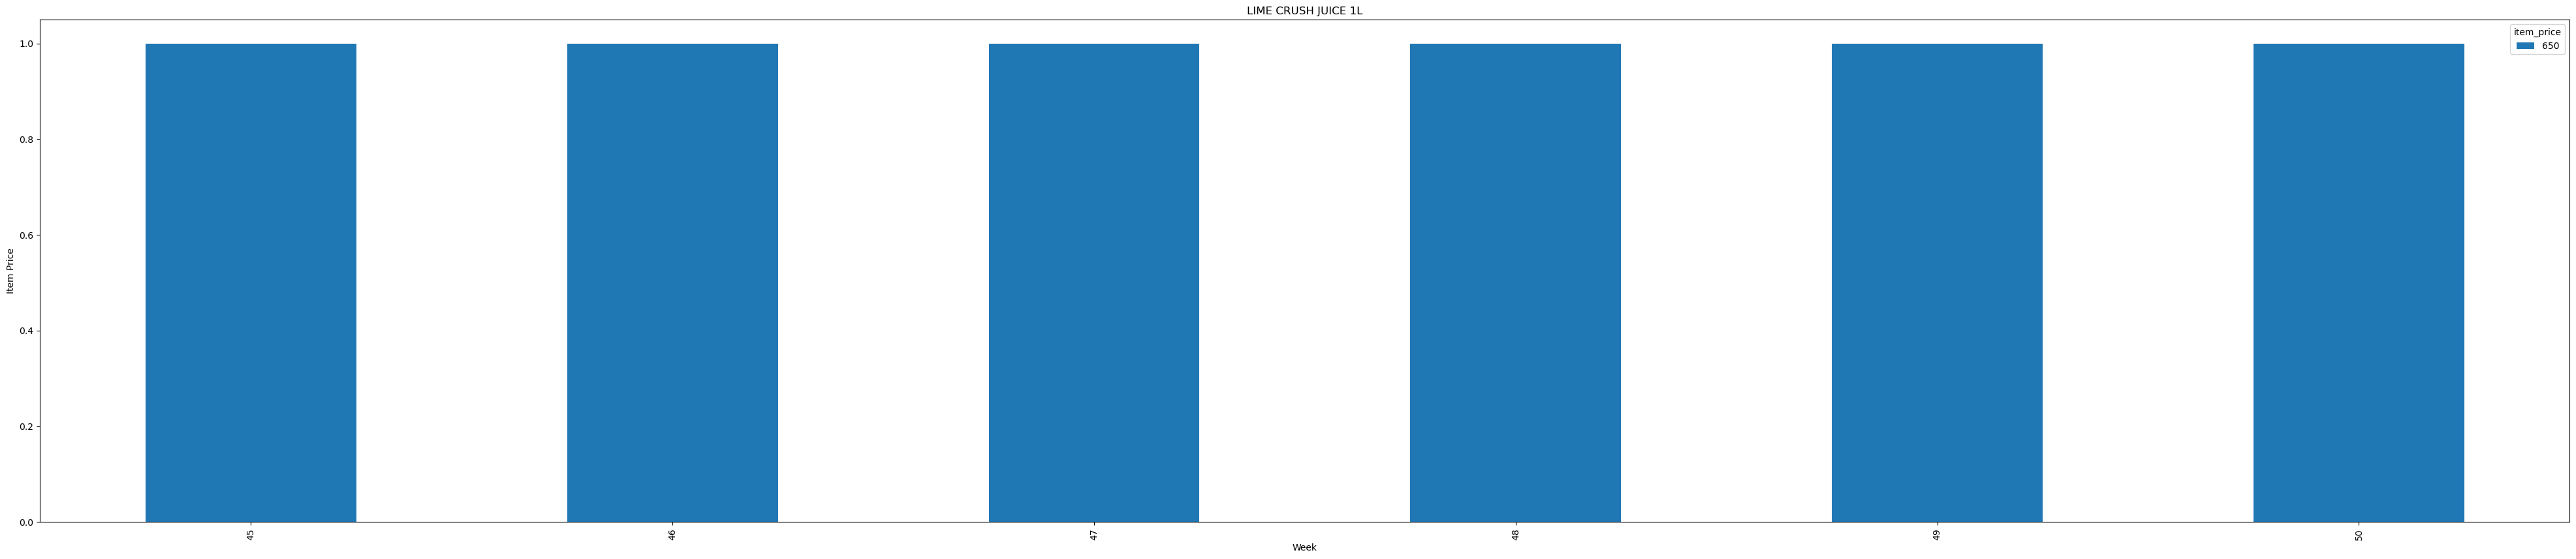

In [65]:
df2=df.dropna(subset=['item_description'], axis=0)
weekly_prices(df2['item_description'].unique())

quantity ekat ekat ekka price value wala count eka (Normalized)

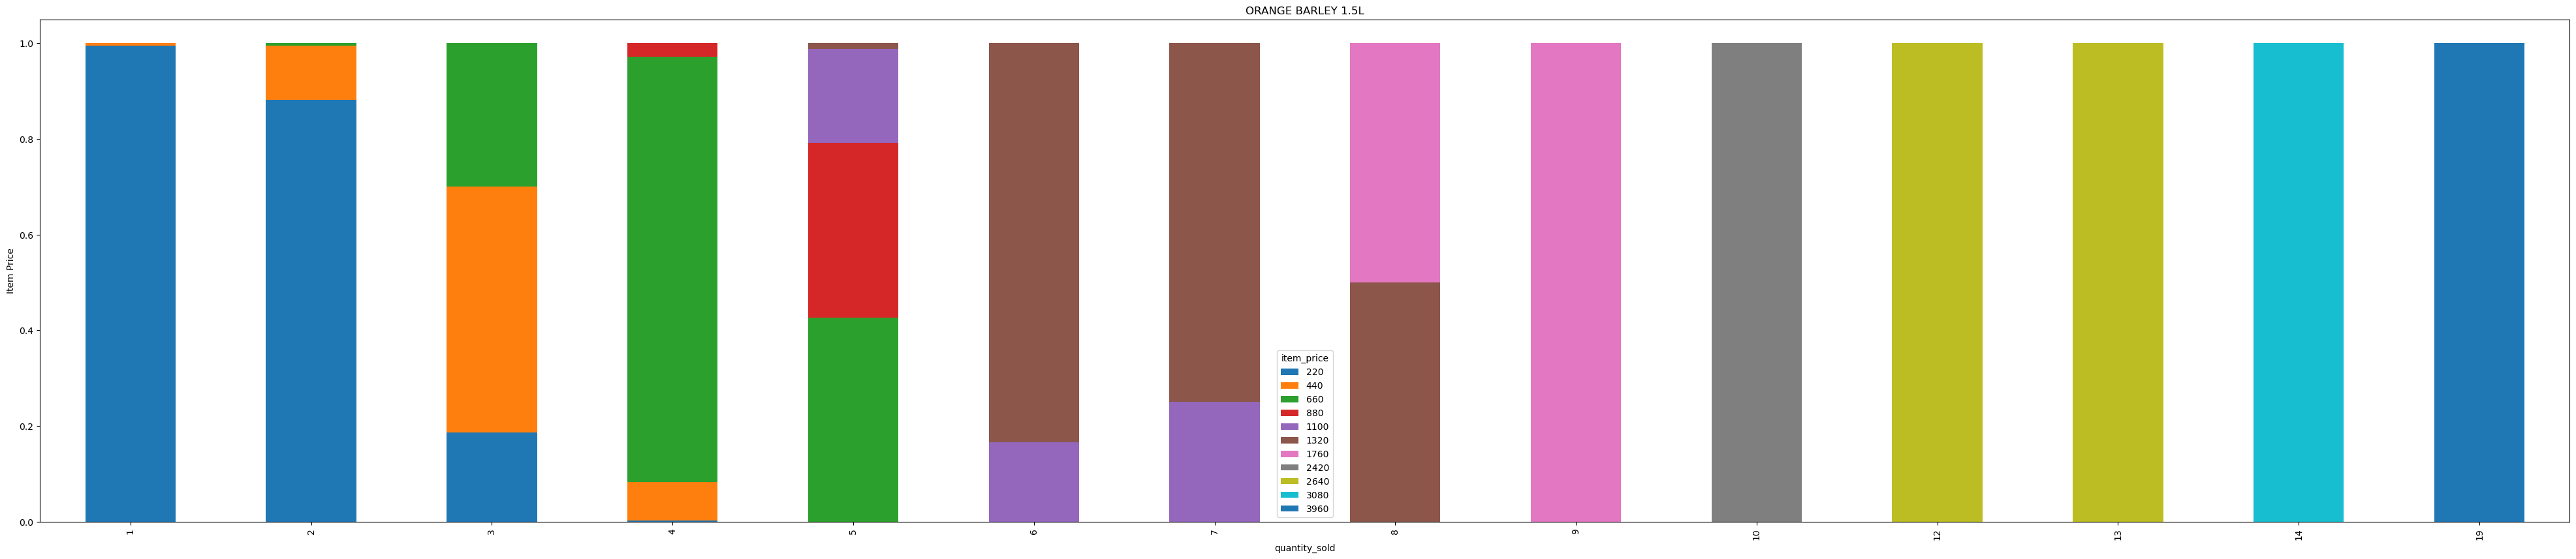

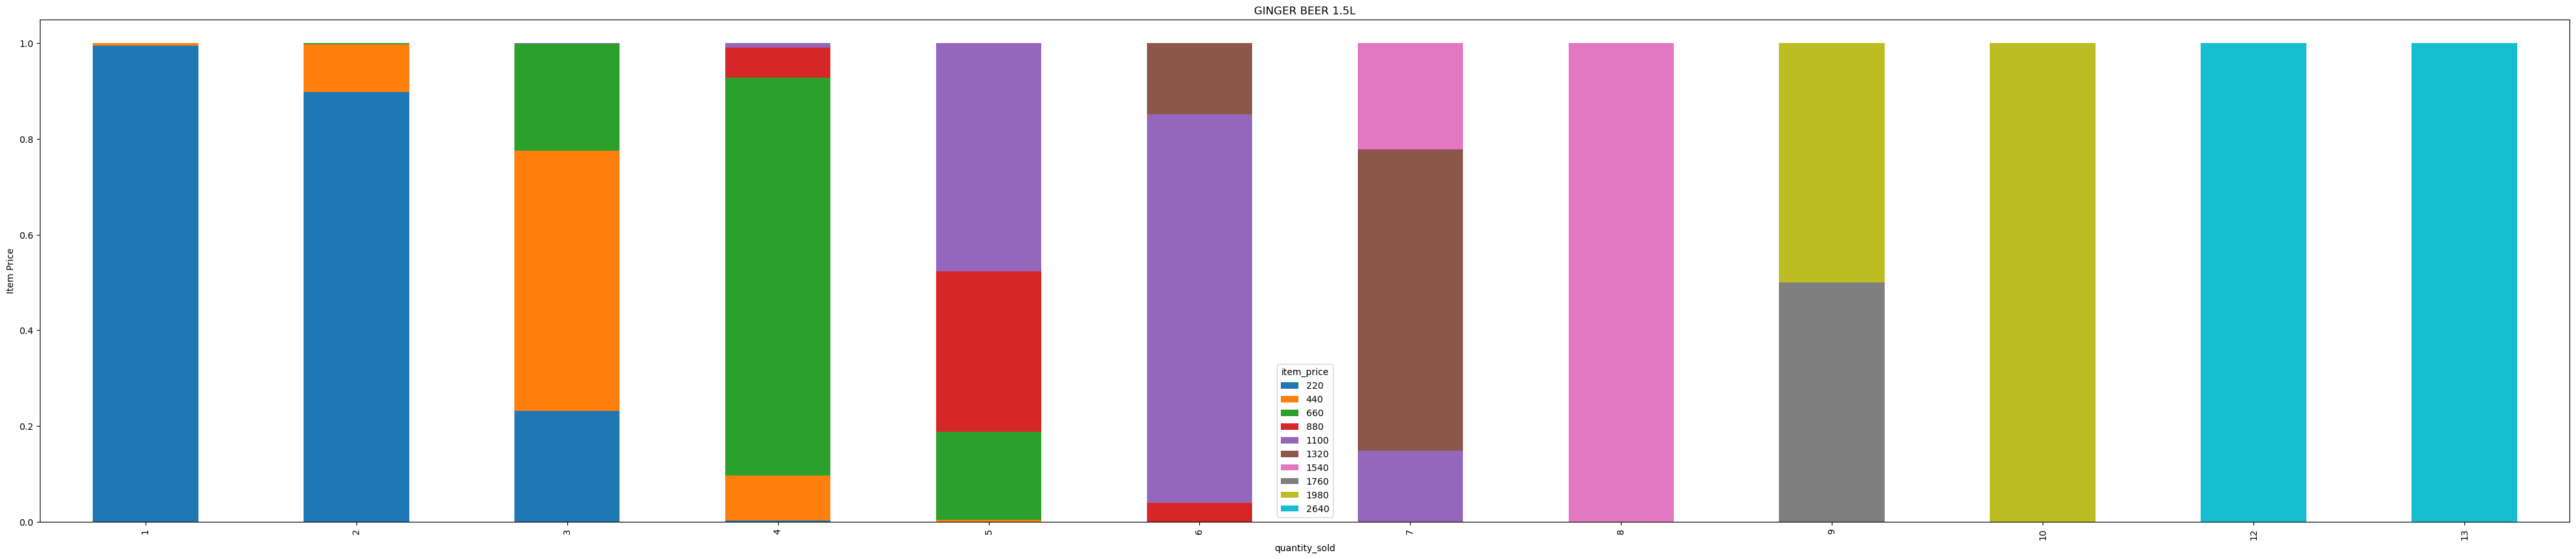

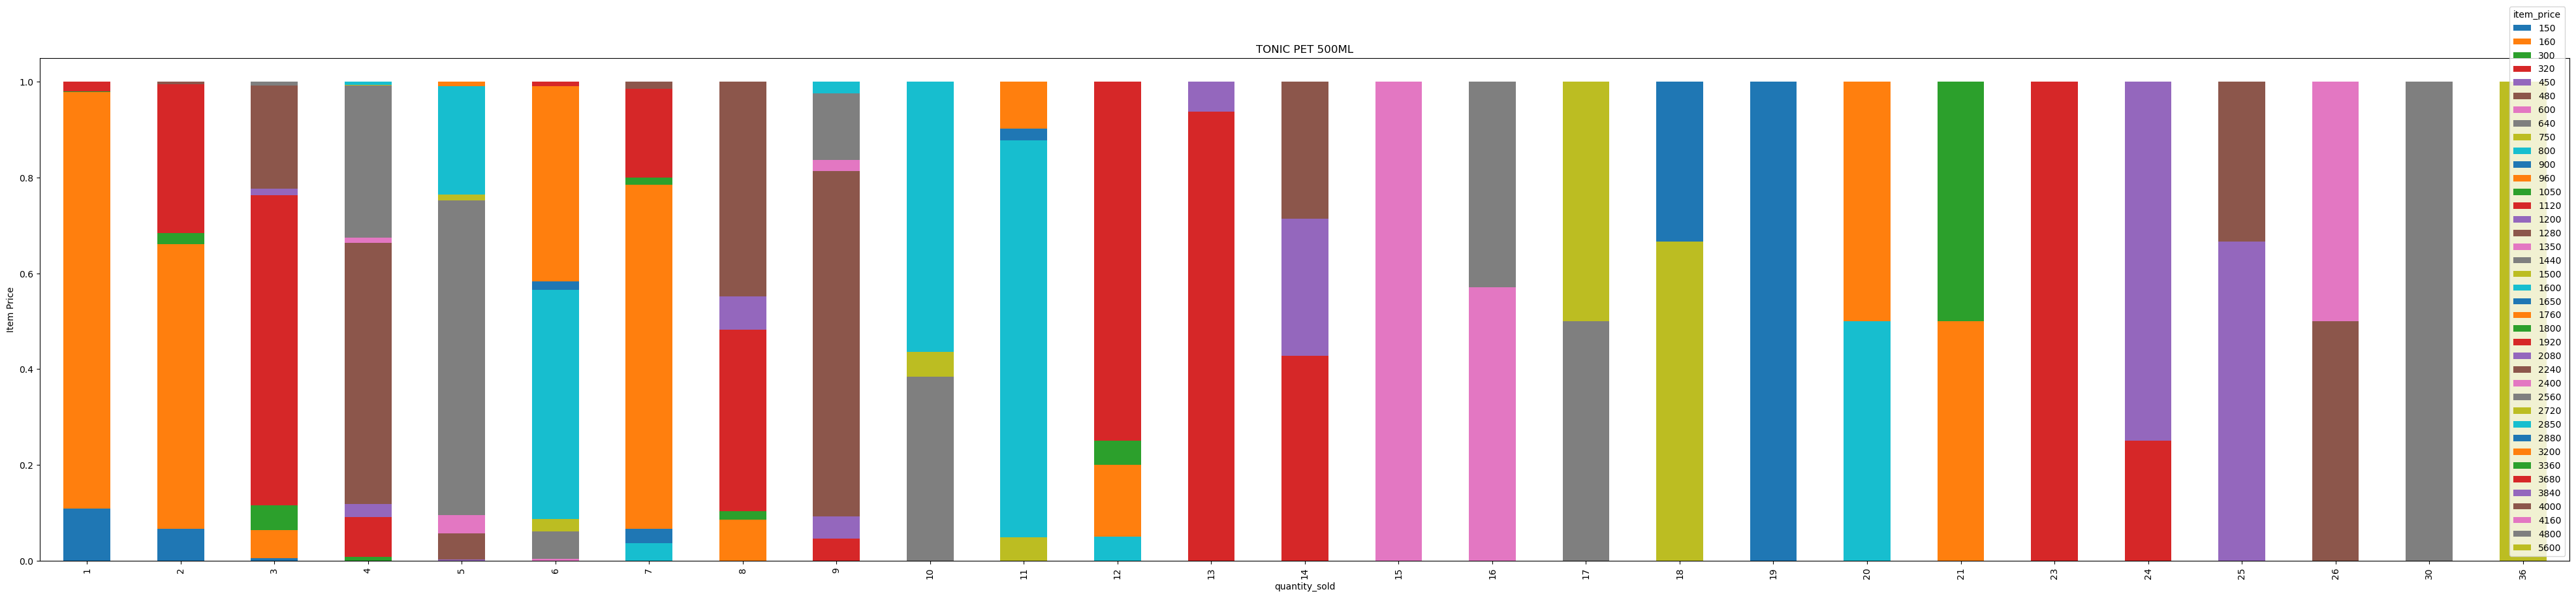

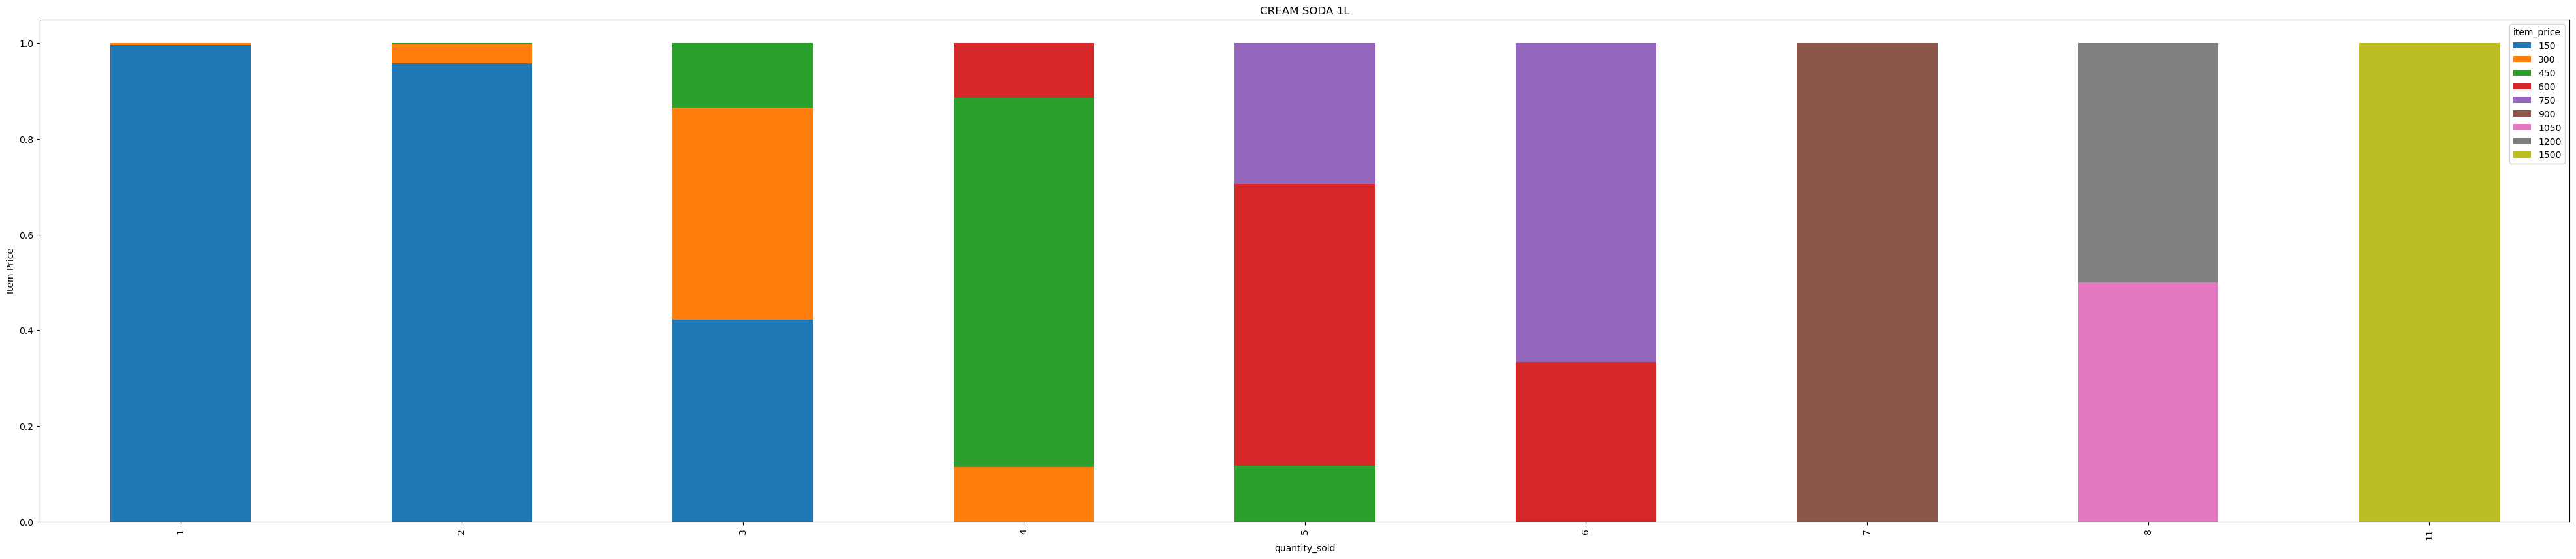

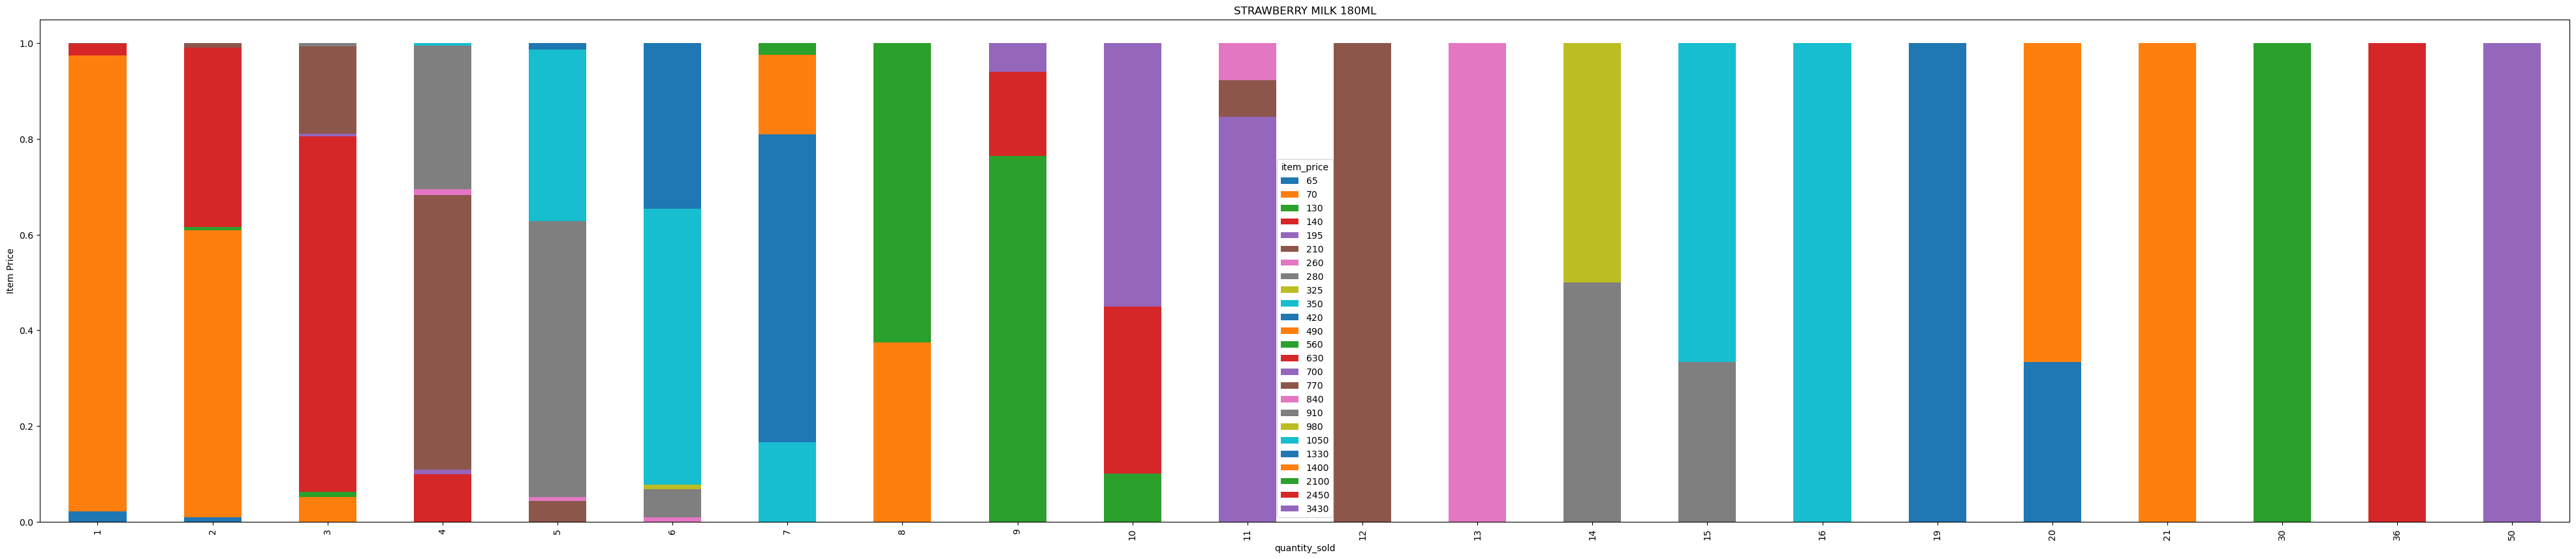

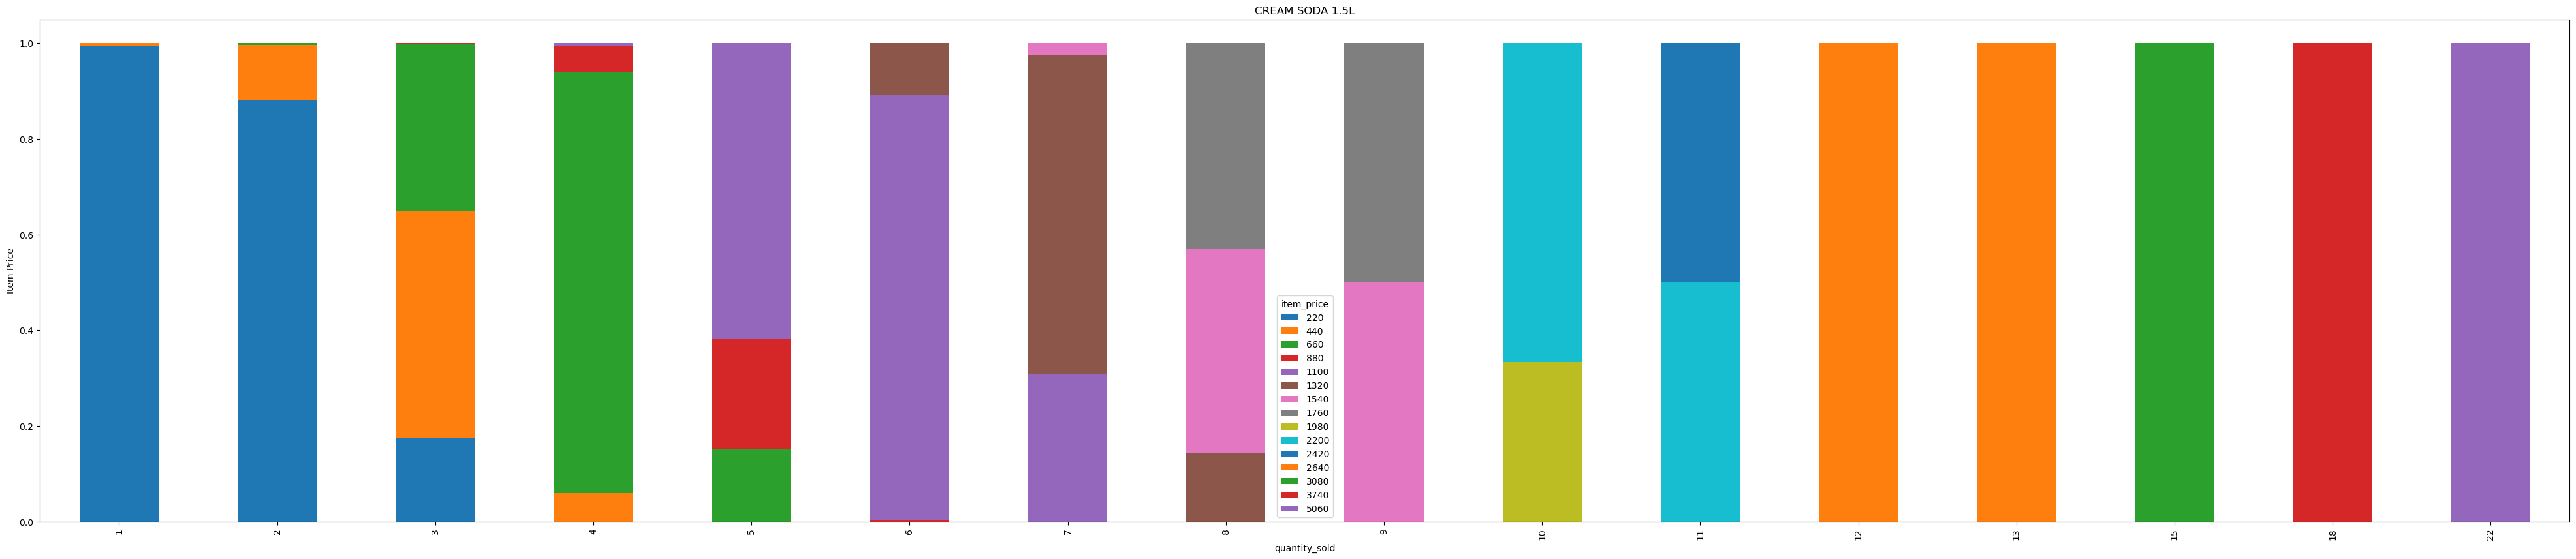

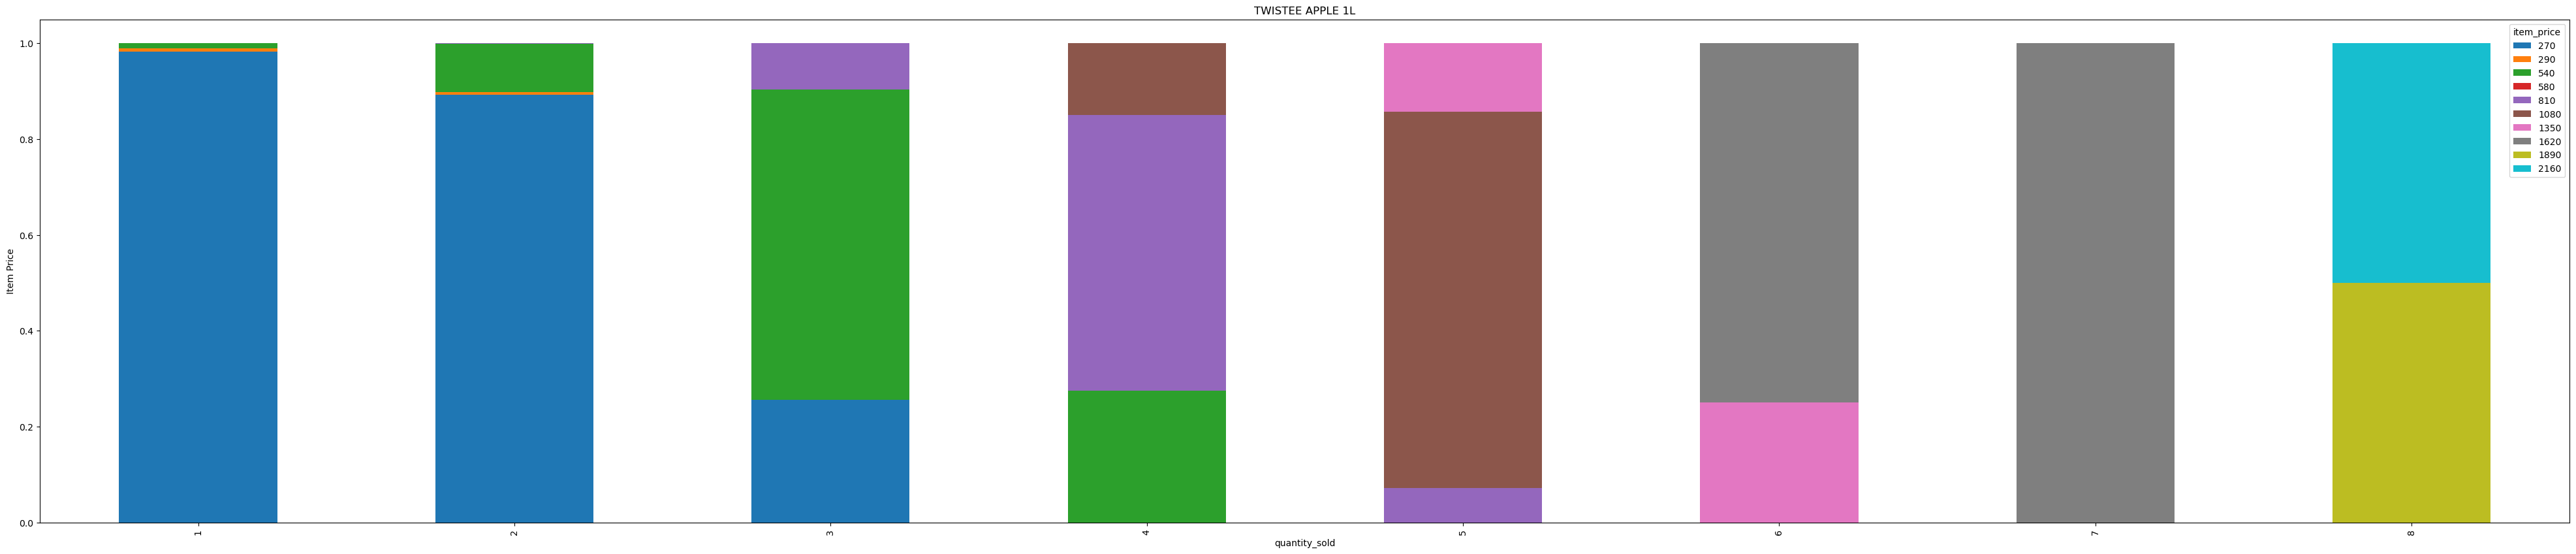

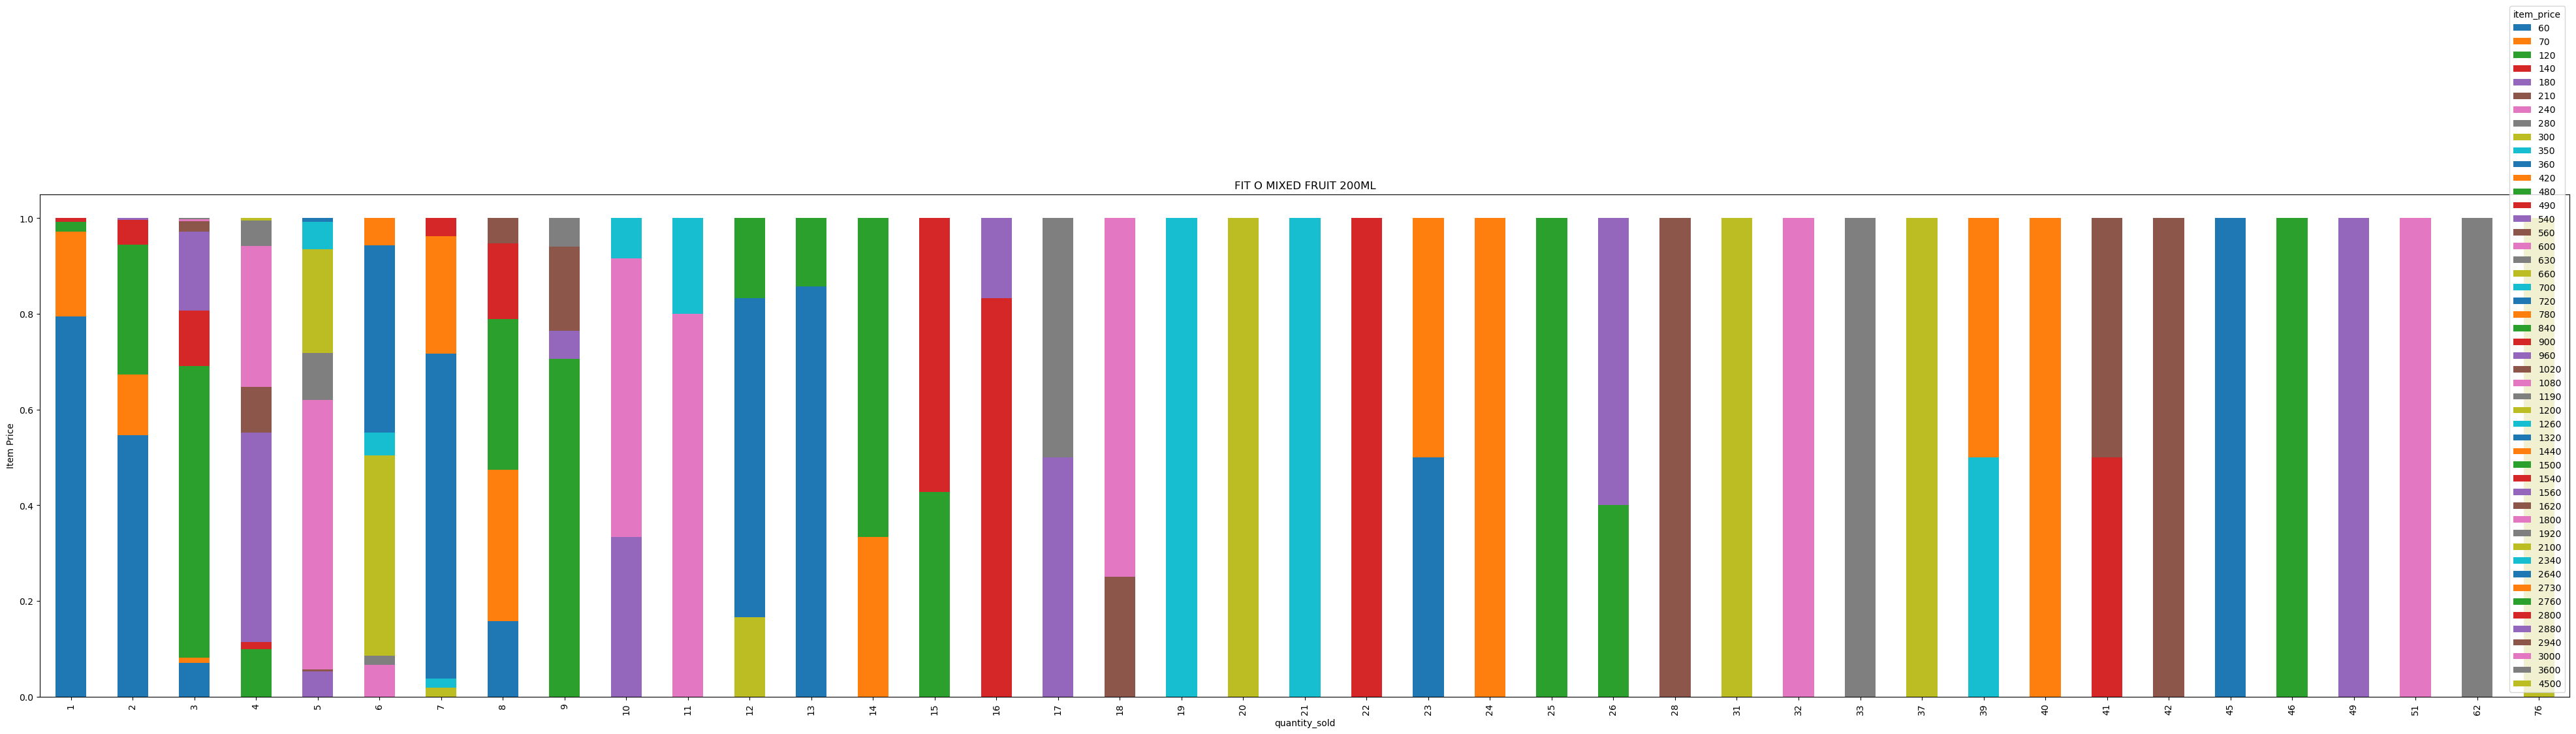

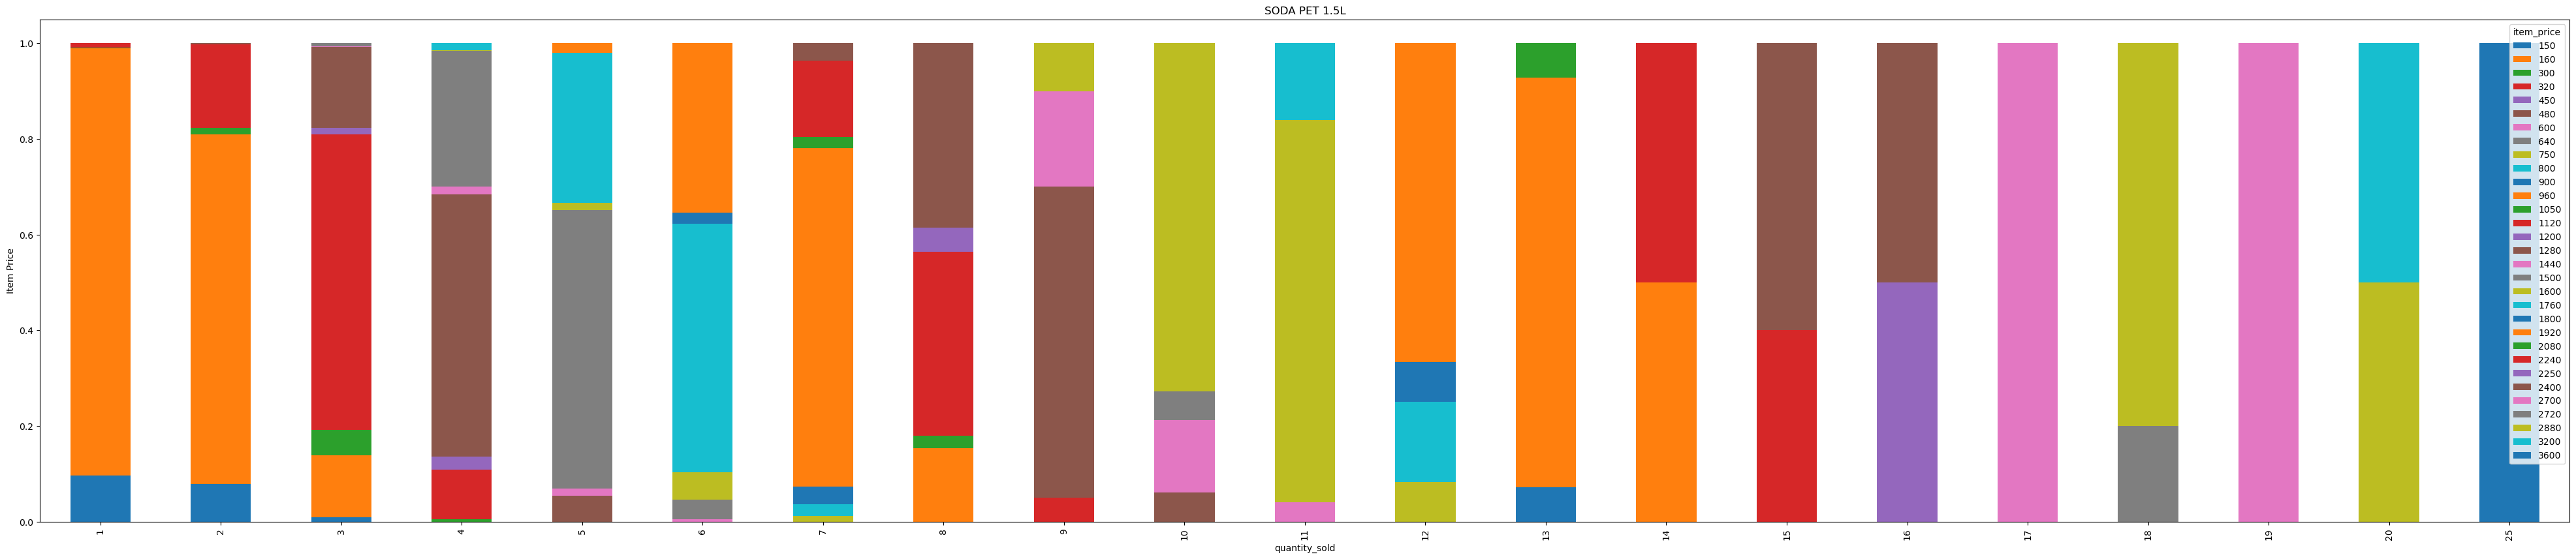

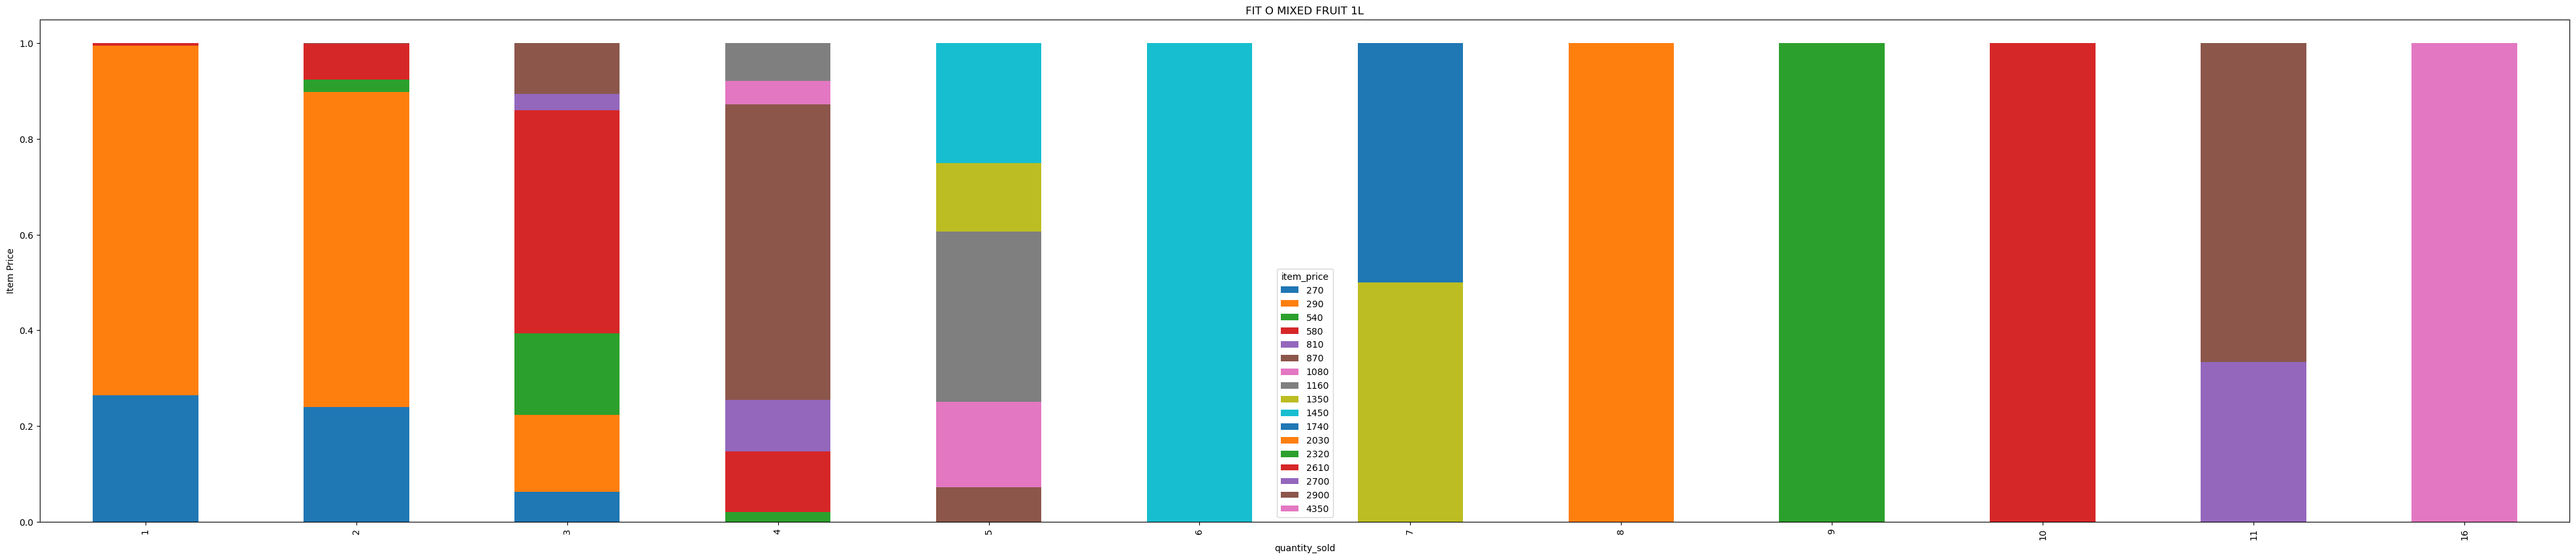

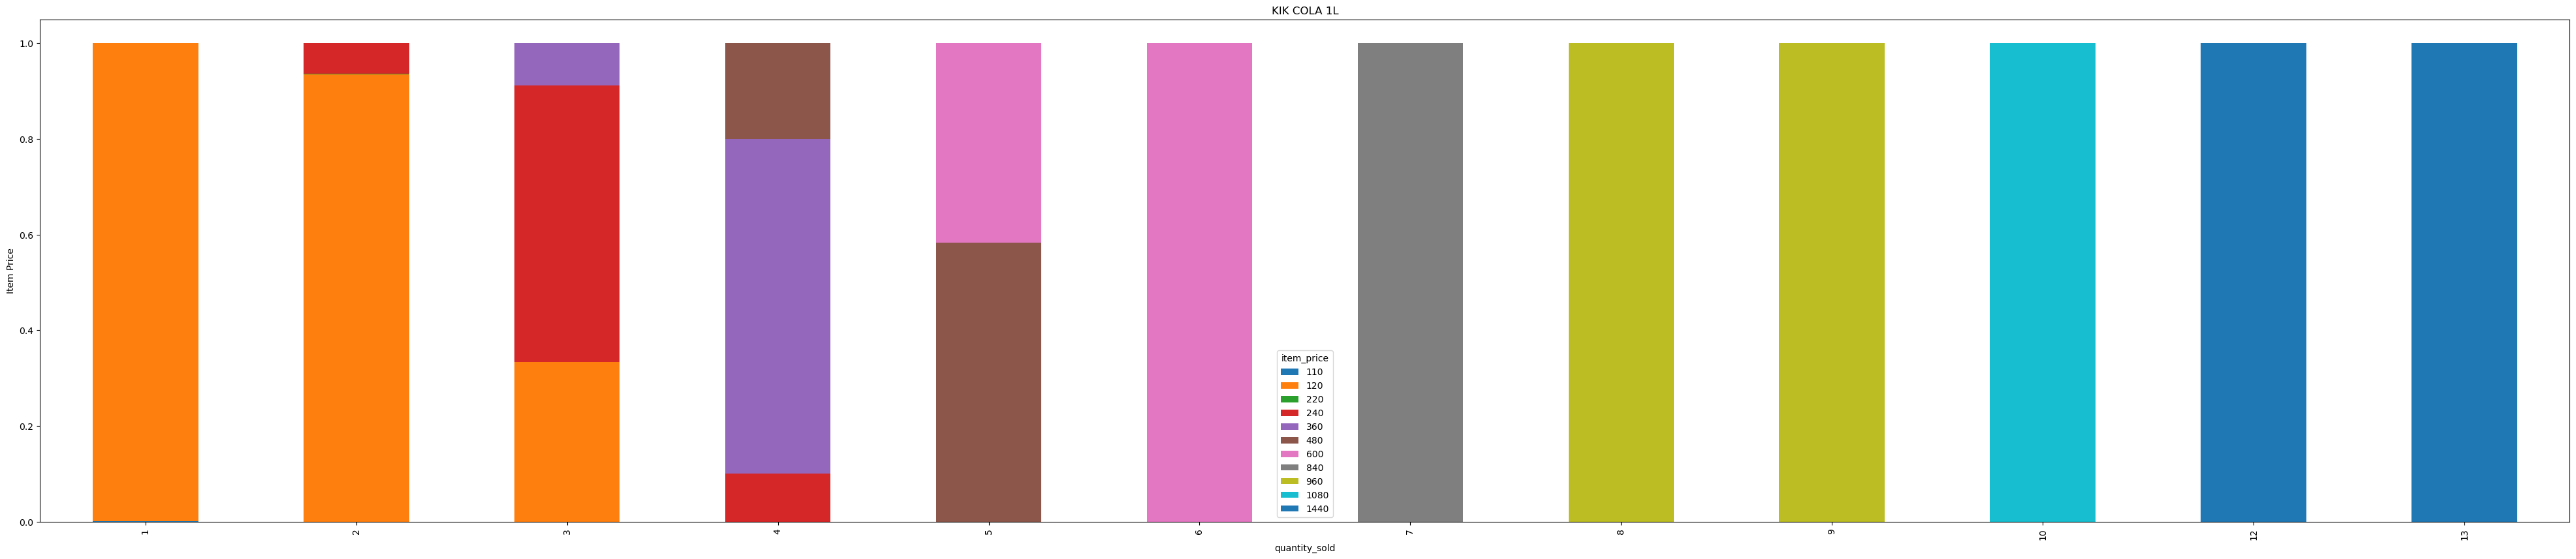

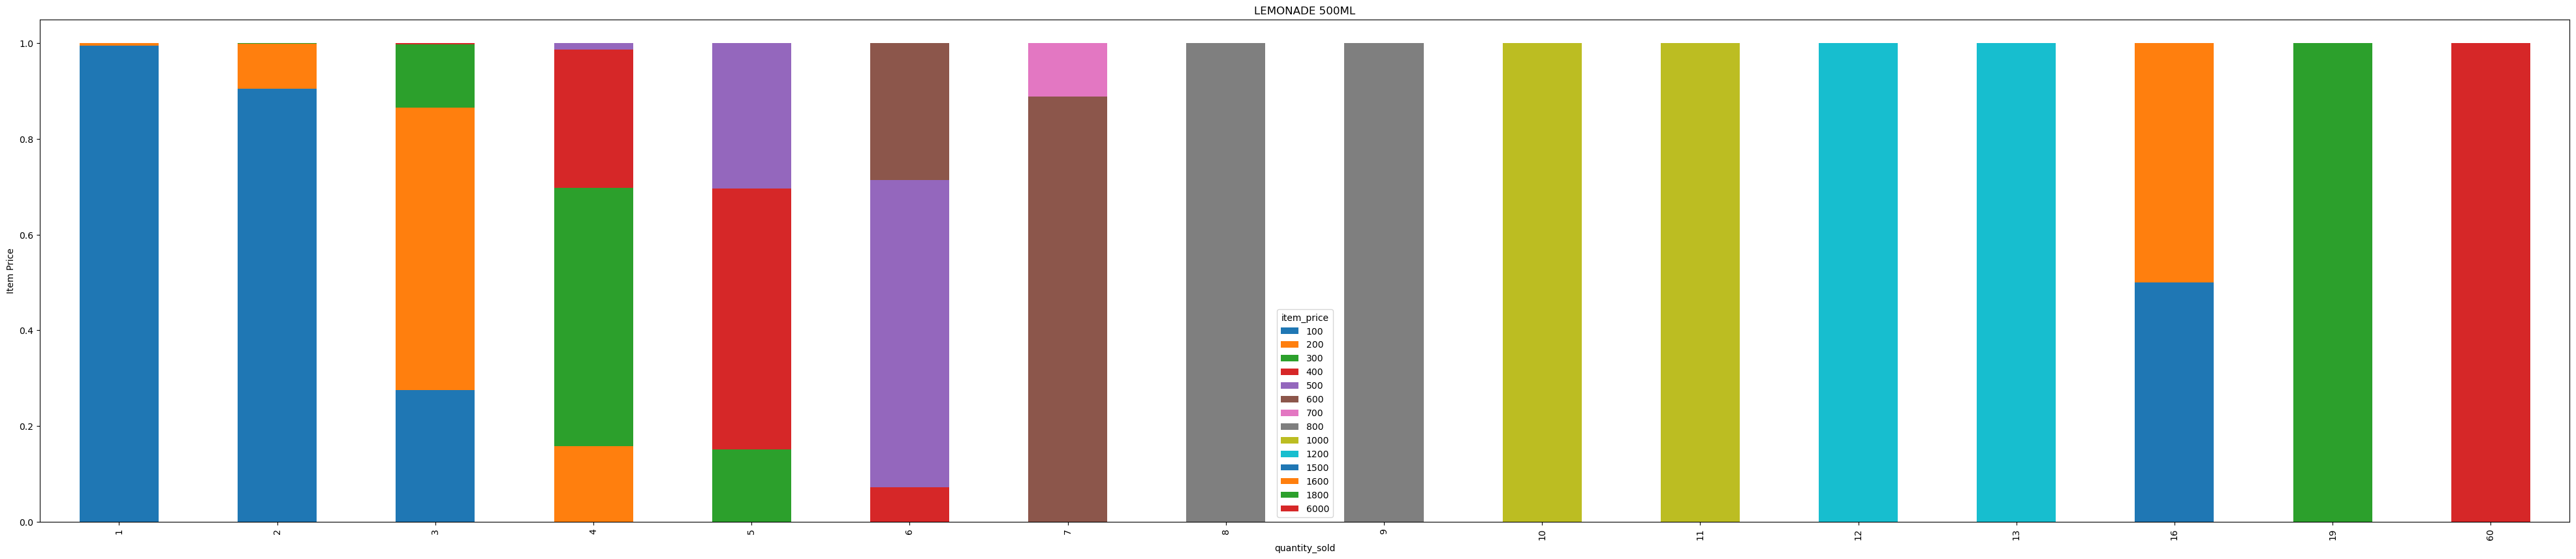

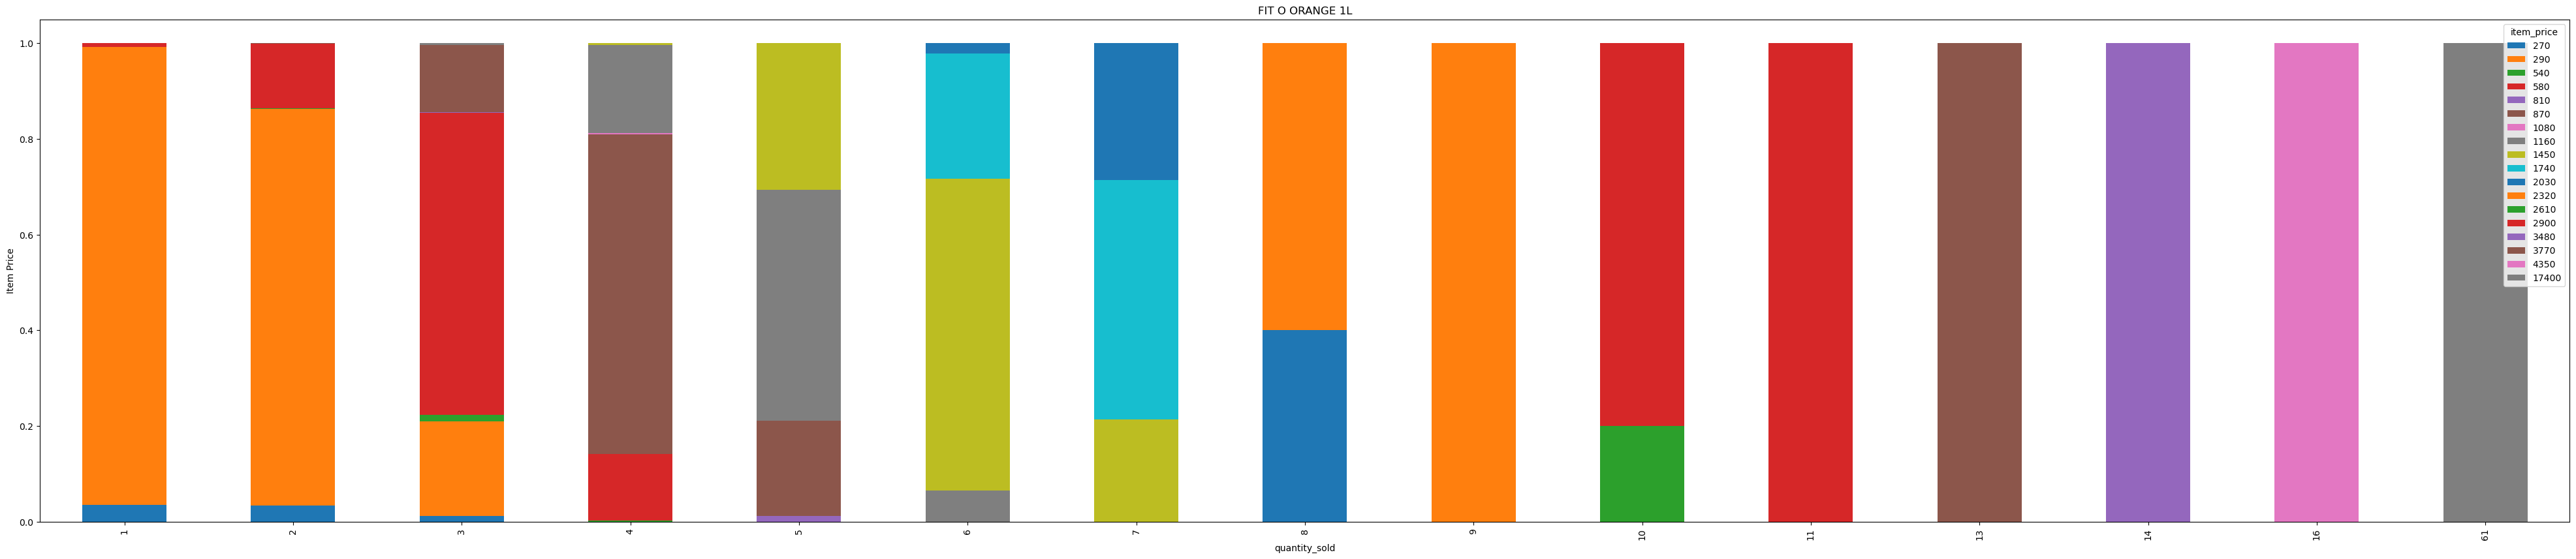

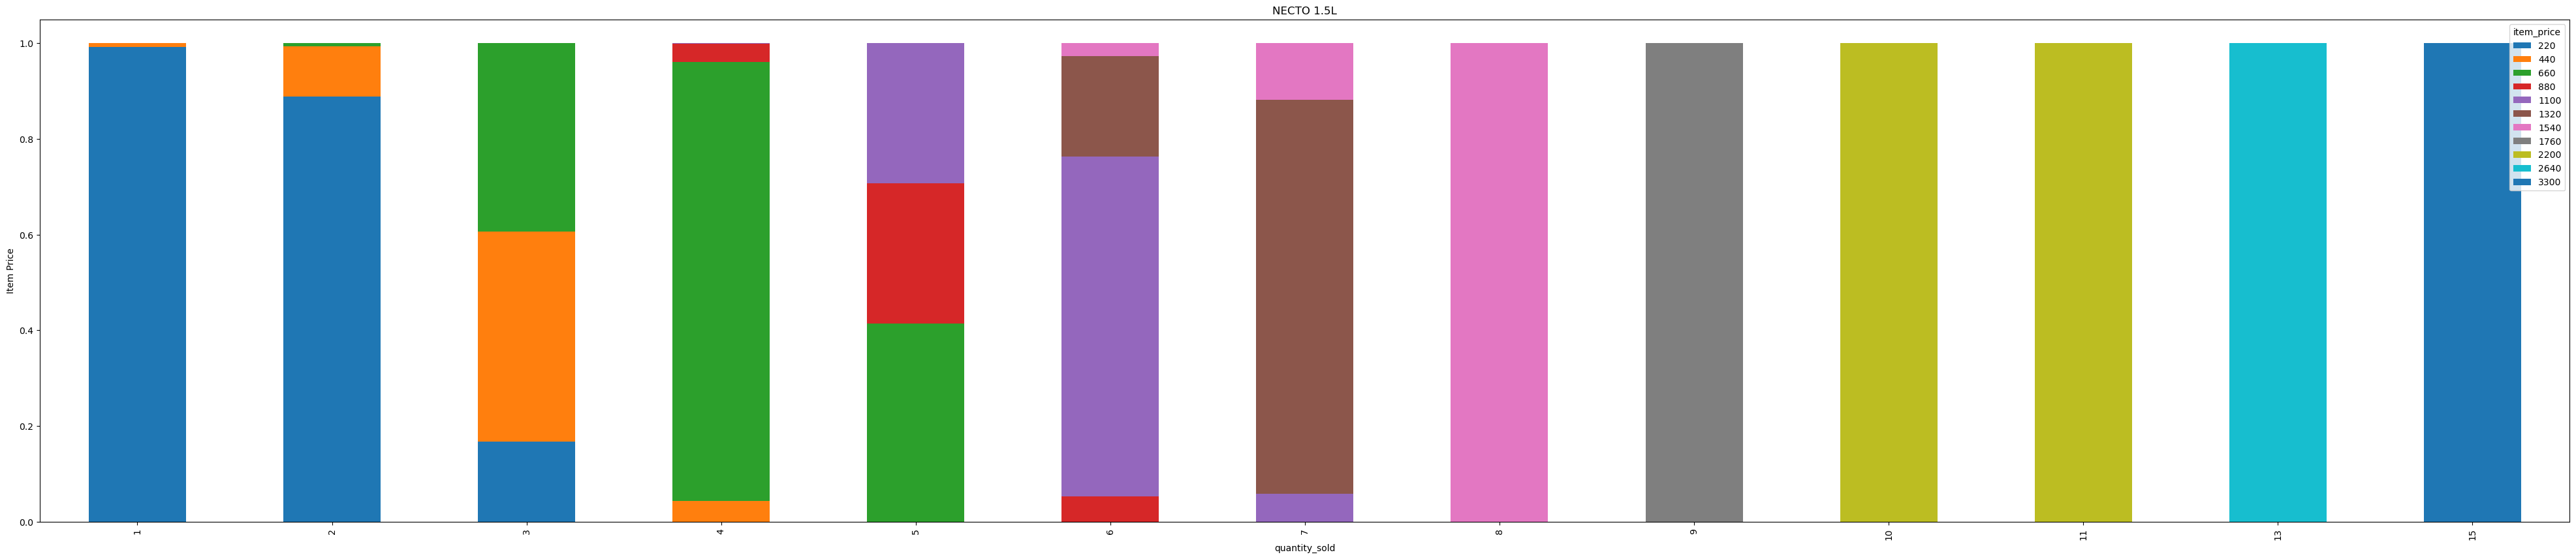

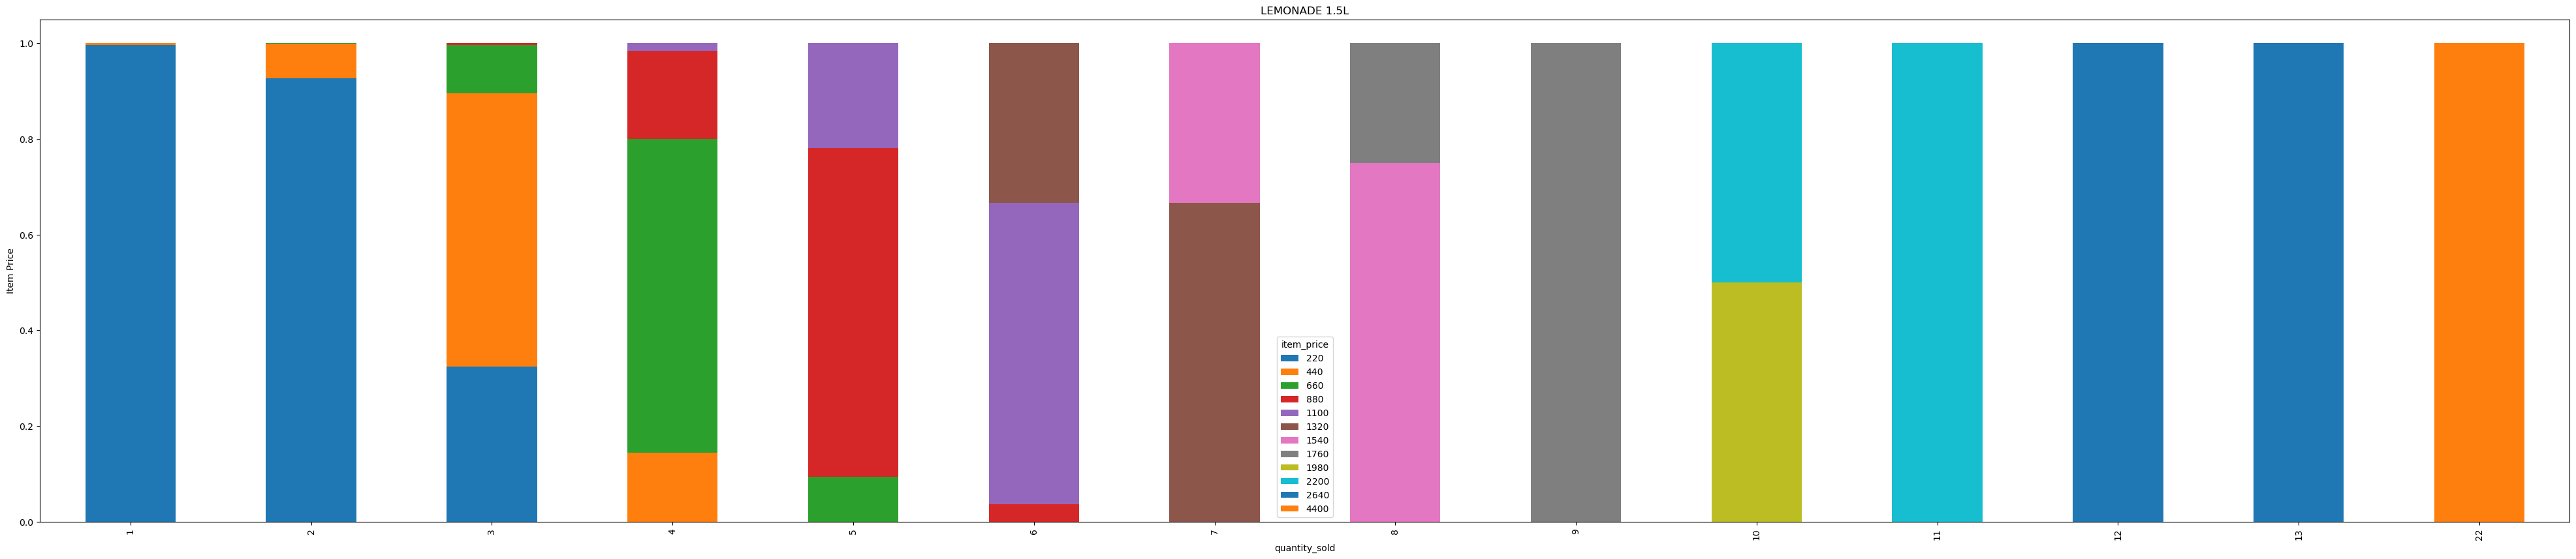

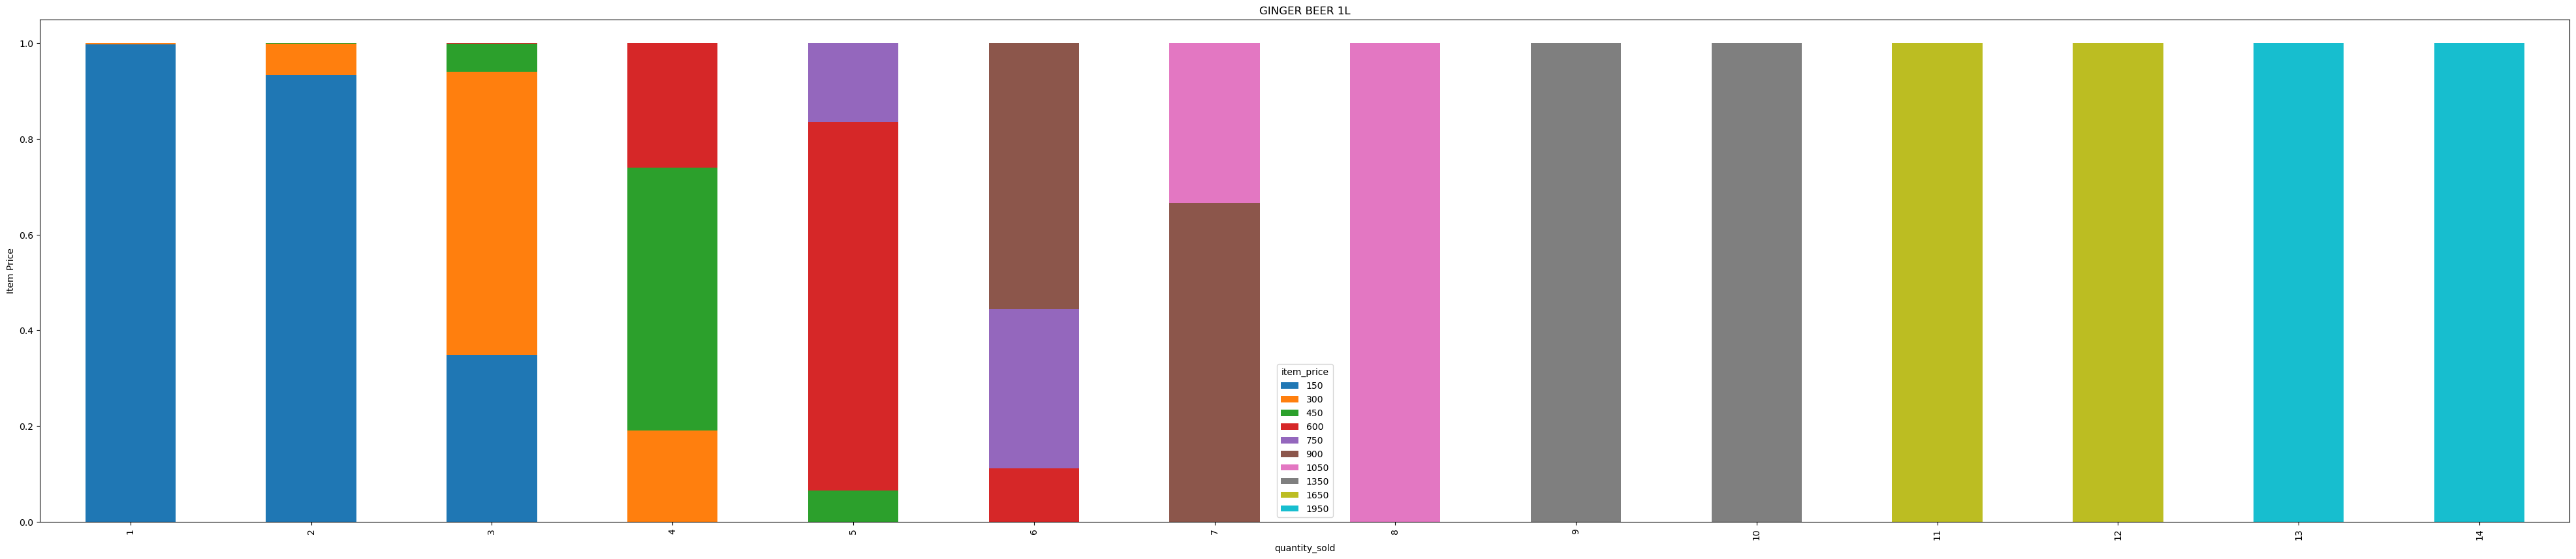

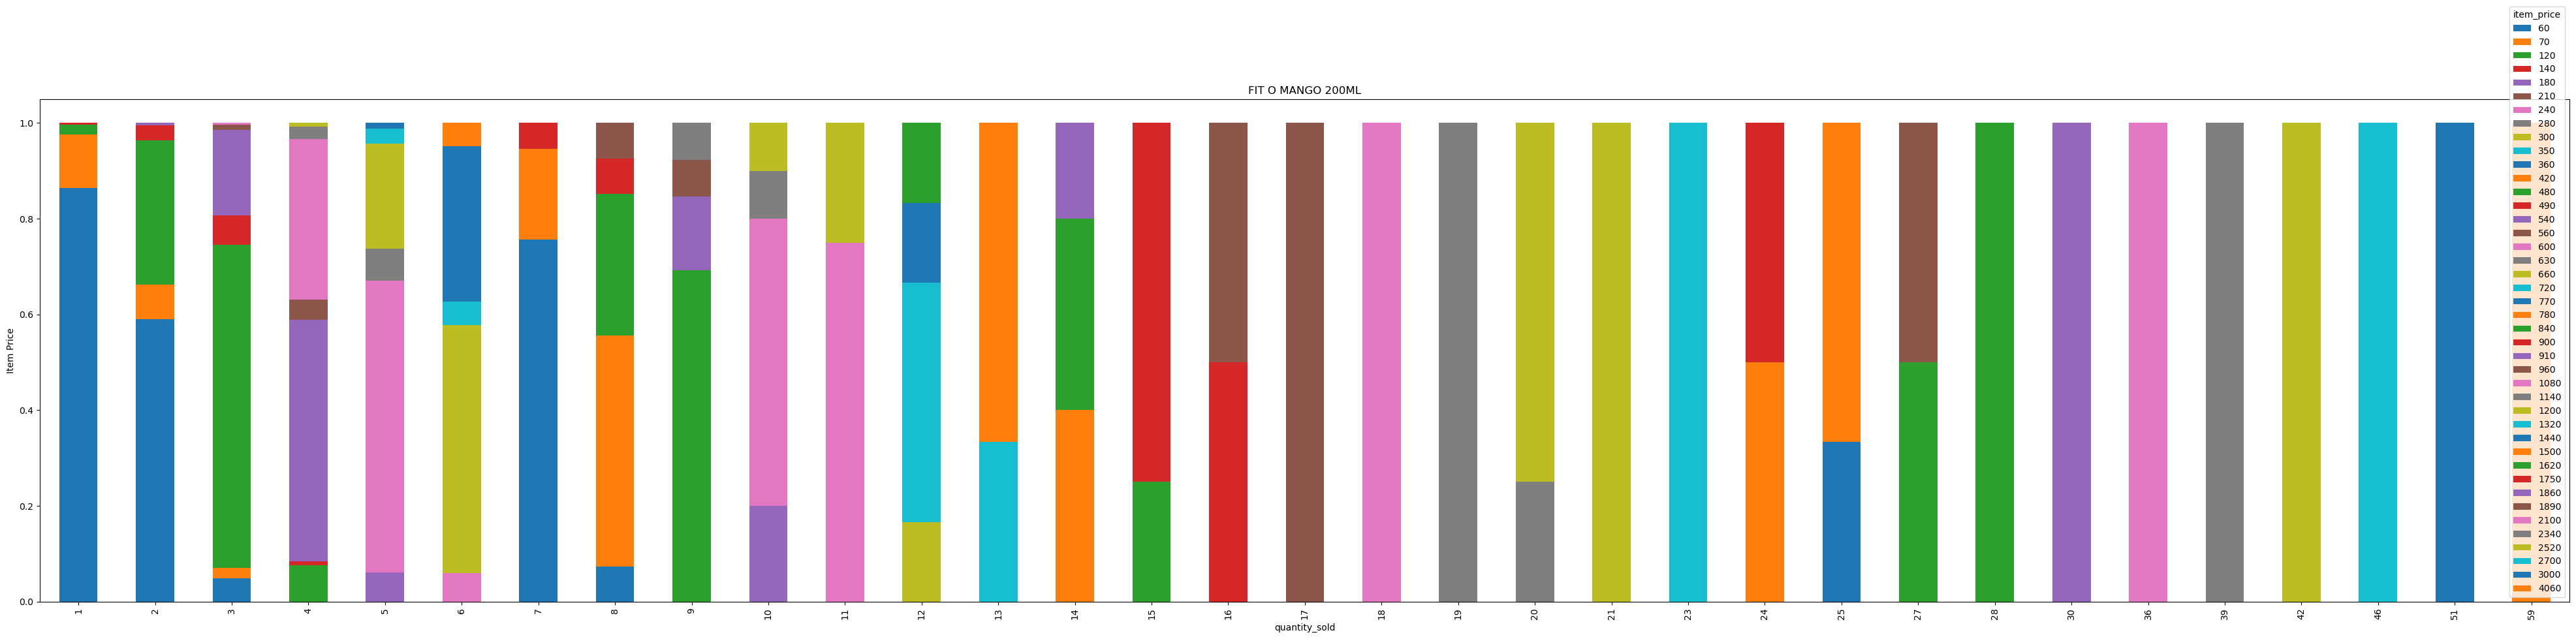

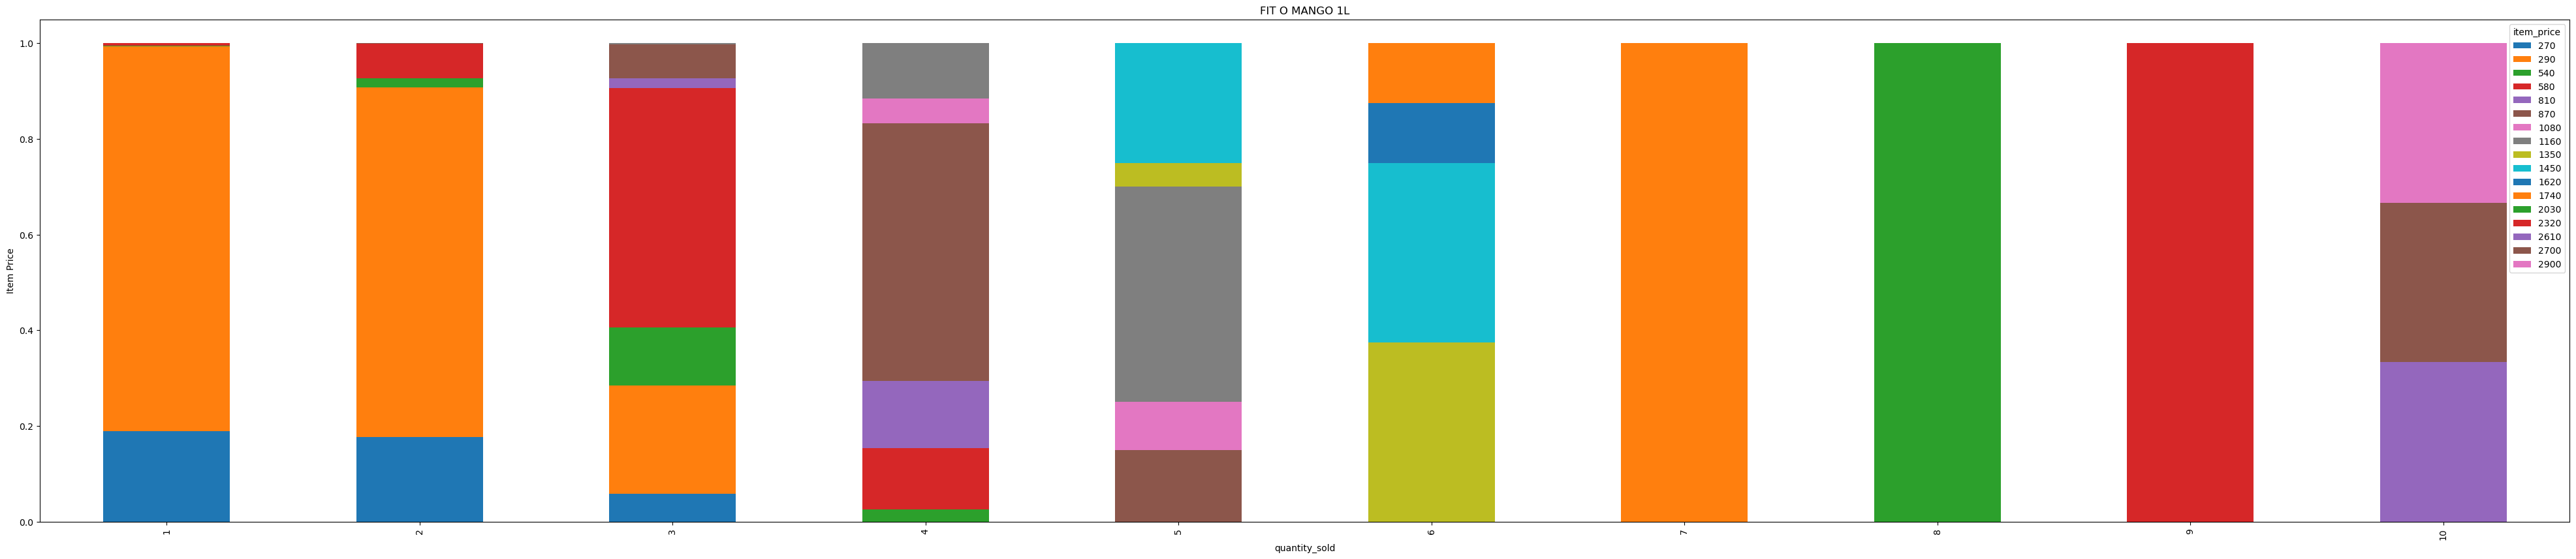

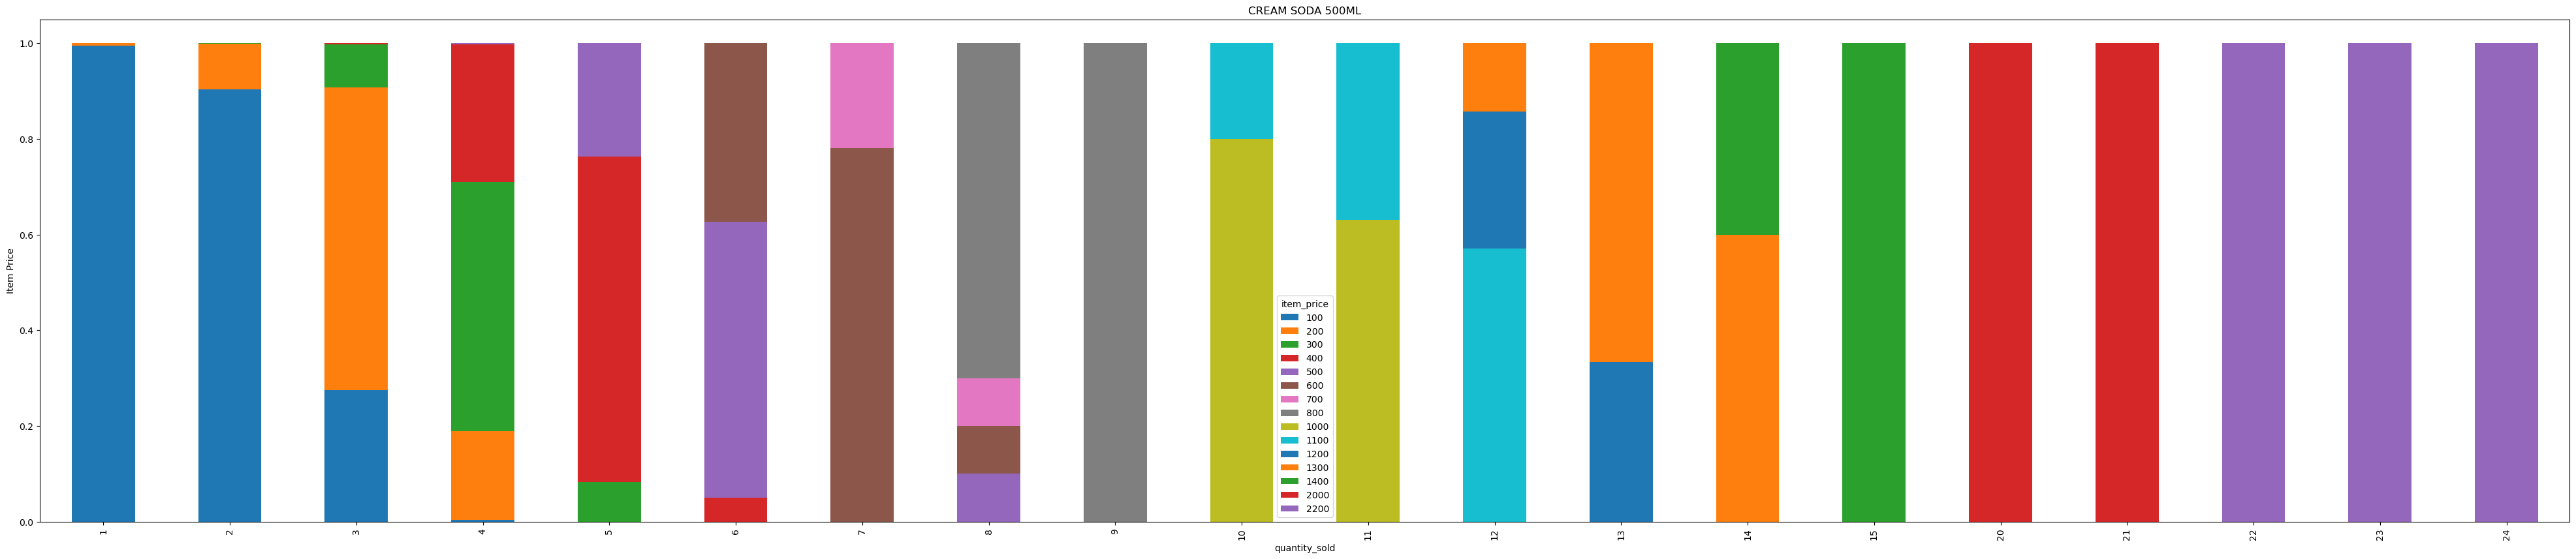

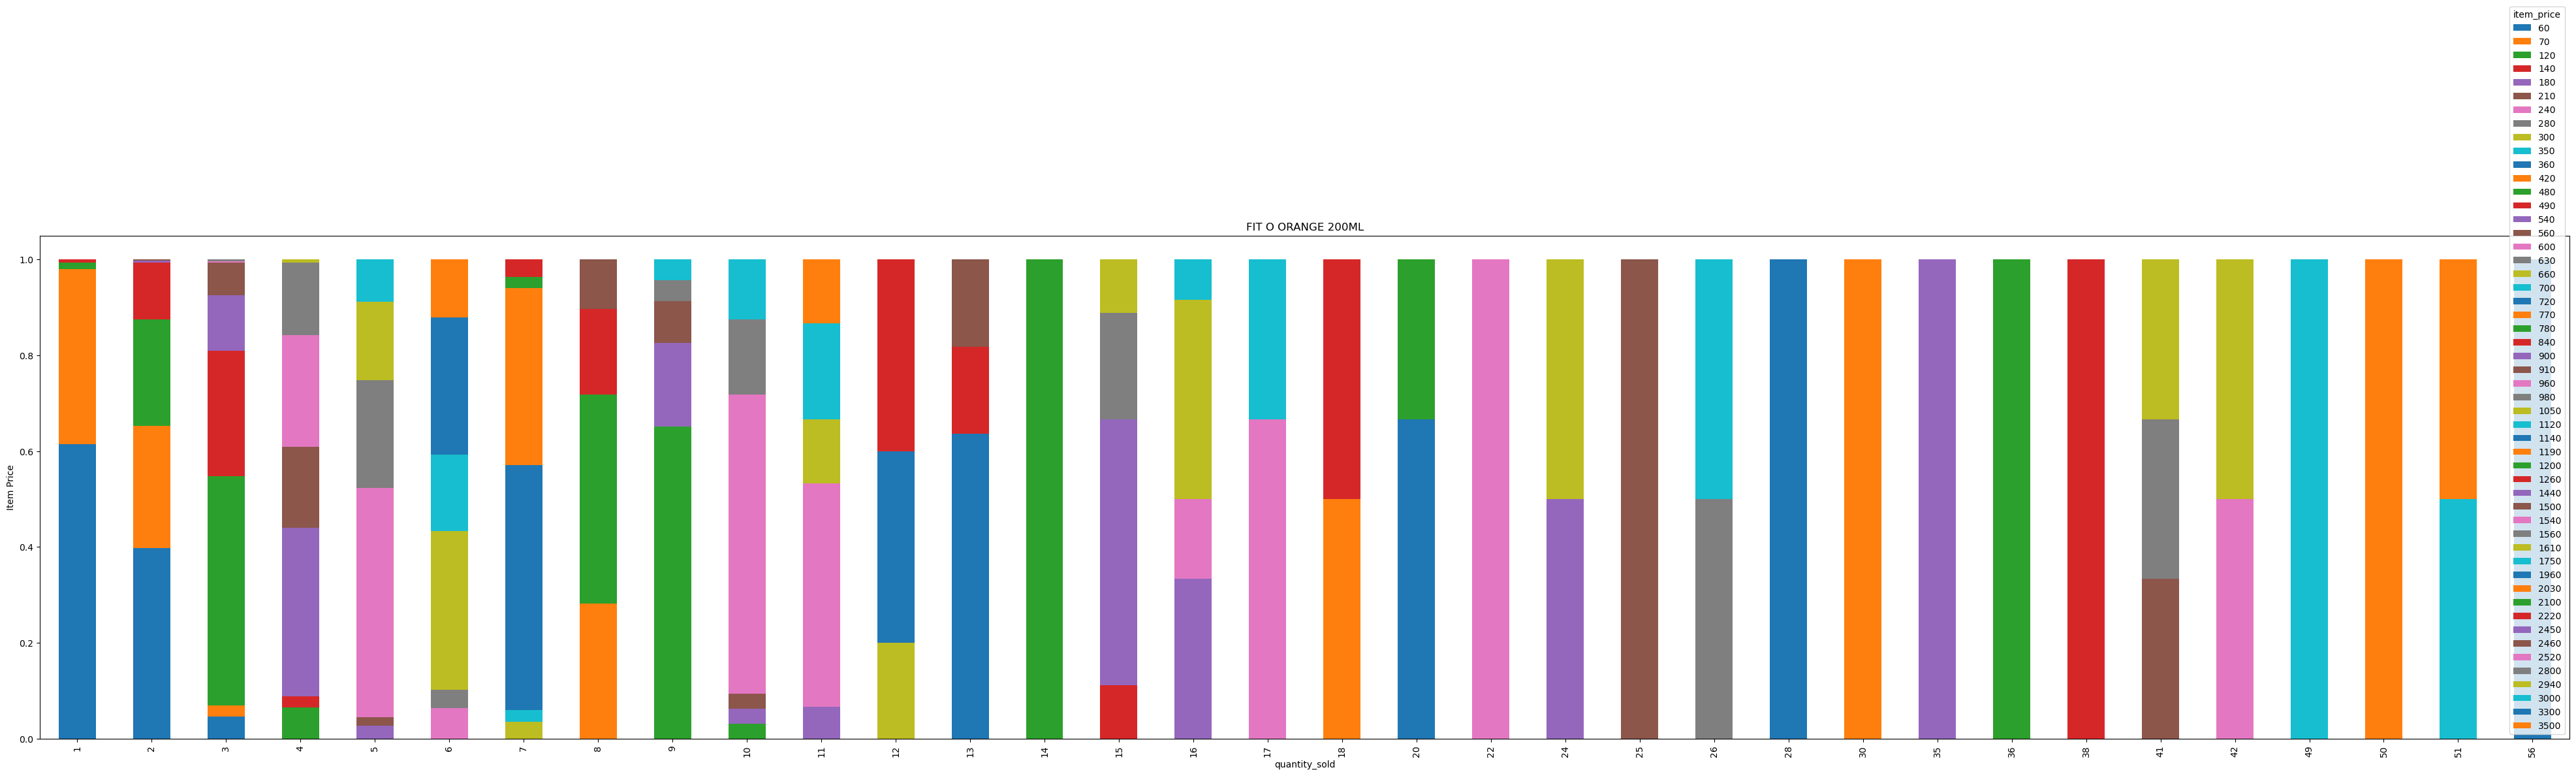

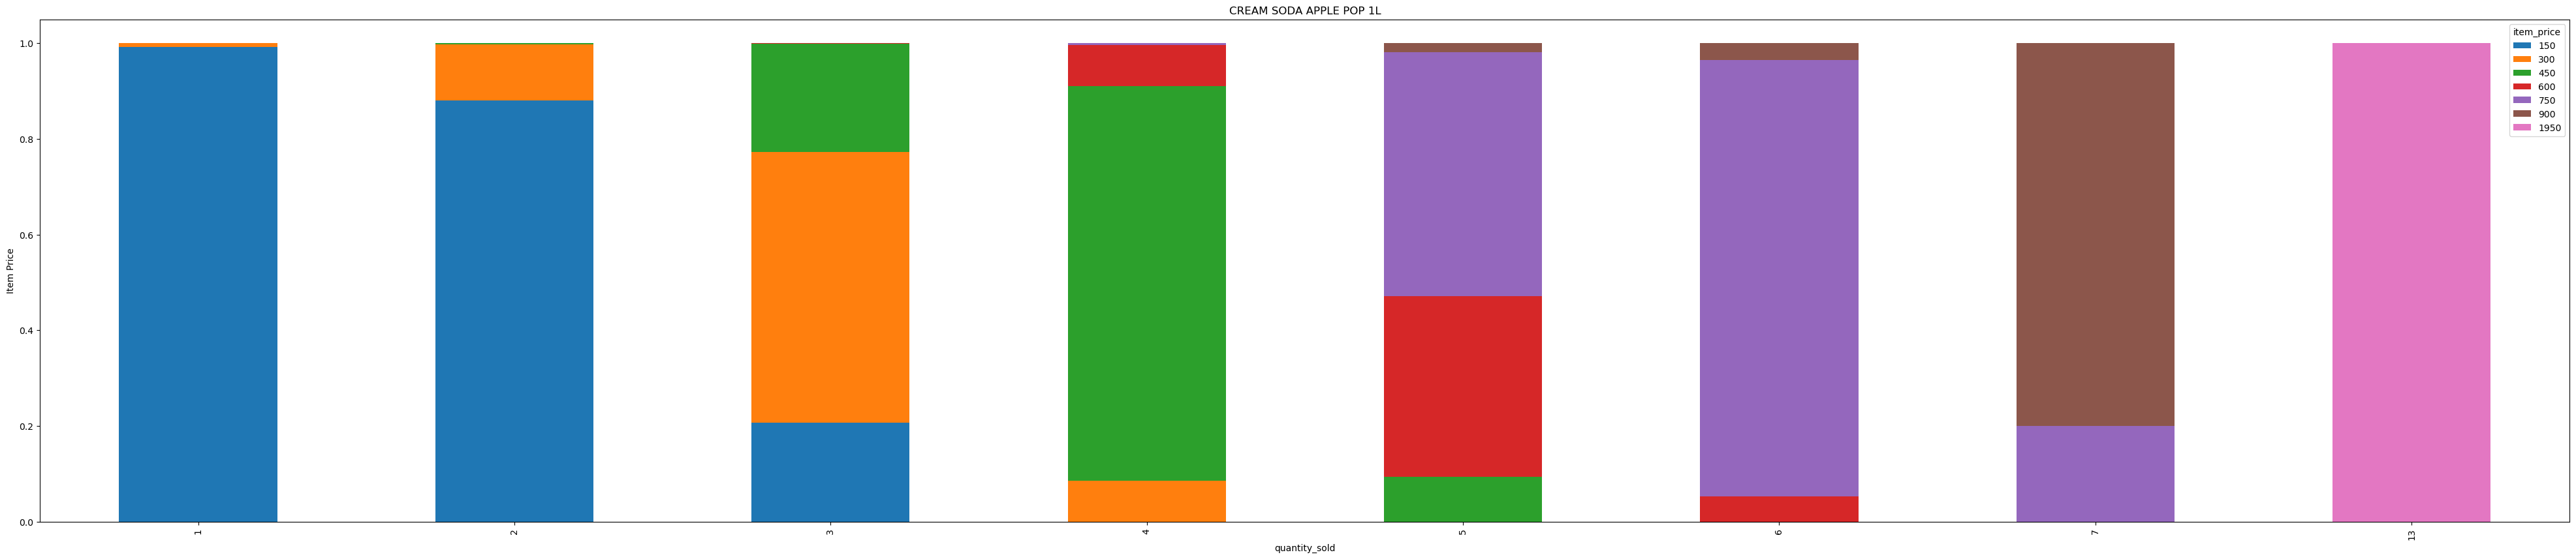

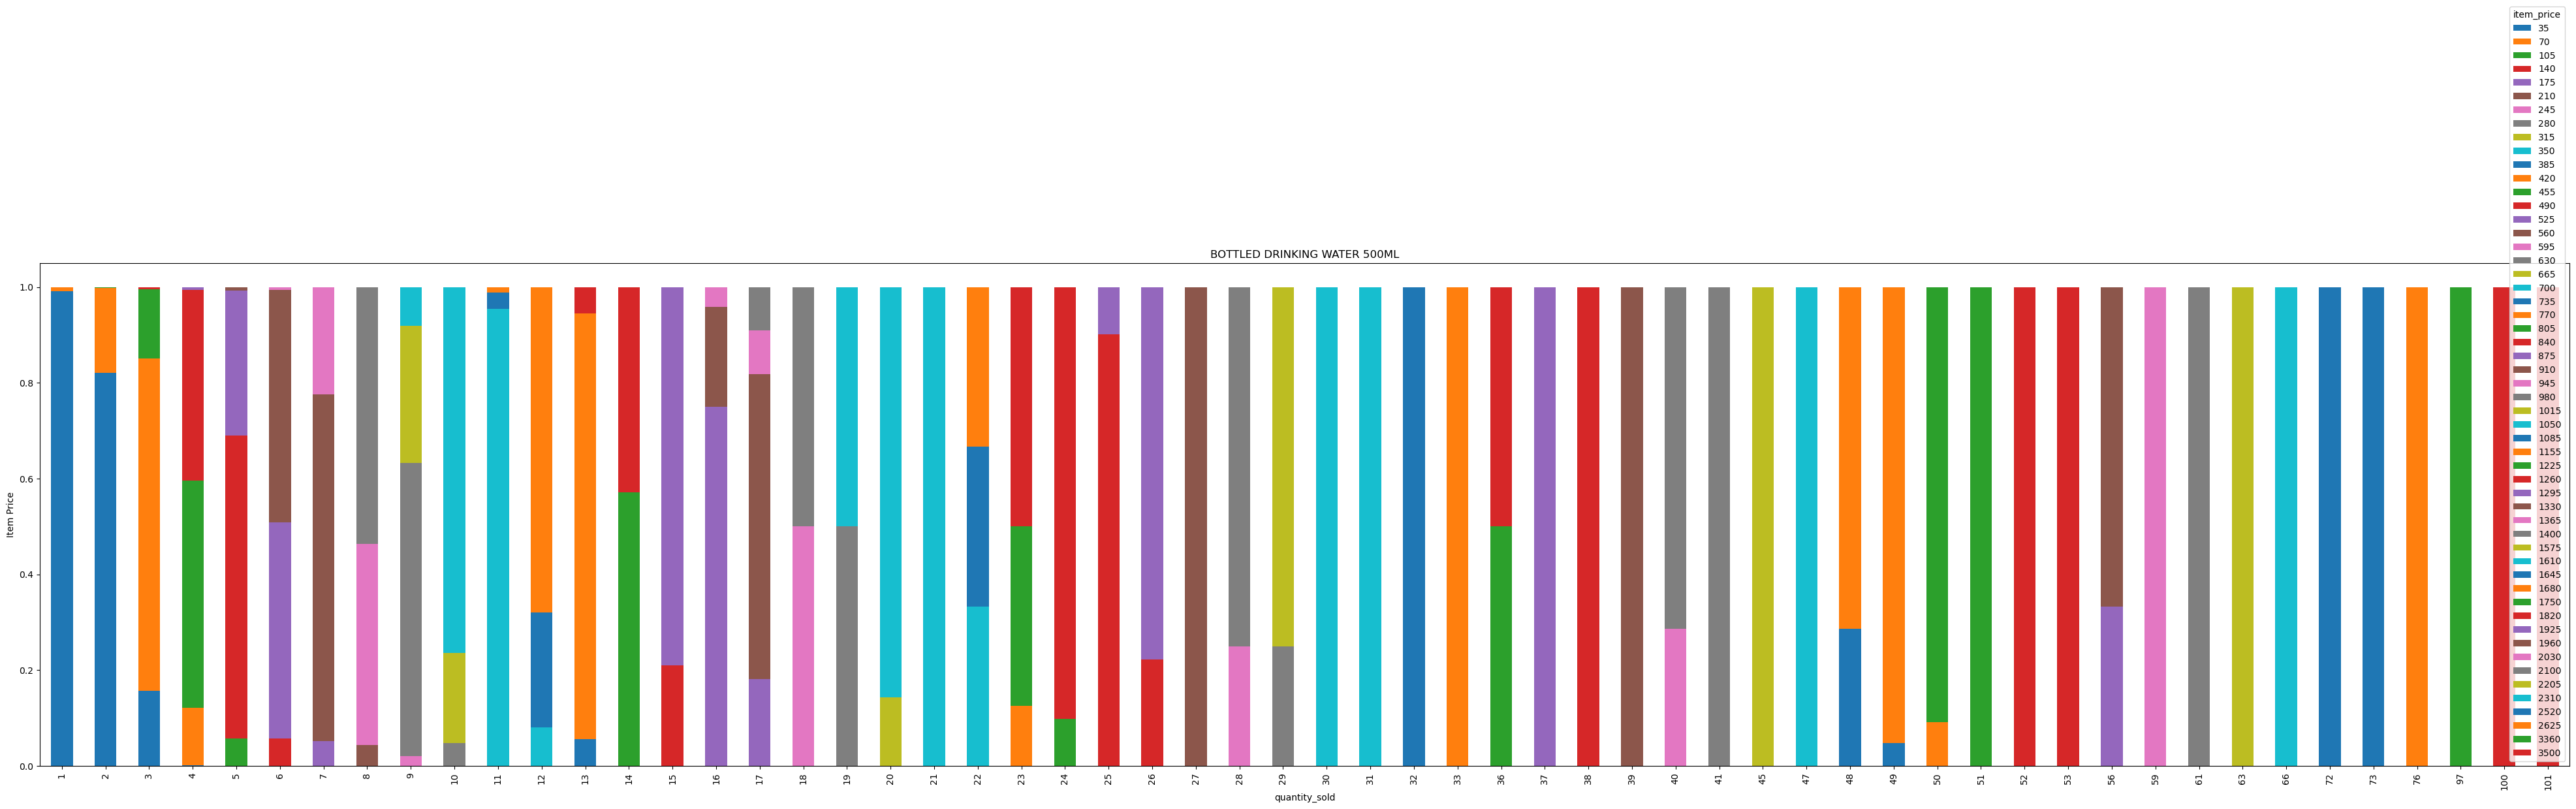

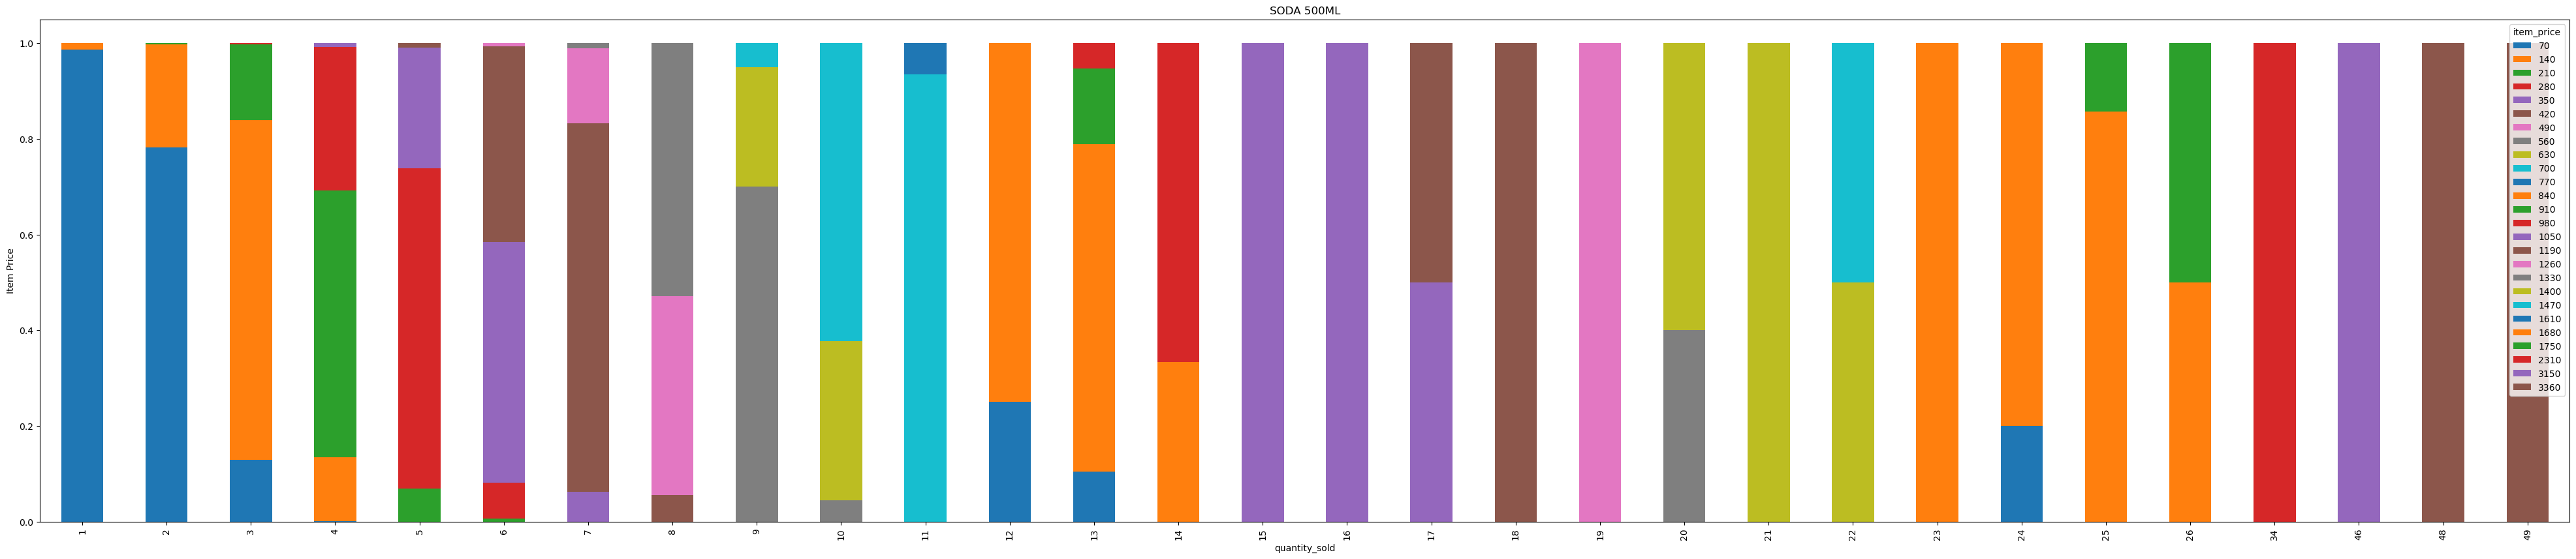

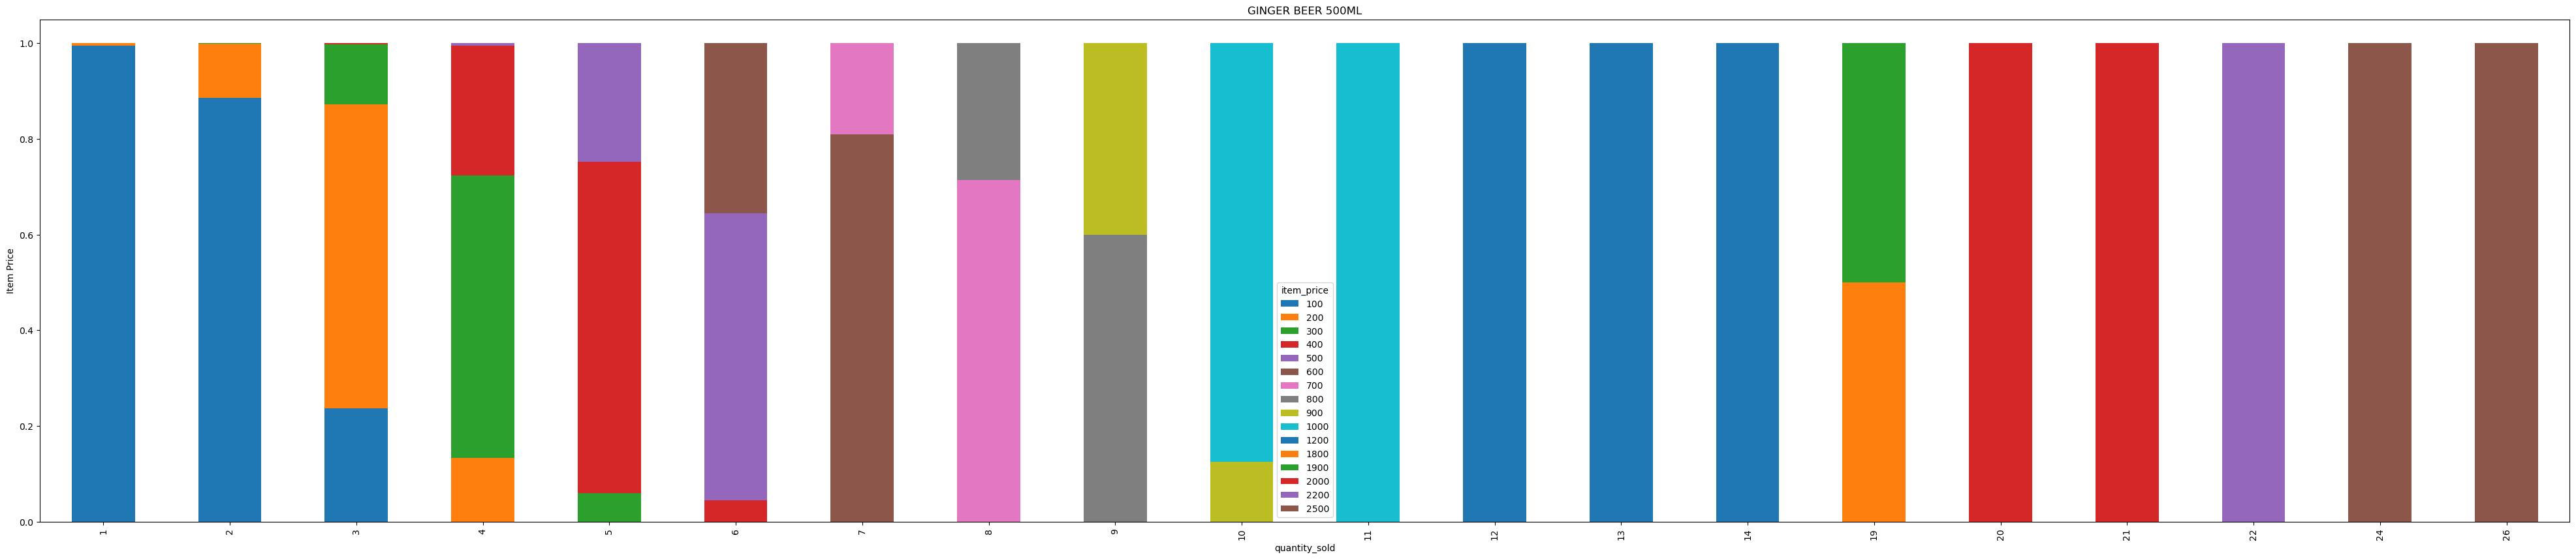

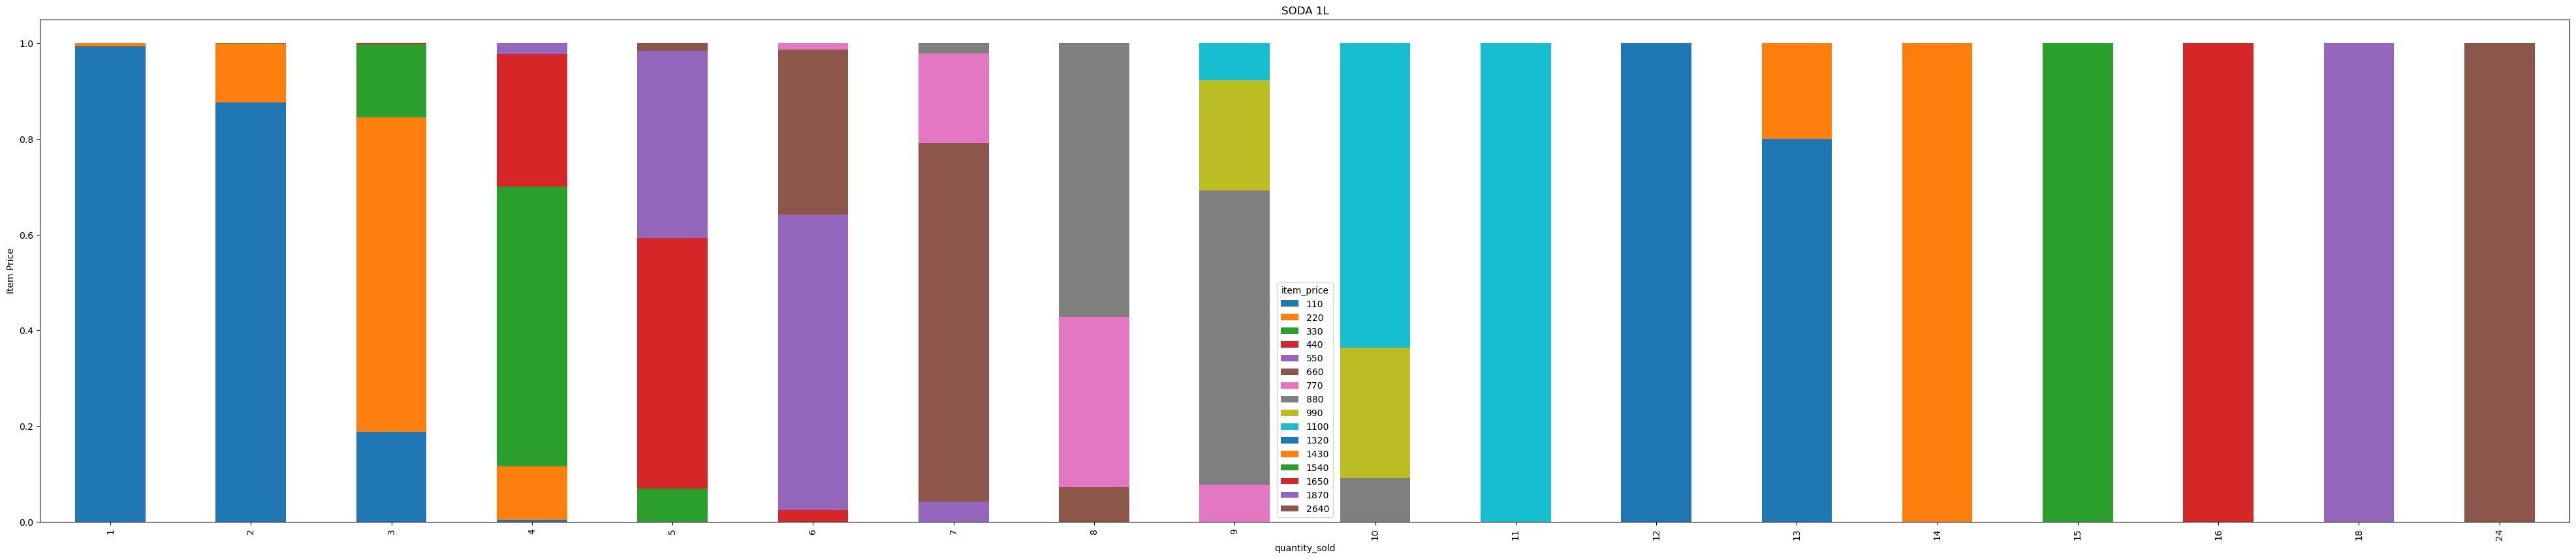

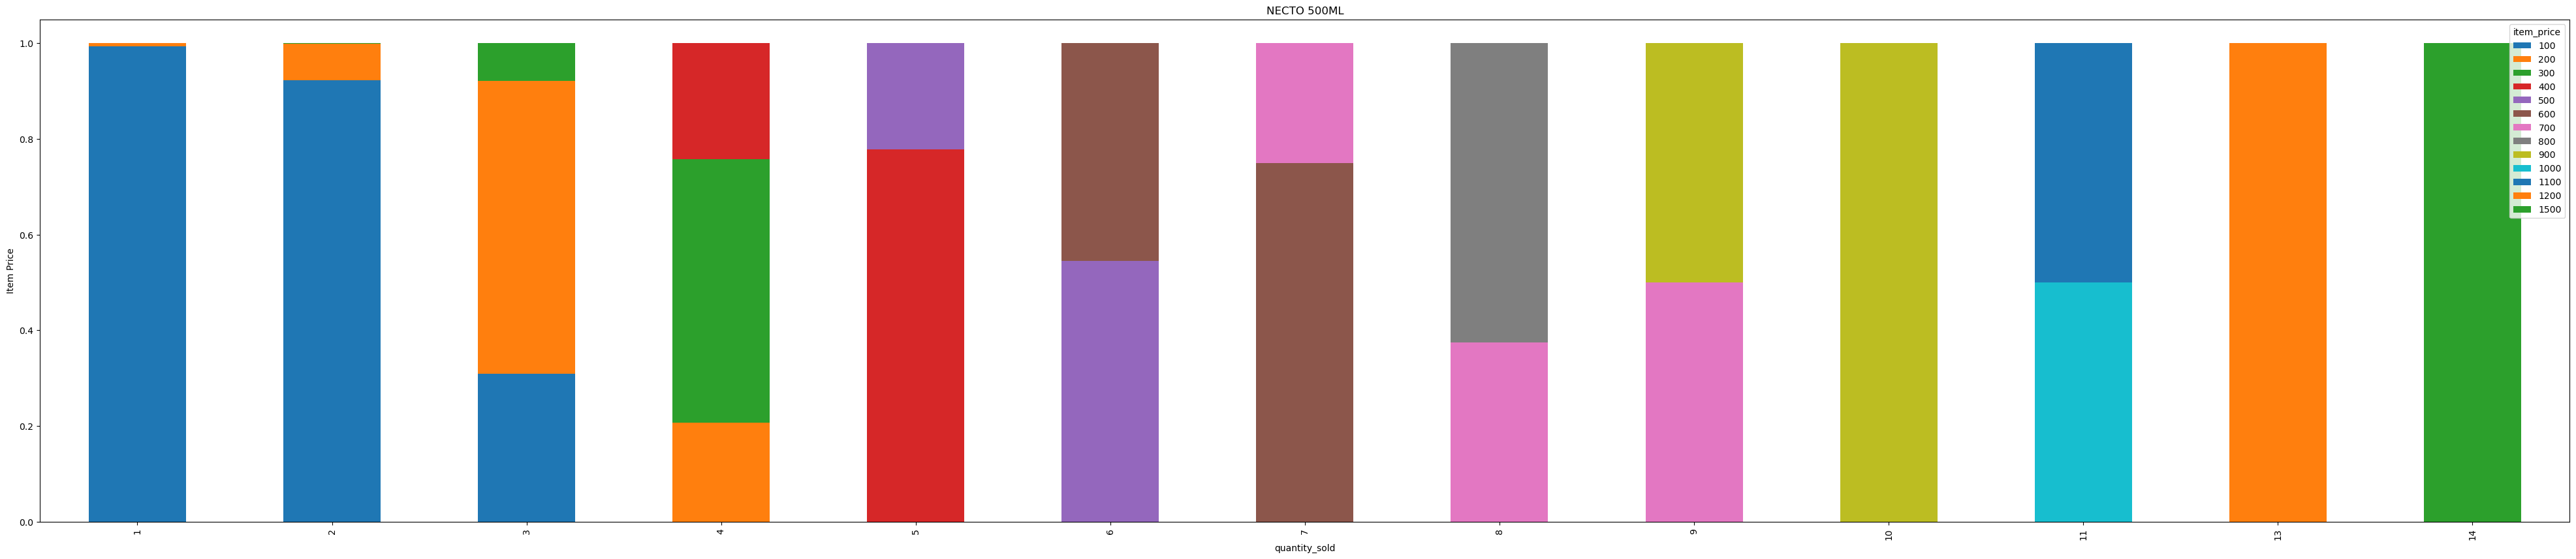

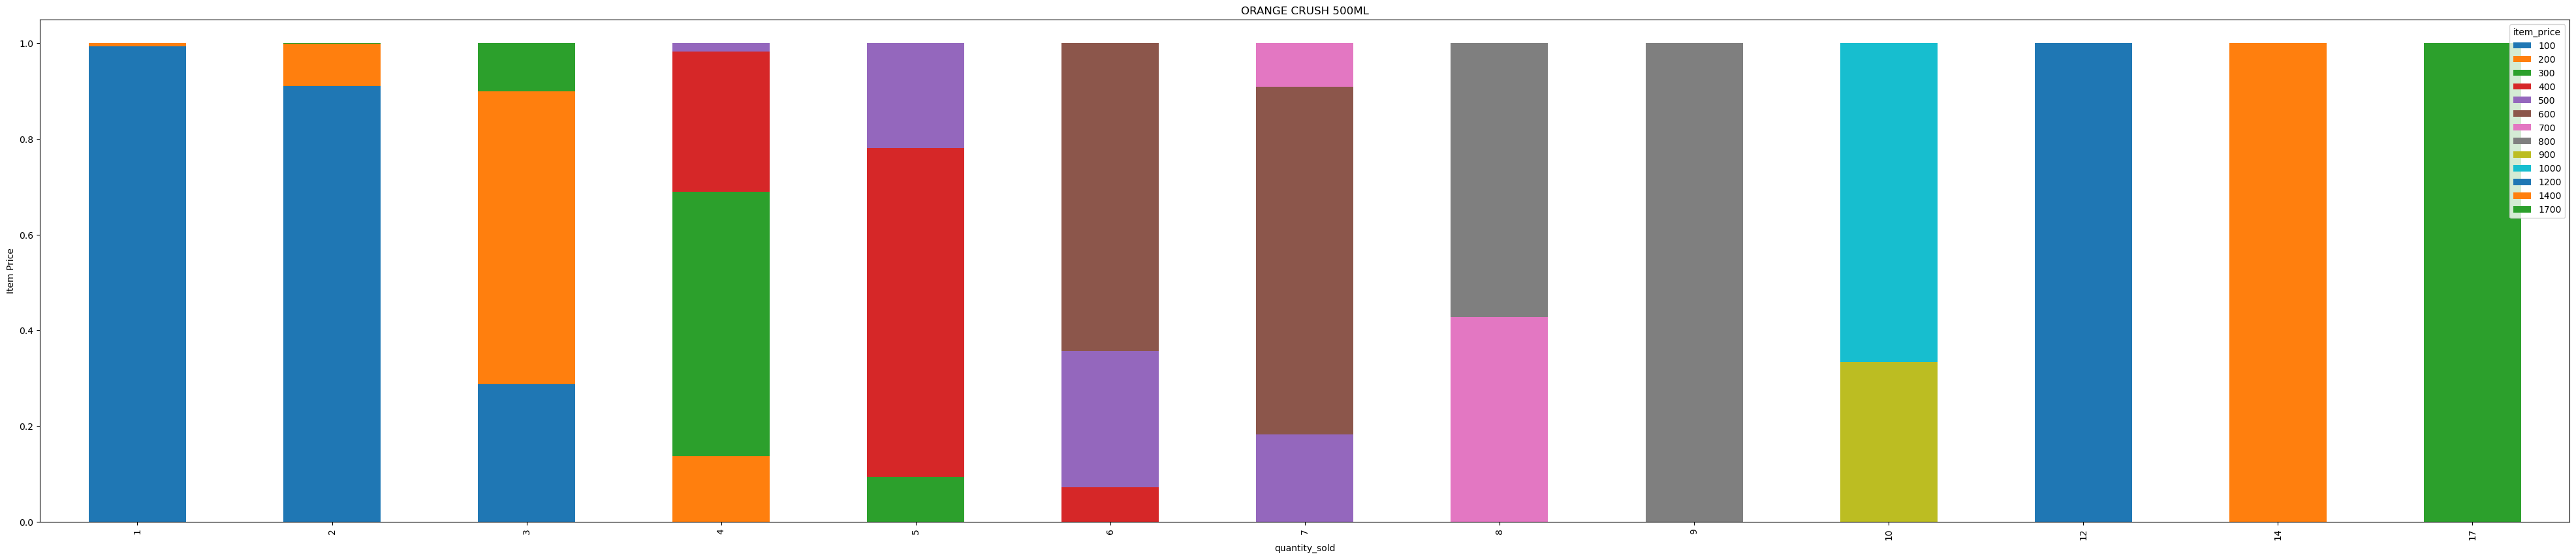

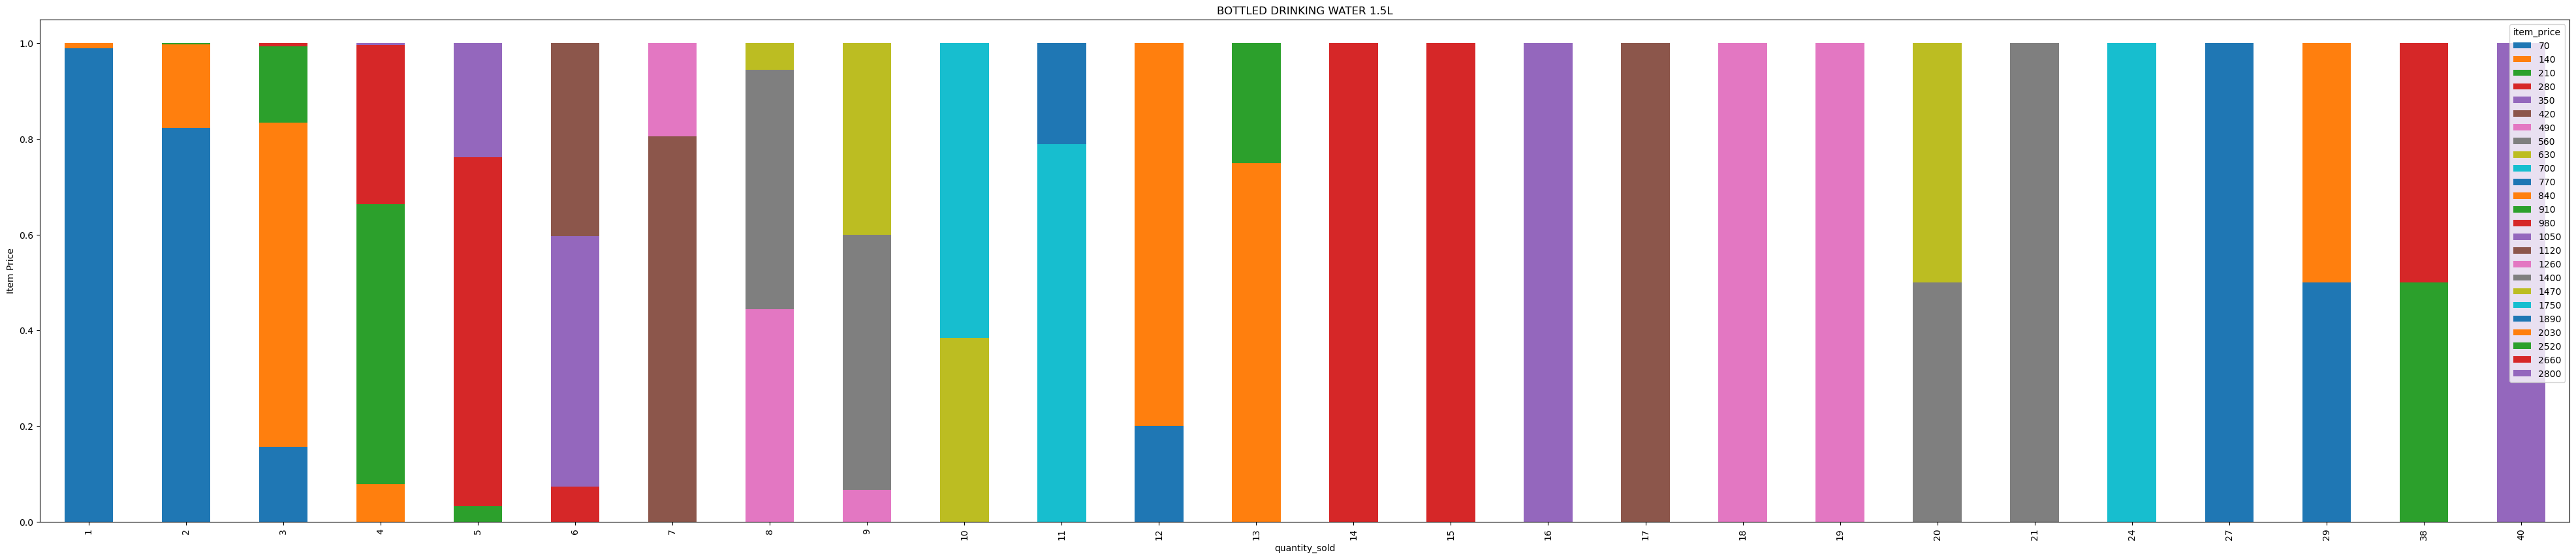

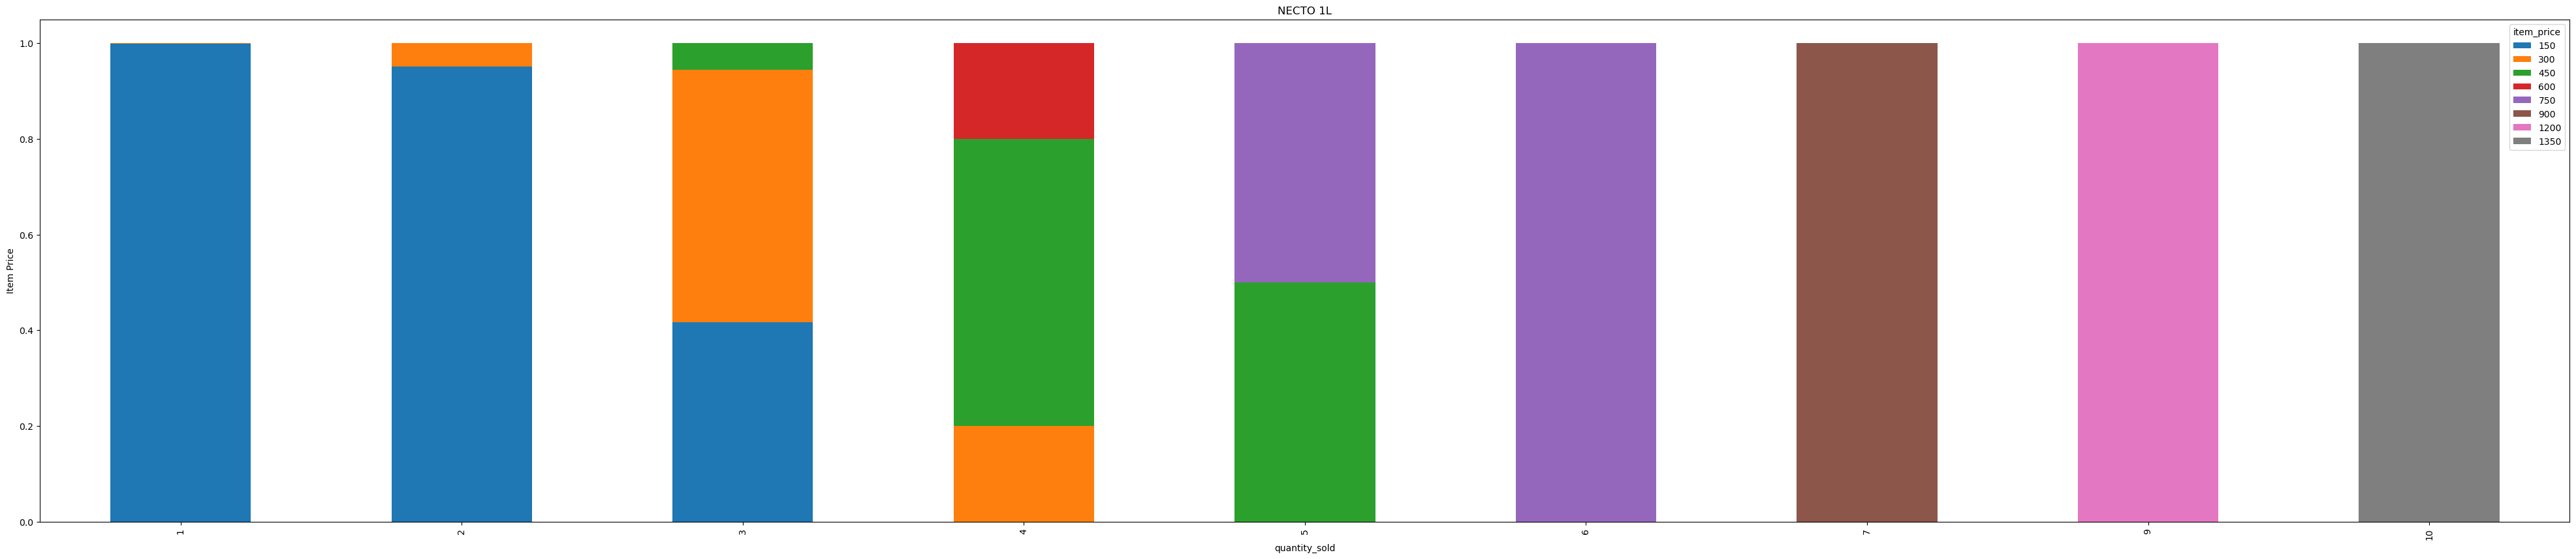

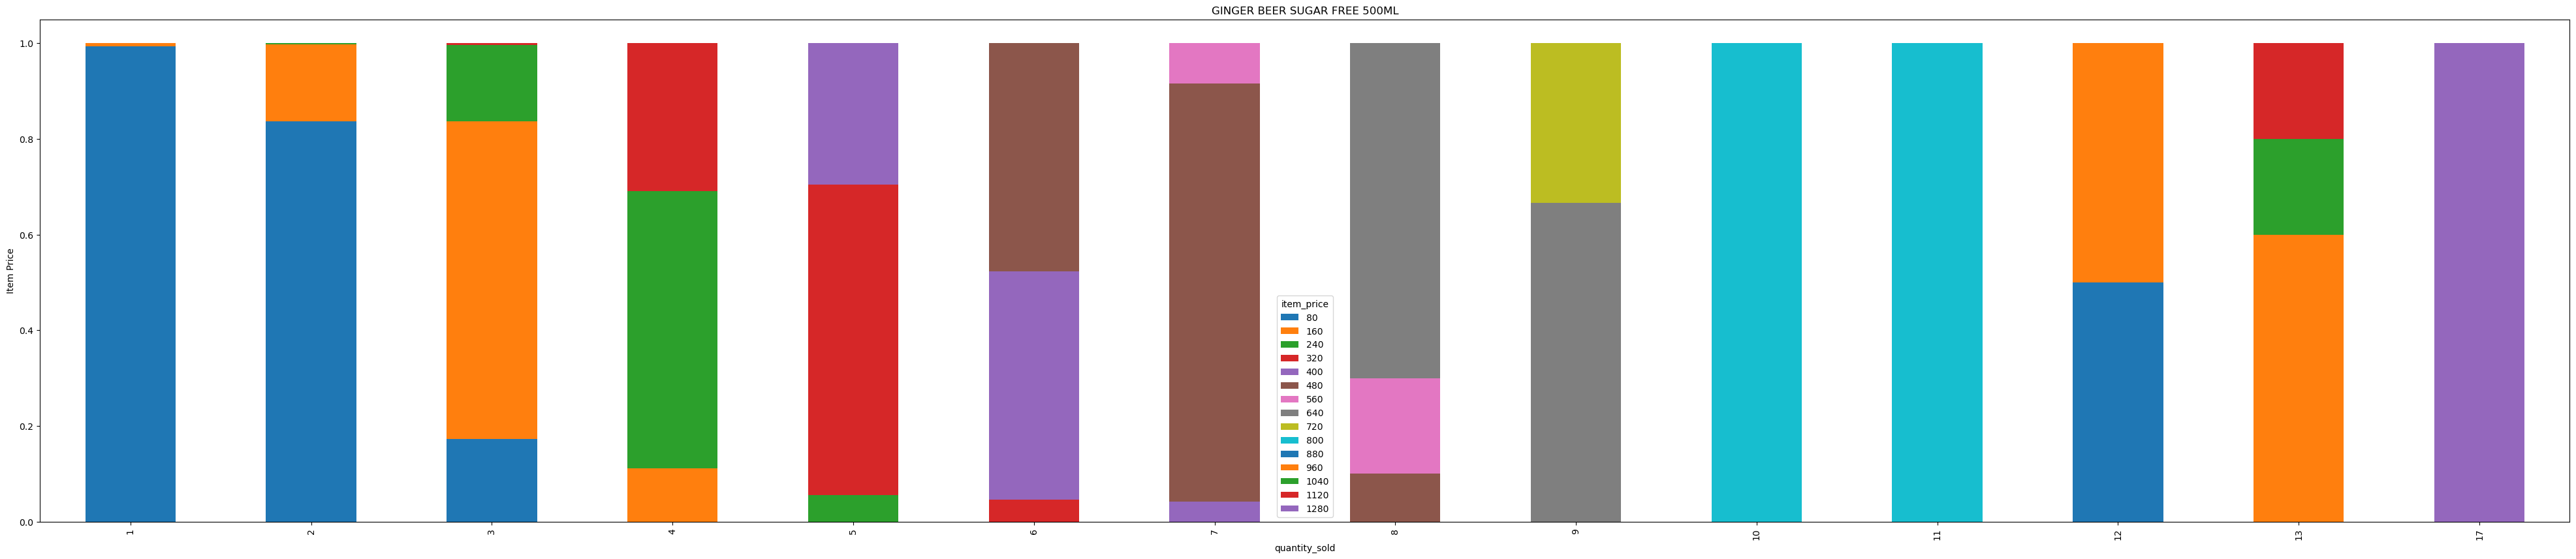

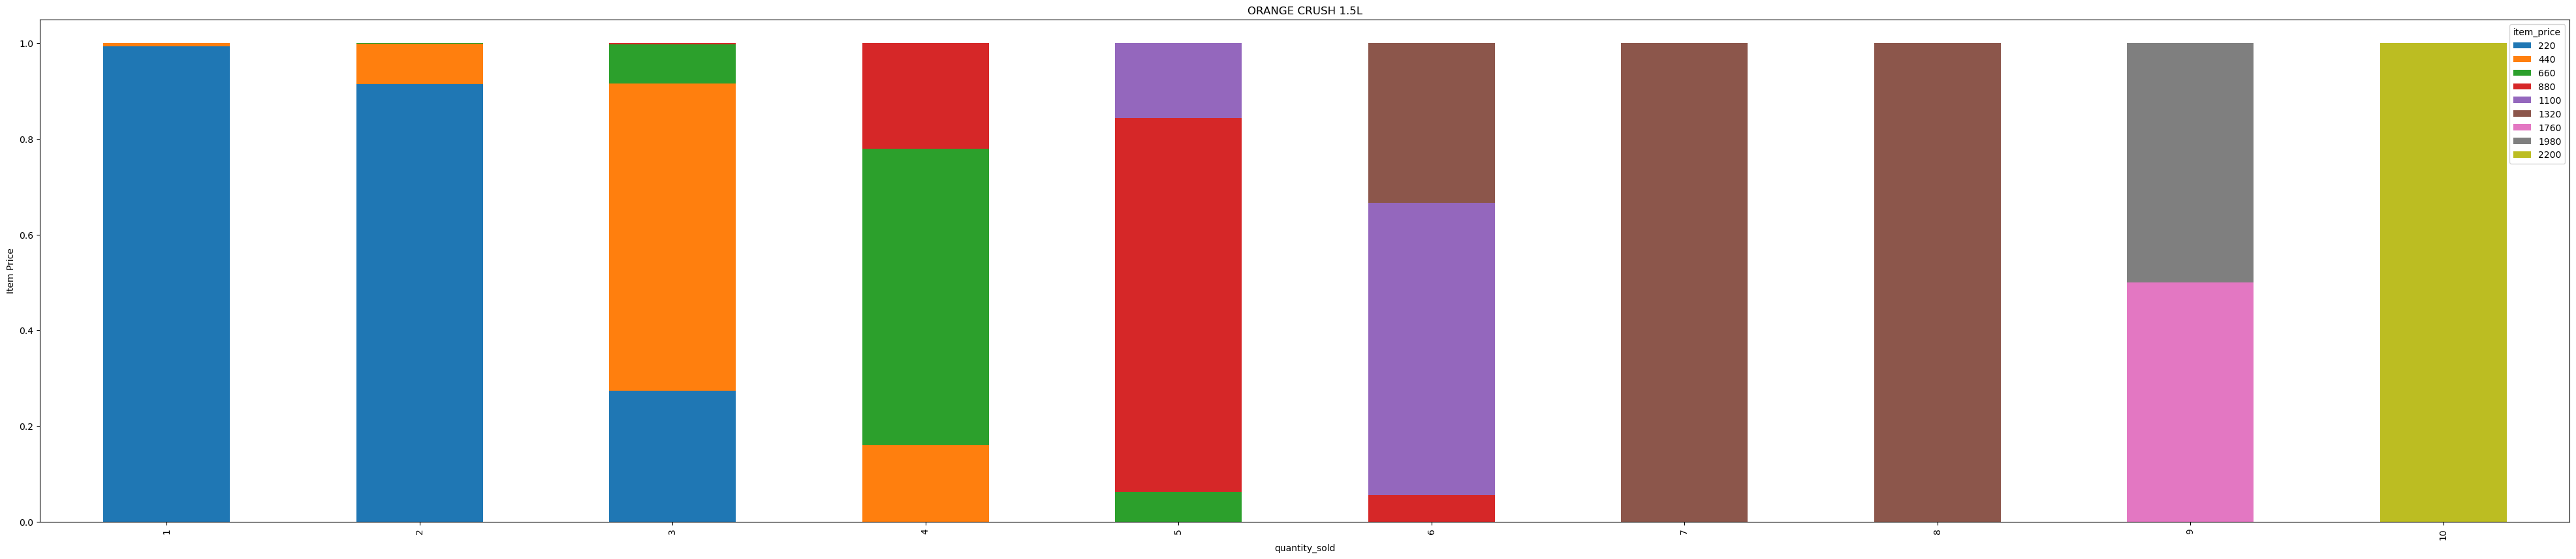

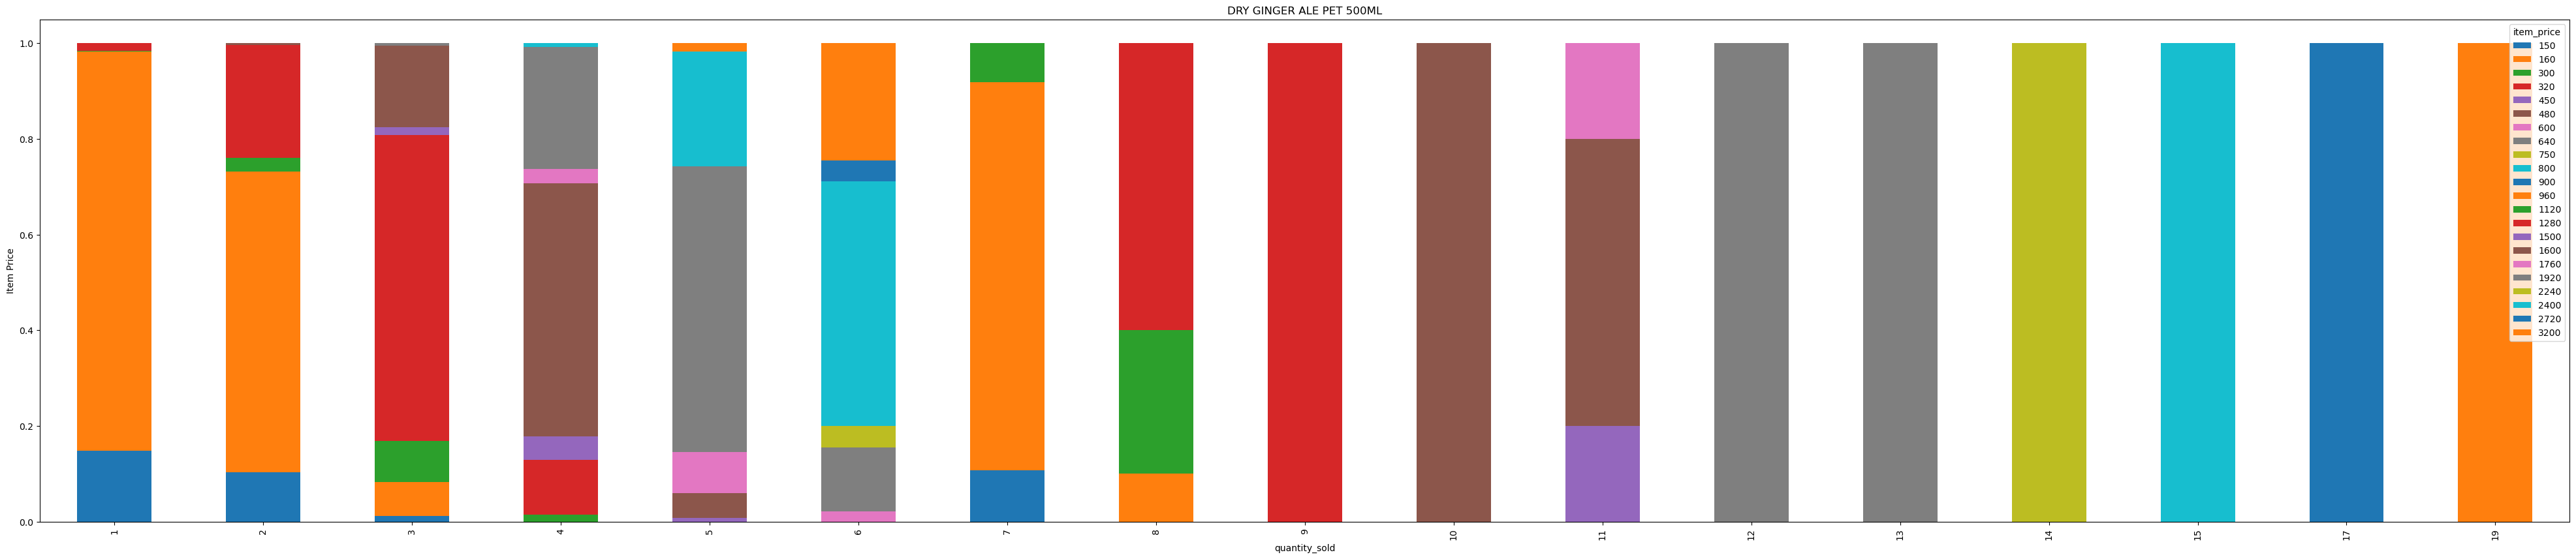

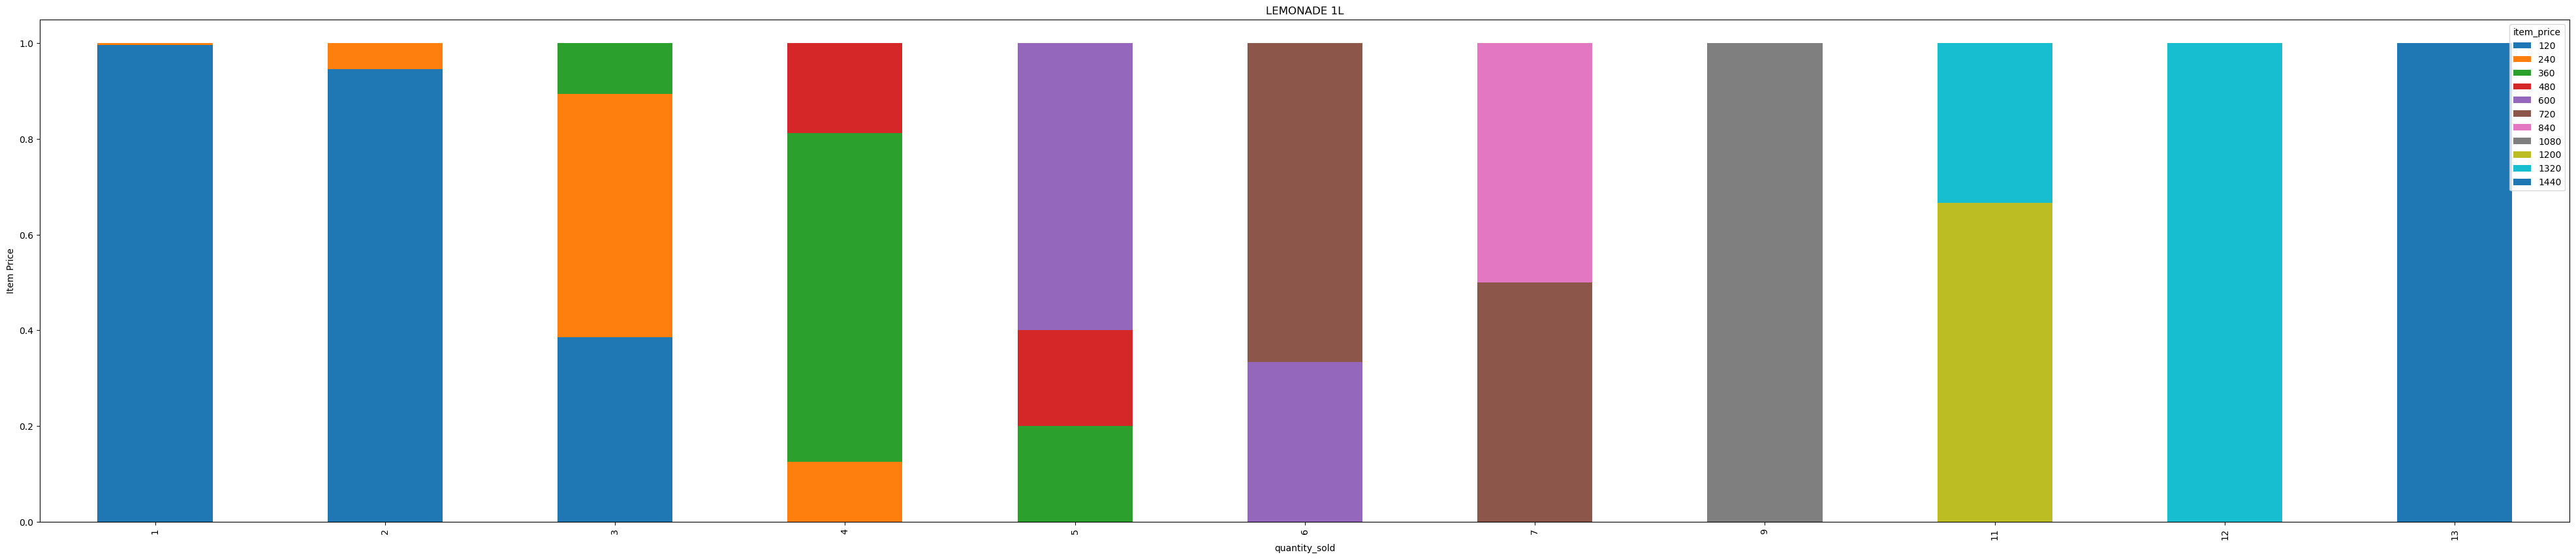

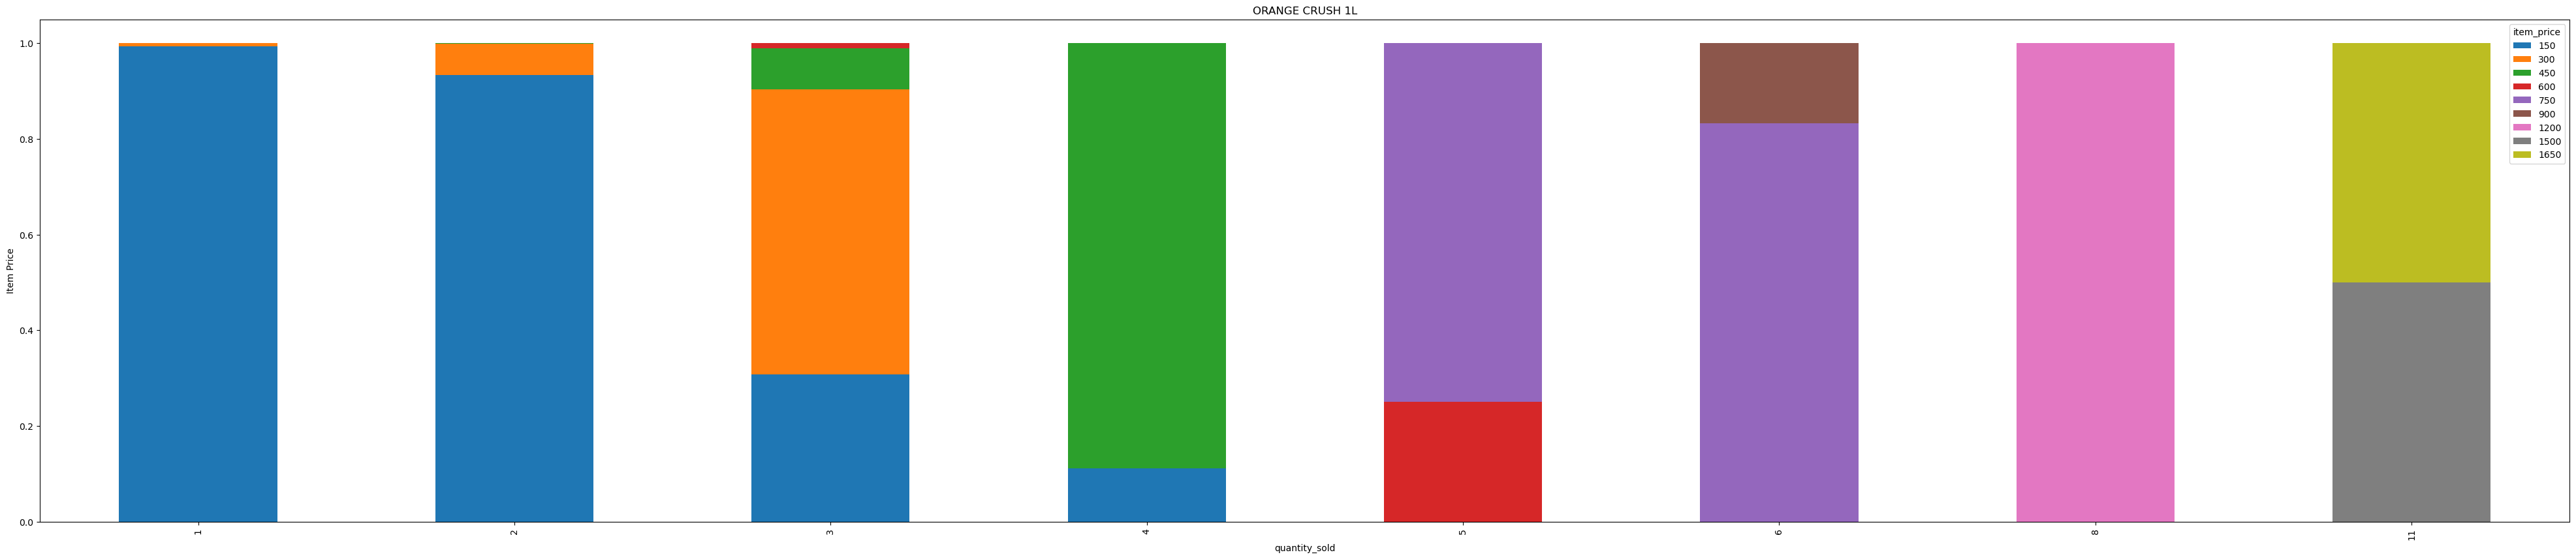

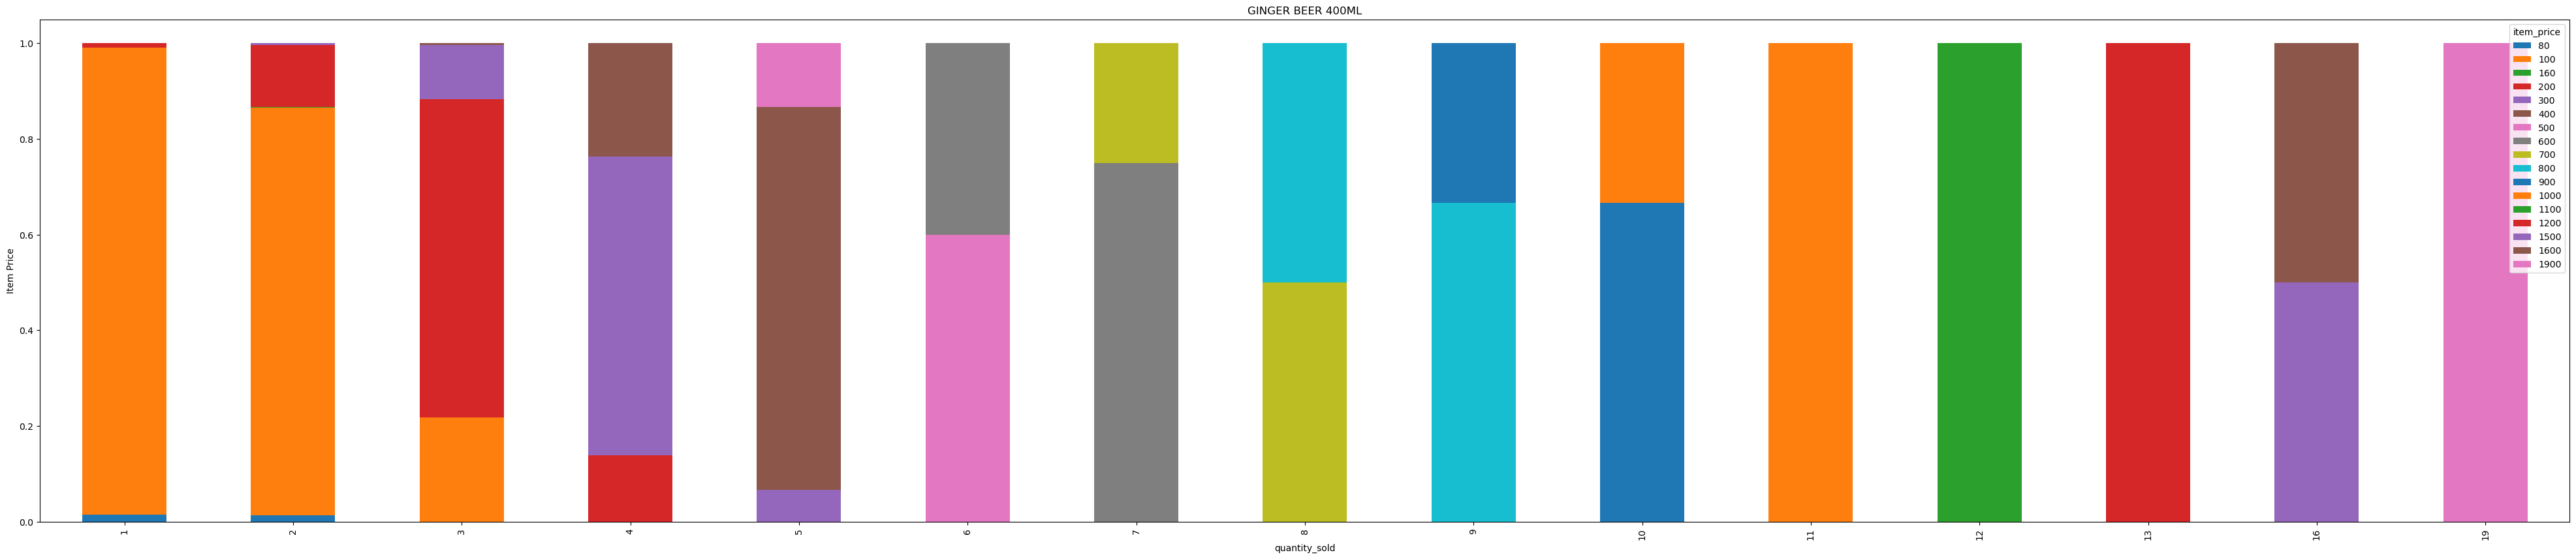

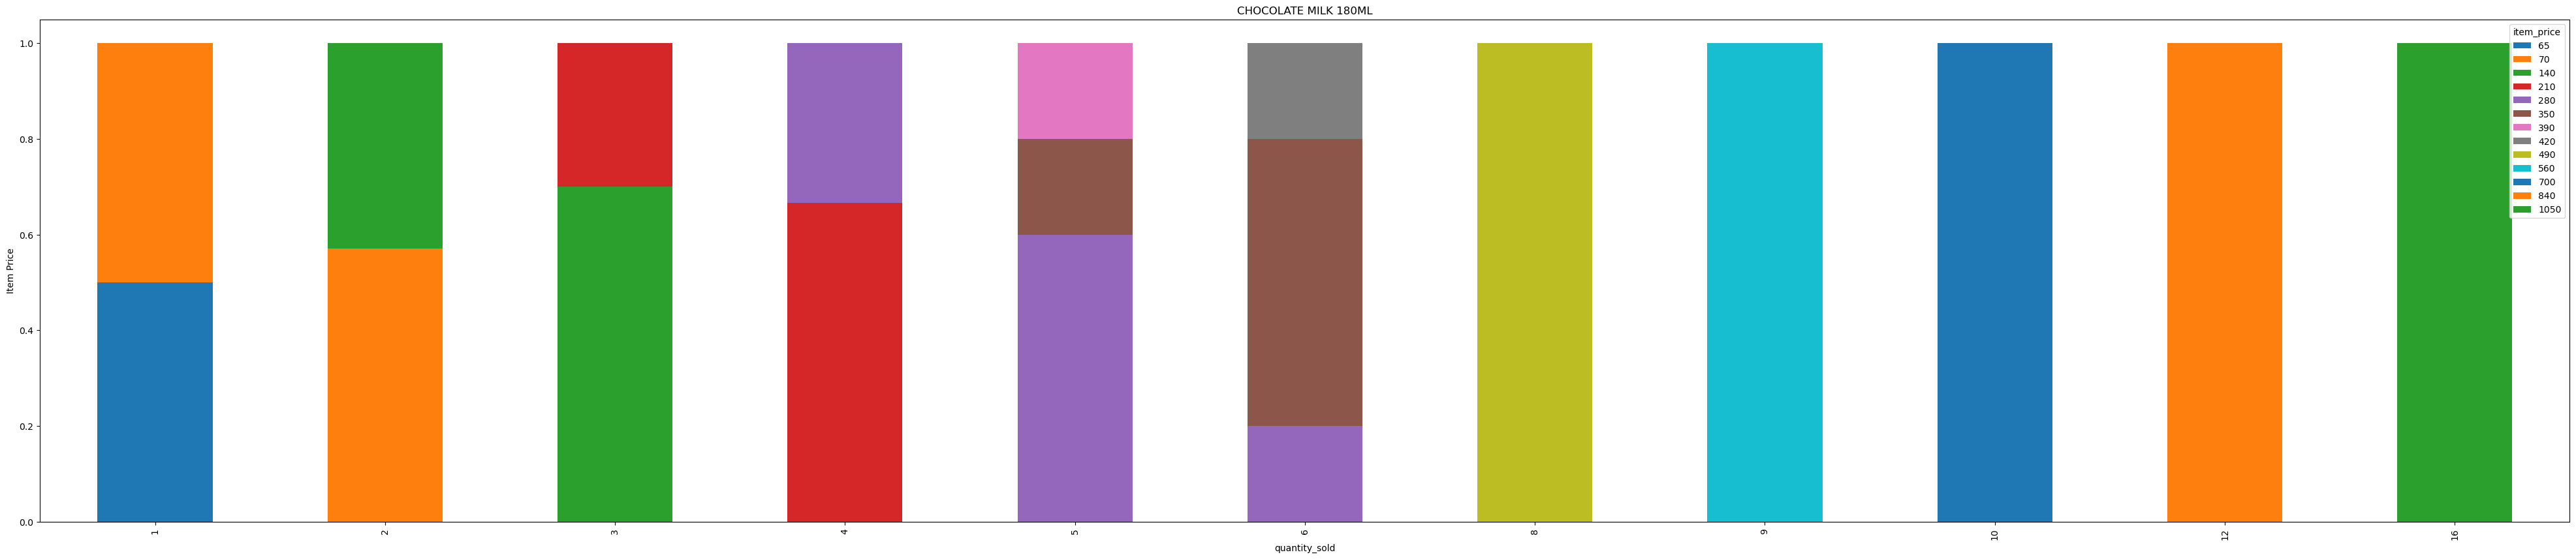

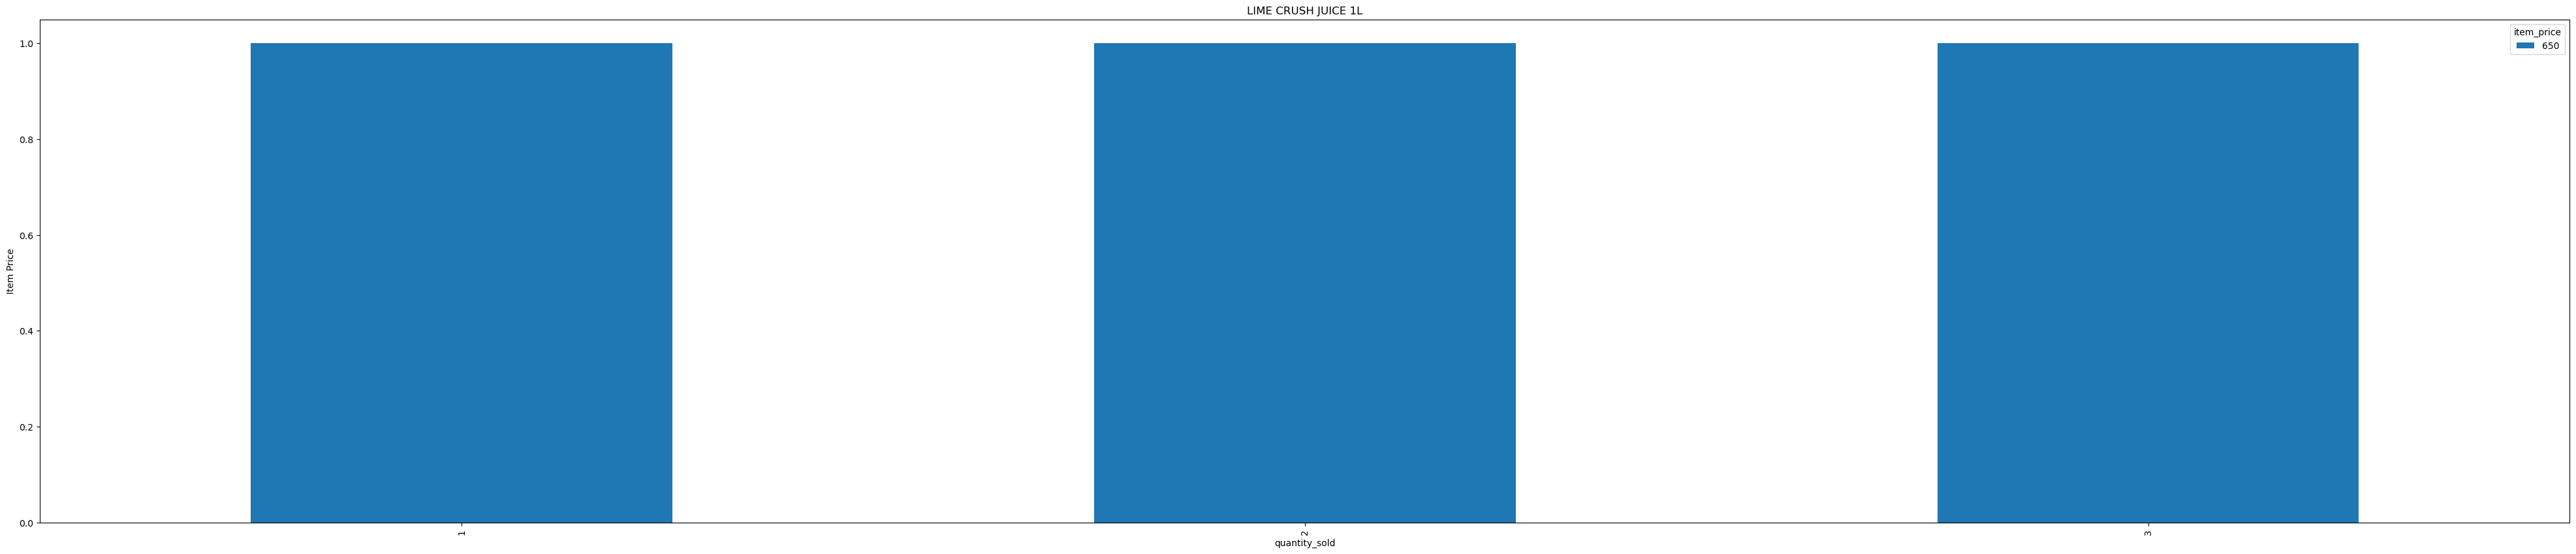

In [66]:
item_count_prices(df2['item_description'].unique())

In [67]:
df[df['quantity_sold']==0]

Empty DataFrame
Columns: [item_description, transaction_date, shop_id, item_price, quantity_sold]
Index: []

In [68]:

st.head()

shop_id  shop_area_sq_ft  shop_profile
0  SHOP047              528           1.0
1  SHOP009              676           2.0
2  SHOP083              676           0.0
3  SHOP117              676           0.0
4  SHOP042              676           0.0

In [69]:
df.describe().T

count        mean         std   min    25%    50%    75%  \
item_price     473974.0  206.689734  166.764732  35.0  100.0  200.0  220.0   
quantity_sold  473974.0    1.943151    1.618962   1.0    1.0    2.0    2.0   

                   max  
item_price     17400.0  
quantity_sold    101.0

In [70]:
st.describe().T

count        mean         std    min     25%    50%    75%  \
shop_area_sq_ft  124.0  619.991935  126.770165  298.0  553.25  617.0  676.0   
shop_profile     100.0    0.950000    0.821123    0.0    0.00    1.0    2.0   

                    max  
shop_area_sq_ft  1077.0  
shop_profile        2.0

In [71]:
df.item_description.unique()

array(['ORANGE BARLEY 1.5L', 'GINGER BEER 1.5L', 'TONIC PET 500ML',
       'CREAM SODA 1L', 'STRAWBERRY MILK 180ML', 'CREAM SODA 1.5L',
       'TWISTEE APPLE 1L', 'FIT O MIXED FRUIT 200ML', 'SODA PET 1.5L',
       'FIT O MIXED FRUIT 1L', 'KIK COLA 1L', 'LEMONADE 500ML',
       'FIT O ORANGE 1L', 'NECTO 1.5L', 'LEMONADE 1.5L', 'GINGER BEER 1L',
       'FIT O MANGO 200ML', 'FIT O MANGO 1L', 'CREAM SODA 500ML',
       'FIT O ORANGE 200ML', nan, 'CREAM SODA APPLE POP 1L',
       'BOTTLED DRINKING WATER 500ML', 'SODA 500ML', 'GINGER BEER 500ML',
       'SODA 1L', 'NECTO 500ML', 'ORANGE CRUSH 500ML',
       'BOTTLED DRINKING WATER 1.5L', 'NECTO 1L',
       'GINGER BEER SUGAR FREE 500ML', 'ORANGE CRUSH 1.5L',
       'DRY GINGER ALE PET 500ML', 'LEMONADE 1L', 'ORANGE CRUSH 1L',
       'GINGER BEER 400ML', 'CHOCOLATE MILK 180ML', 'LIME CRUSH JUICE 1L'],
      dtype=object)

In [72]:
len(df.item_description.unique())

38

In [73]:
len(df.customer_id.unique())

AttributeError: 'DataFrame' object has no attribute 'customer_id'

In [ ]:
df.shop_id.unique()

In [ ]:
len(df.shop_id.unique())

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df.info()

In [ ]:
earliest_date = df['transaction_date'].min()
latest_date = df['transaction_date'].max()
print("Earliest Date: ",earliest_date,"\nLatest Date: ",latest_date)